# COVID-19 Data and Visualizations
# National- and State-Level Graphs of Key Pandemic Metrics
# SCROLL DOWN to Find Your State!

#### Import Statements

In [11]:
import os
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from operator import itemgetter
from matplotlib.pyplot import figure
import matplotlib as mpl

#### Load Data

In [2]:
state_data_url="https://covidtracking.com/api/v1/states/daily.csv"
s=requests.get(state_data_url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=['date'])

usa_data_url="https://covidtracking.com/api/v1/us/daily.csv"
t=requests.get(usa_data_url).content
df_us=pd.read_csv(io.StringIO(t.decode('utf-8')), parse_dates=['date'])

state_pops = pd.read_csv('state_pops.csv', header=None).set_index(2)

#### Drop Deprecated Variables

In [3]:
df = df.drop(['checkTimeEt','commercialScore','dateChecked','dateModified',
              'deathIncrease','grade','hospitalized','hospitalizedIncrease',
              'negativeIncrease','negativeRegularScore','negativeScore',
              'posNeg','positiveIncrease','positiveScore','score','total',
              'totalTestResultsIncrease'],axis=1)

#### Create Dictionary of DataFrames, One for Each State

In [4]:
states = df.state.unique()

dfs = {}

dfs['USA'] = df_us.set_index('date')

for state in states:
    key = state
    value = df[df.state==state].set_index('date').drop('state', axis=1)
    dfs[key] = value

## VARIABLE CONSTRUCTION

#### Daily and Cumulative Variables

In [5]:
for state in dfs.keys():
    # New Positives
    dfs[state]['new_pos'] = dfs[state]['positive'] - dfs[state]['positive'].shift(-1)

    # New Negatives
    dfs[state]['new_neg'] = dfs[state]['negative'] - dfs[state]['negative'].shift(-1)

    # New Tests Total
    dfs[state]['new_tests'] = dfs[state]['new_pos'] + dfs[state]['new_neg']

    # Daily percent positive
    dfs[state]['daily_pct_pos'] = 100 * dfs[state]['new_pos'] / dfs[state]['new_tests']

    # Total Tests to Date
    dfs[state]['total_tests'] = dfs[state]['positive'] + dfs[state]['negative']

    # New Hospitalizations
    dfs[state]['new_hosp'] = dfs[state]['hospitalizedCumulative'] - dfs[state]['hospitalizedCumulative'].shift(-1)

    # New Deaths
    dfs[state]['new_deaths'] = dfs[state]['death'] - dfs[state]['death'].shift(-1)

    # max(New Positives)
    dfs[state]['peak_rate'] = np.max(dfs[state]['new_pos'])

    # Date of max(New Positives)
    dfs[state]['peak_date'] = dfs[state].index[dfs[state]['new_pos'] == dfs[state]['peak_rate']][0]

    # Active cases
    dfs[state]['active'] = dfs[state]['positive'] - dfs[state]['death'] - dfs[state]['recovered']

    # Daily growth factor relative to positive tests
    dfs[state]['daily_growth_factor_a'] = dfs[state]['new_pos'] / dfs[state]['positive']

    # Daily growth factor relative to ('Active' = pos-deaths-recovered)
    dfs[state]['daily_growth_factor_b'] = dfs[state]['new_pos'] / dfs[state]['active']

#### PER CAPITA Daily and Cumulative Variables

In [6]:
for state in dfs.keys():
    # New Positives
    dfs[state]['new_pos_pc'] = dfs[state]['new_pos'] / state_pops.loc[state][1]

    # New Negatives
    dfs[state]['new_neg_pc'] = dfs[state]['new_neg'] / state_pops.loc[state][1]

    # New Tests Total
    dfs[state]['new_tests_pc'] = dfs[state]['new_tests'] / state_pops.loc[state][1]

    # Total Tests to Date
    dfs[state]['total_tests_pc'] = dfs[state]['total_tests'] / state_pops.loc[state][1]

    # New Hospitalizations
    dfs[state]['new_hosp_pc'] = dfs[state]['new_hosp'] / state_pops.loc[state][1]

    # New Deaths
    dfs[state]['new_deaths_pc'] = dfs[state]['new_deaths'] / state_pops.loc[state][1]

    # Active cases
    dfs[state]['active'] = dfs[state]['positive'] - dfs[state]['death'] - dfs[state]['recovered']

## Set size of rolling window

In [24]:
######################################################
######################################################

window = 7

######################################################
######################################################

#### Rolling Average Variables

In [25]:
for state in dfs.keys():
    # ROLLING AVERAGES OF:

    # new cases
    dfs[state]['new_cases_rolling'] = dfs[state]['new_pos'].rolling(window=window).mean()

    # hospitalizations
    dfs[state]['new_hosp_rolling'] = dfs[state]['new_hosp'].rolling(window=window).mean()

    # new deaths
    dfs[state]['new_deaths_rolling'] = dfs[state]['new_deaths'].rolling(window=window).mean()

    # daily percent positive tests
    dfs[state]['daily_pct_pos_rolling'] = 100 * (dfs[state]['new_pos'] / dfs[state]['new_tests']).rolling(
        window=window).mean()

#### PER CAPITA Rolling Average Variables

In [26]:
for state in dfs.keys():
    
    # Rolling averages of:
    
    #new cases
    dfs[state]['new_cases_rolling_pc'] = dfs[state]['new_pos'].rolling(window=window).mean() / state_pops.loc[state][1]
   
    #new hospitalizations
    dfs[state]['new_hosp_rolling_pc'] = dfs[state]['new_hosp'].rolling(window=window).mean() / state_pops.loc[state][1]
    
    #new deaths
    dfs[state]['new_deaths_rolling_pc'] = dfs[state]['new_deaths'].rolling(window=window).mean() / state_pops.loc[state][1]

## GRAPHS:

USA


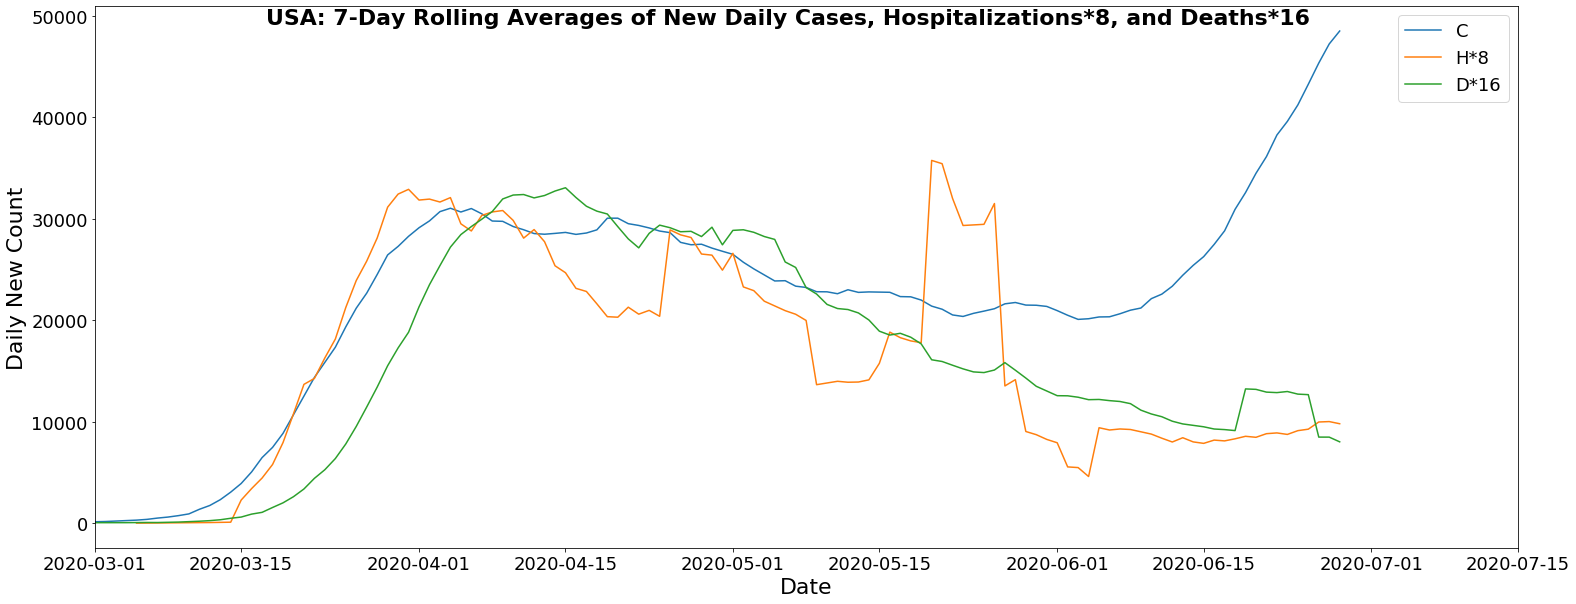

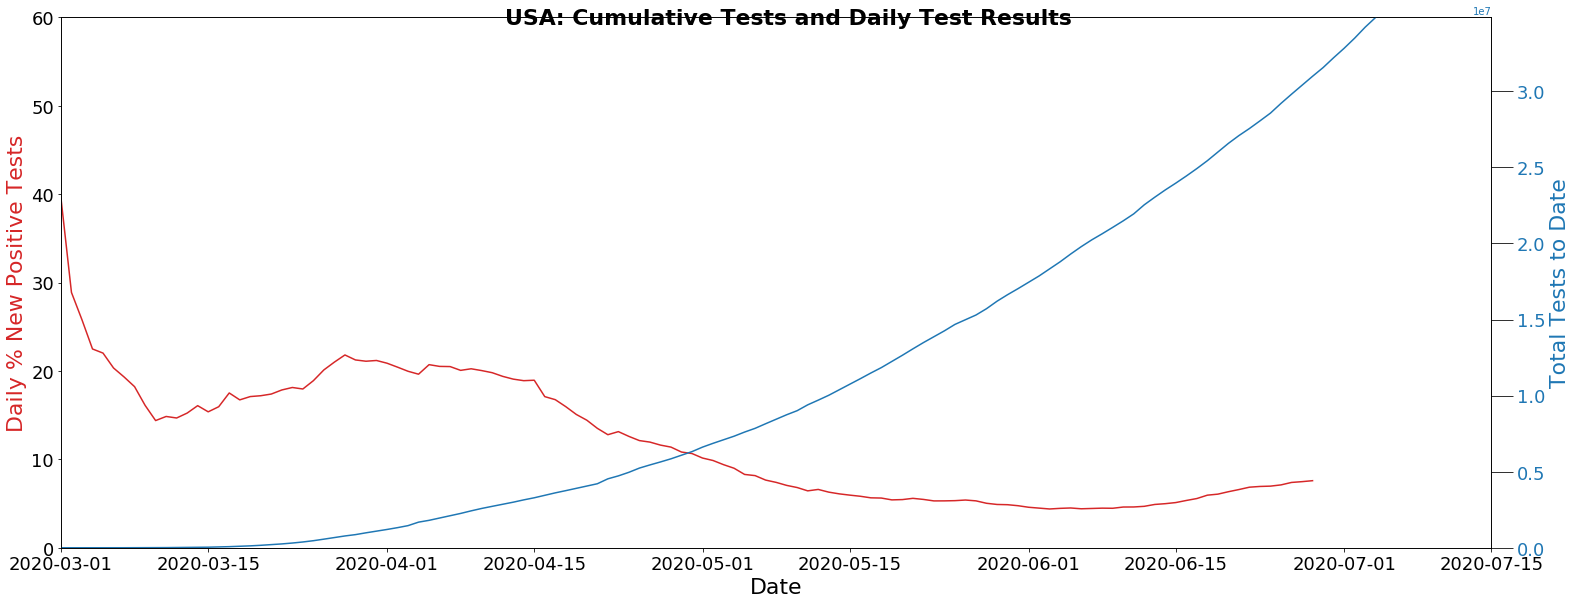

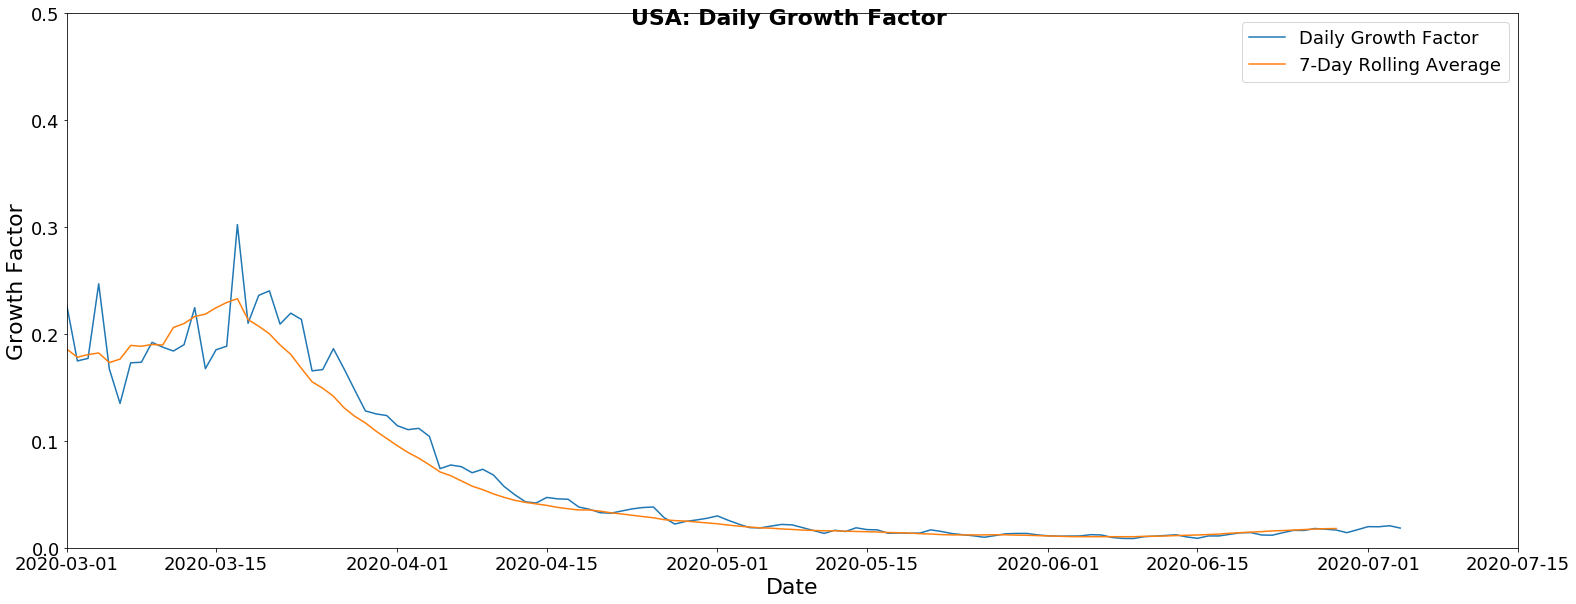

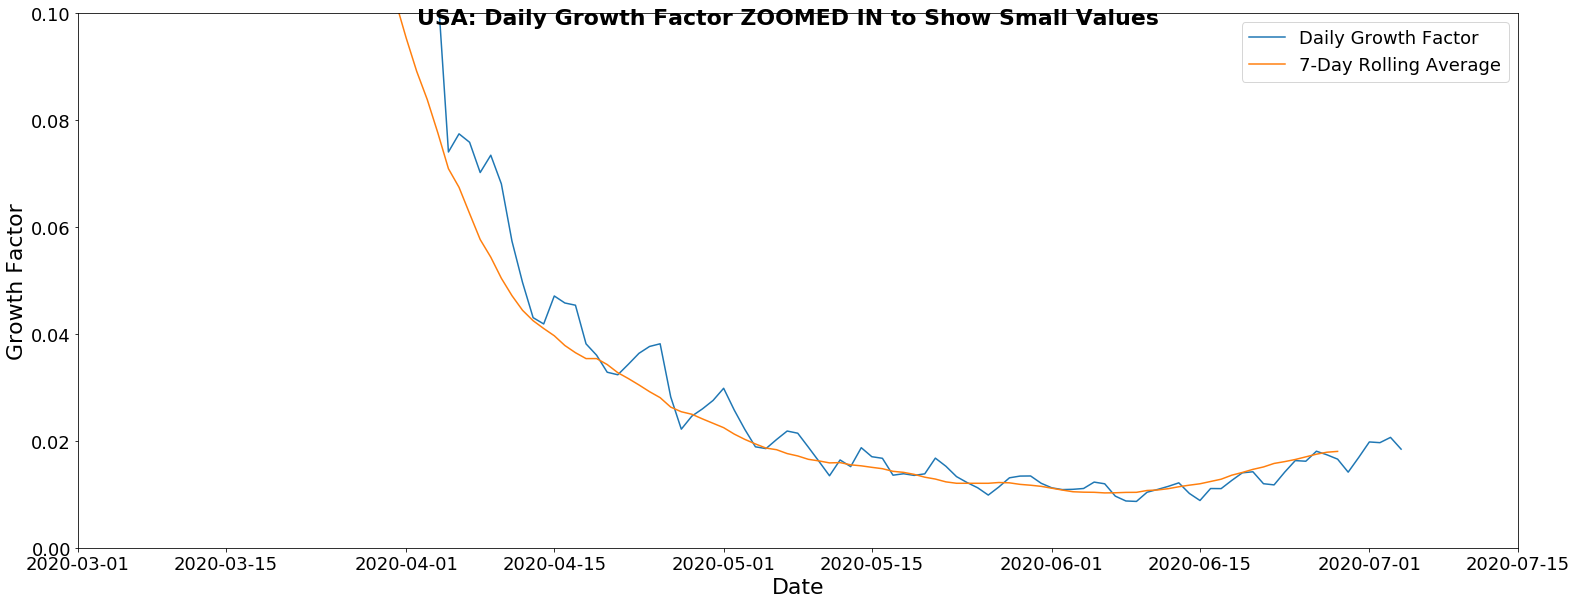












AK


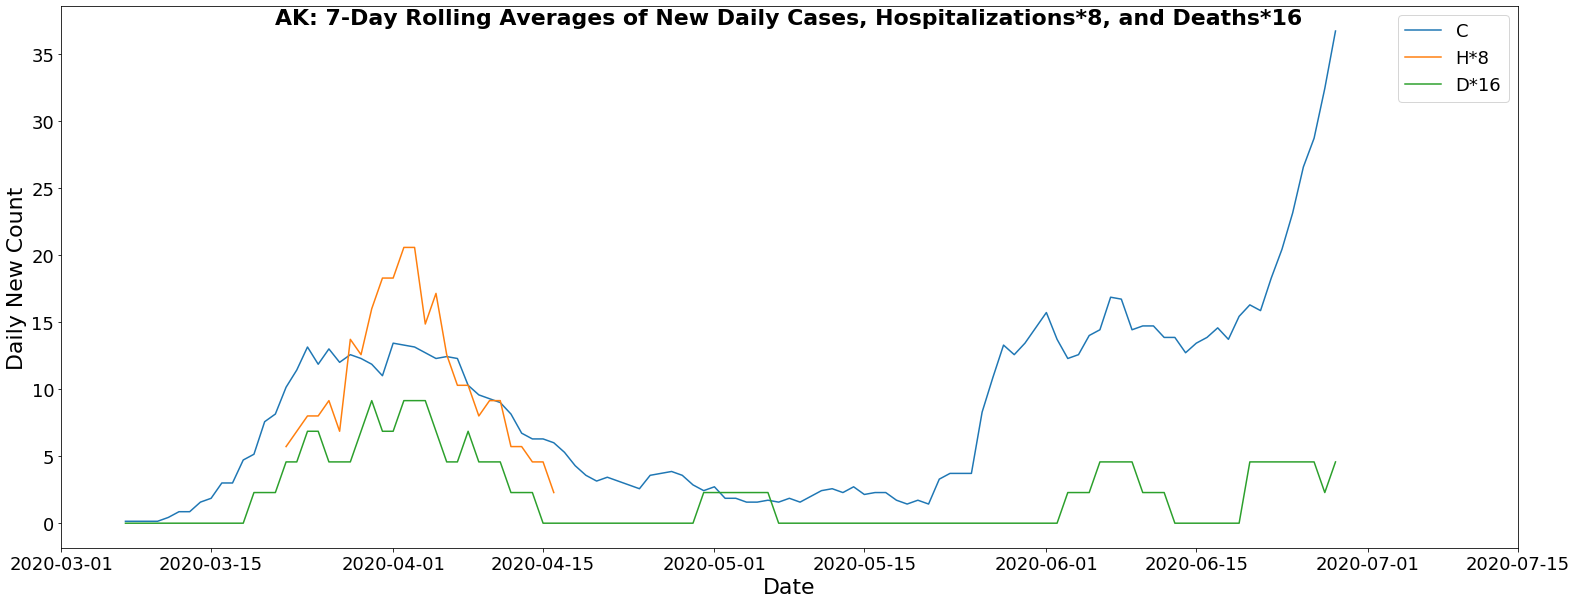

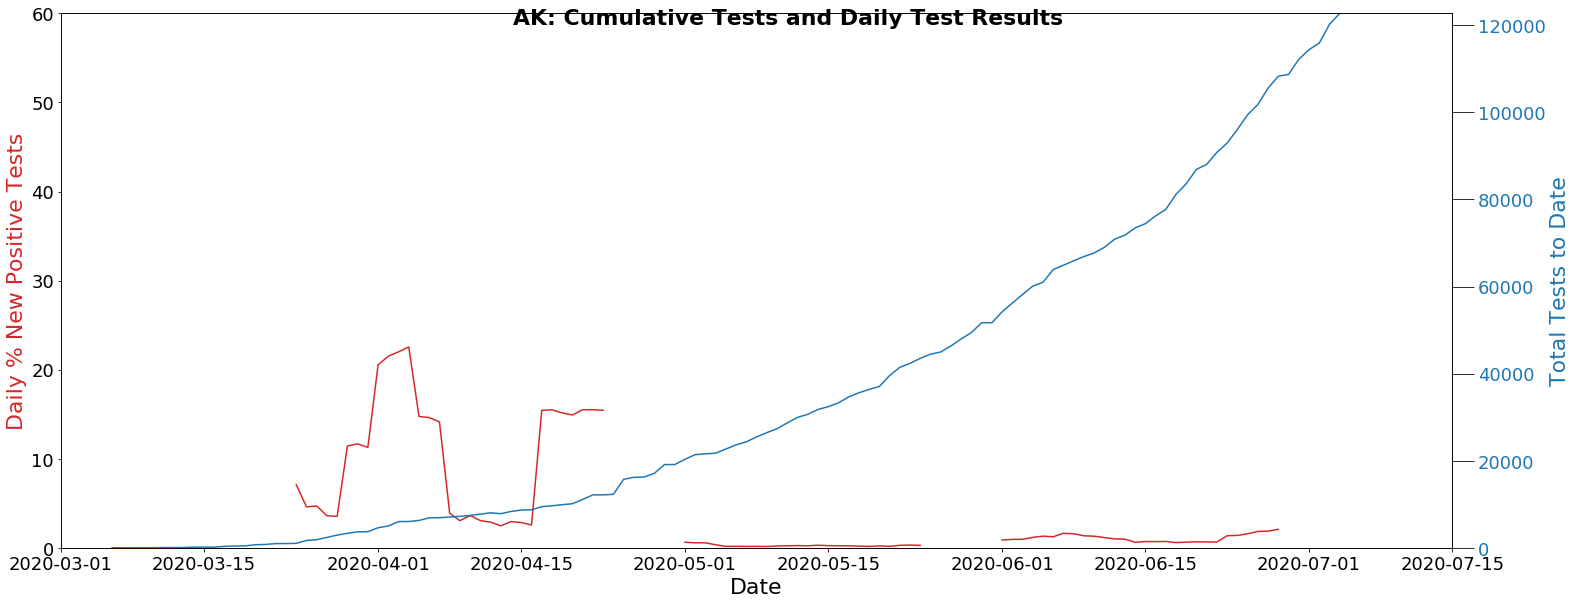

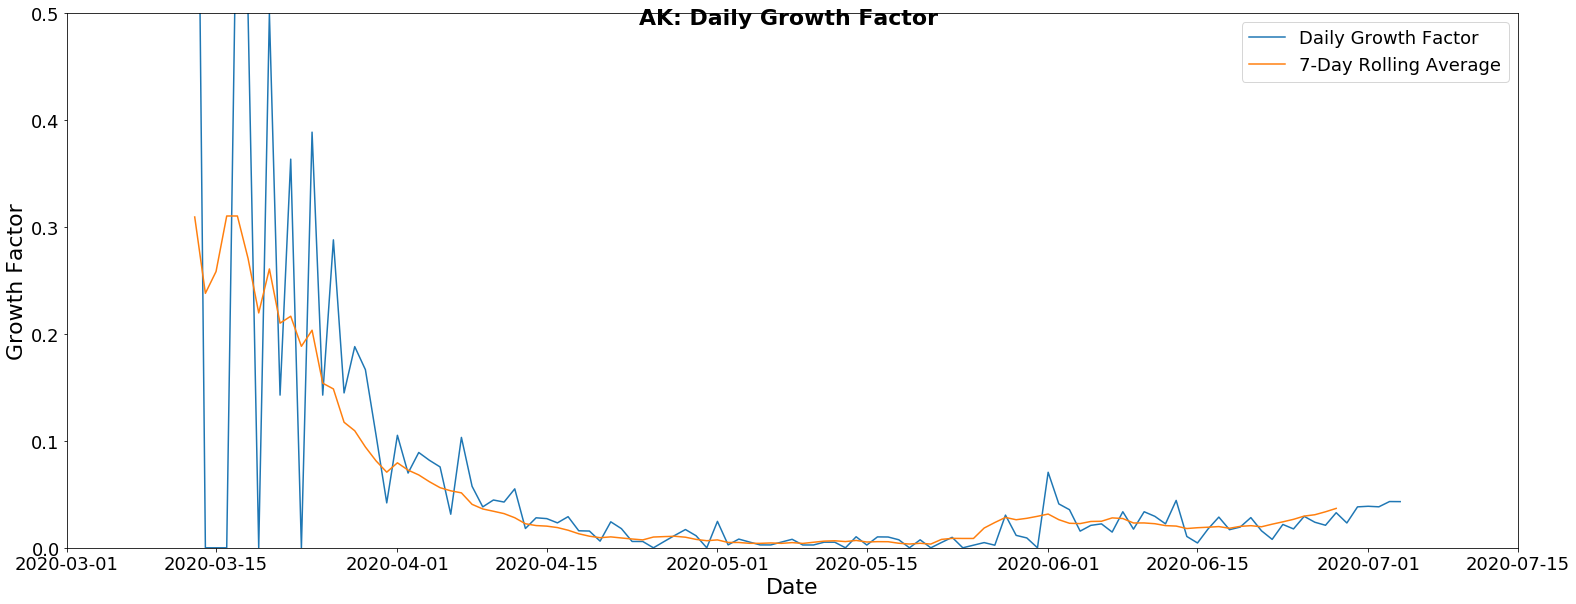

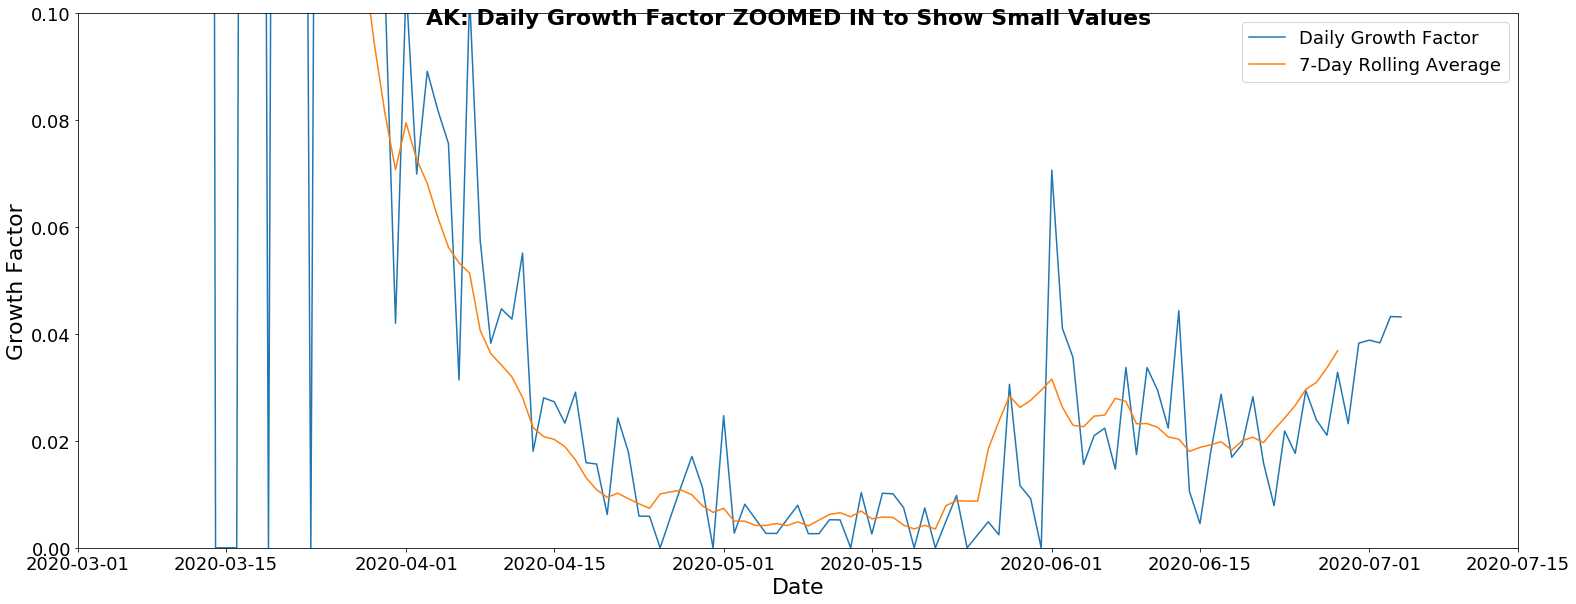












AL


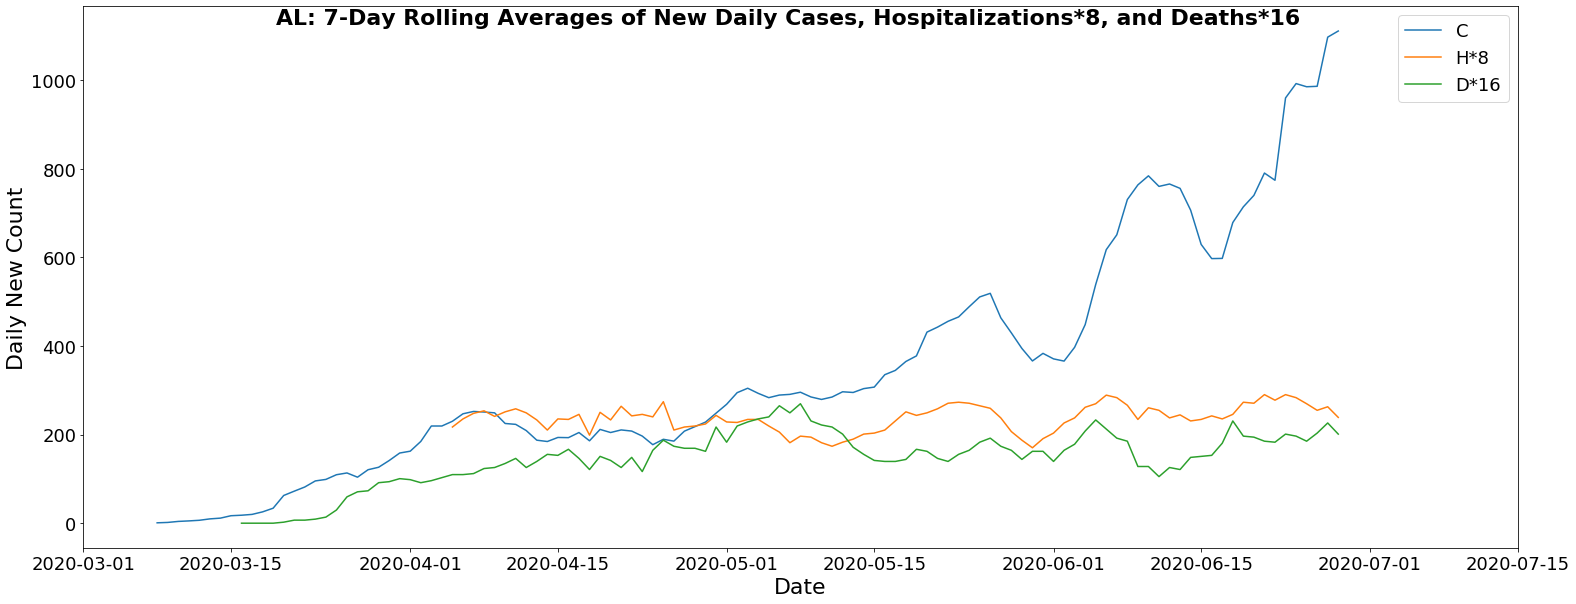

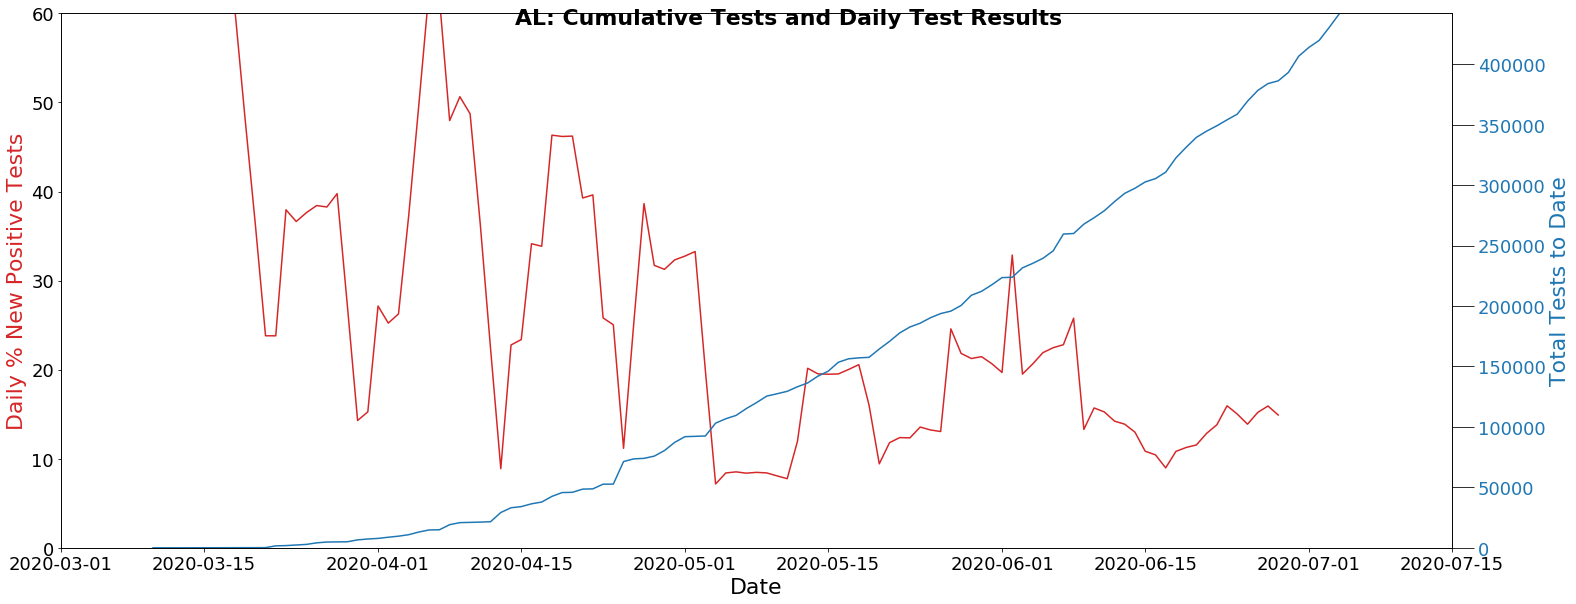

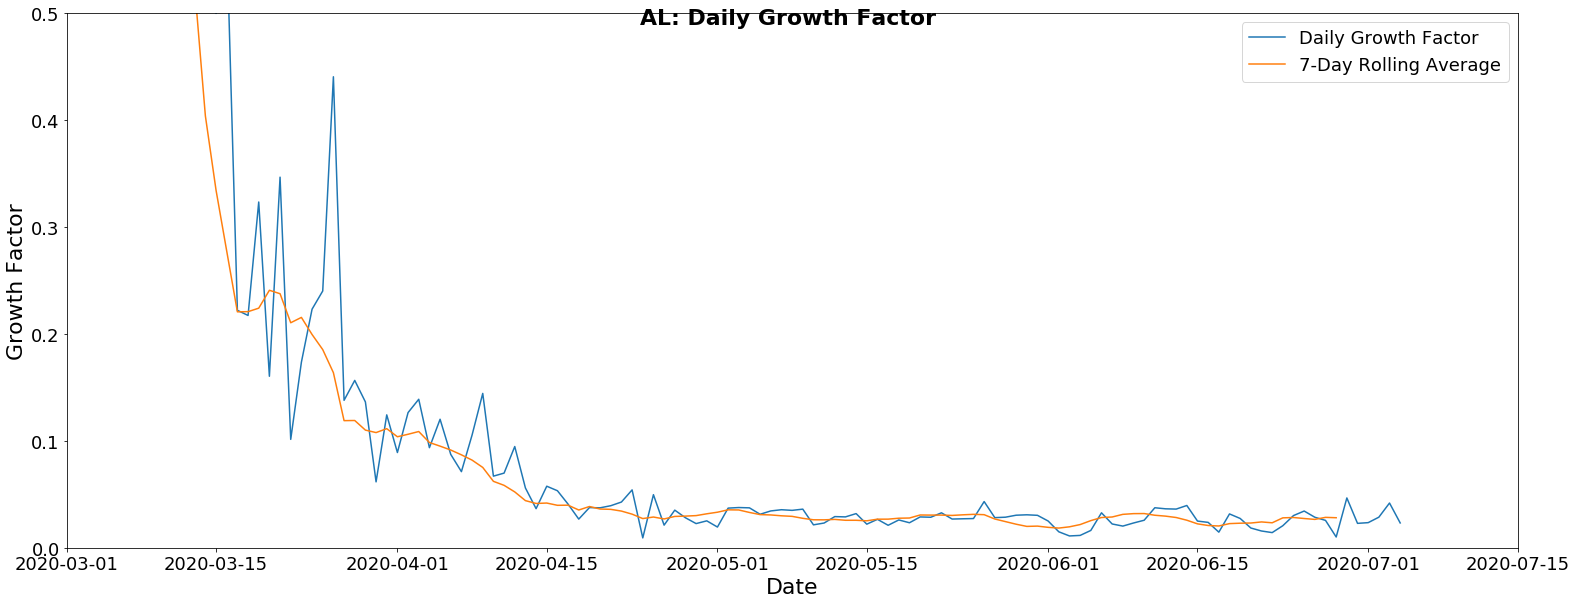

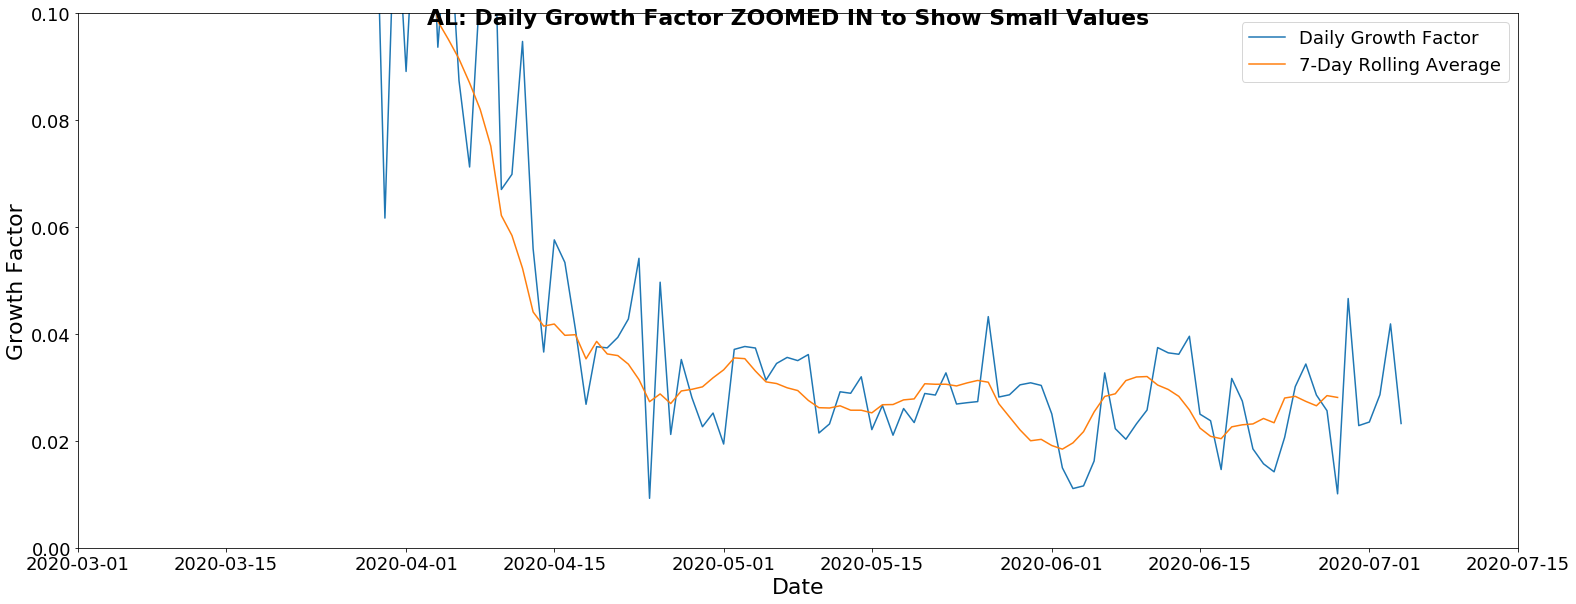












AR


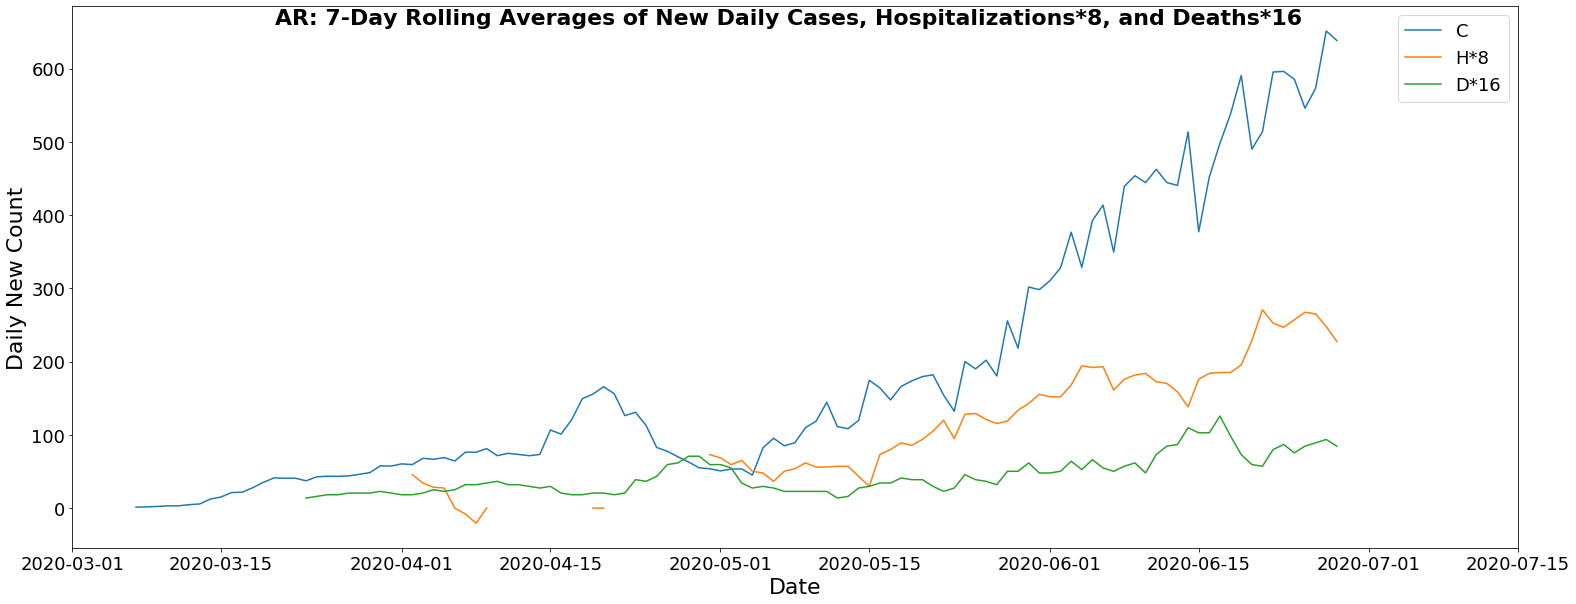

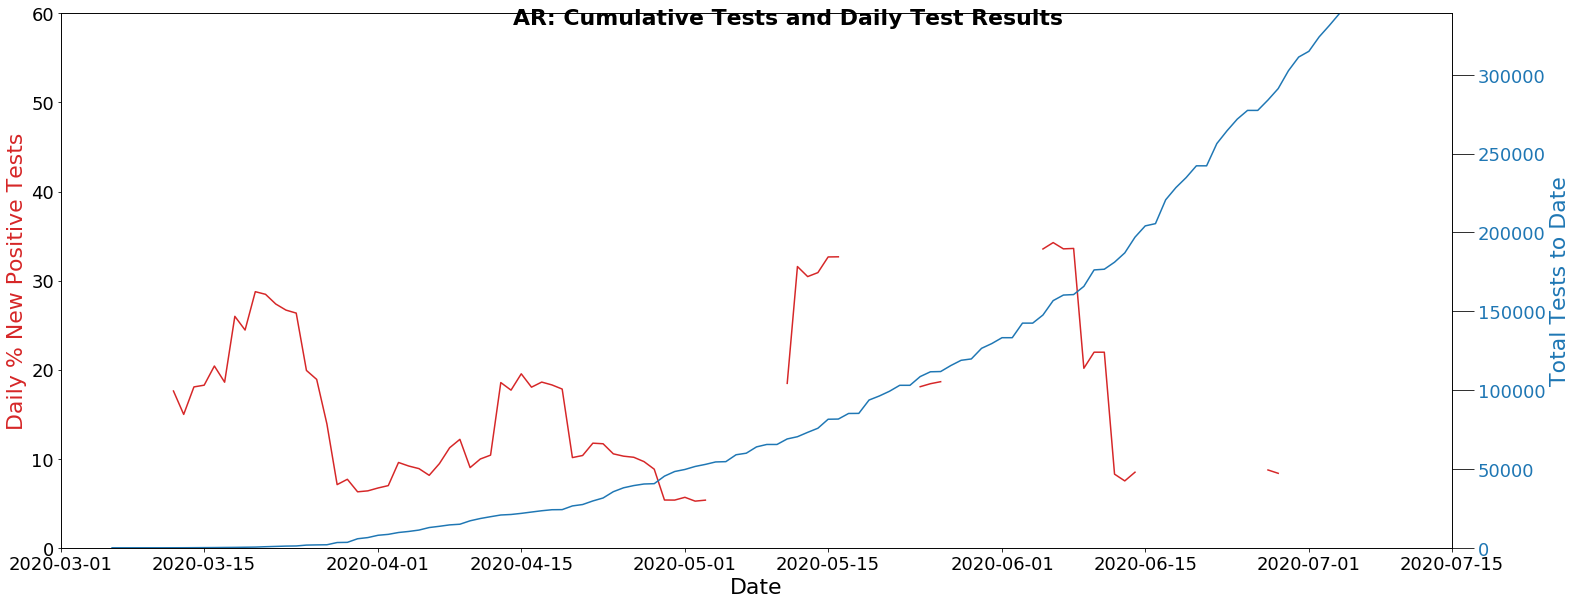

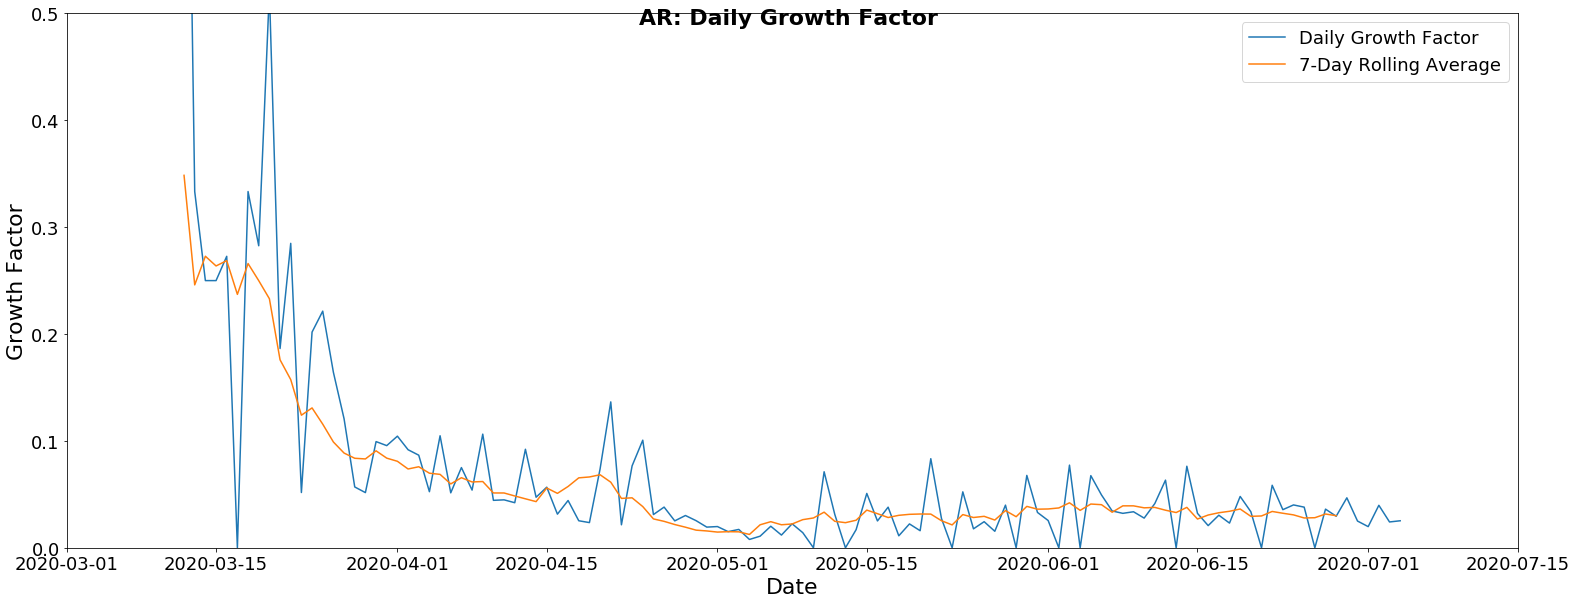

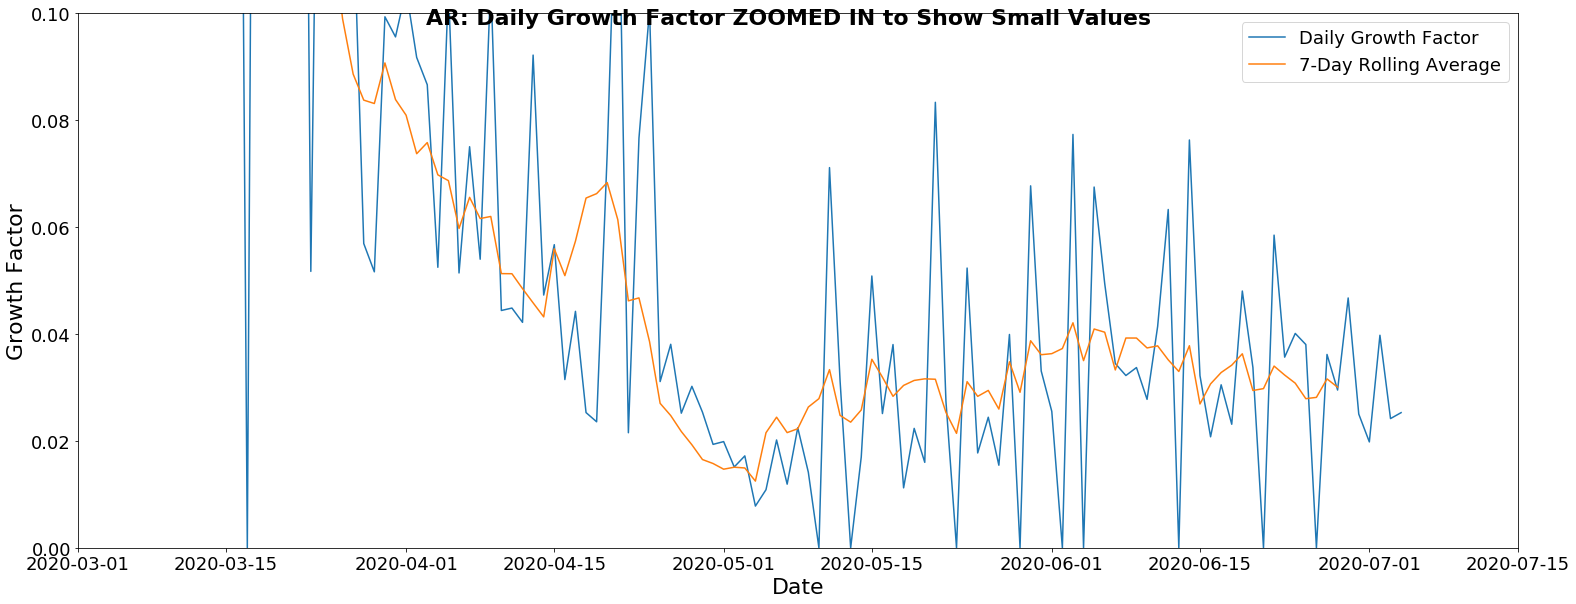












AS


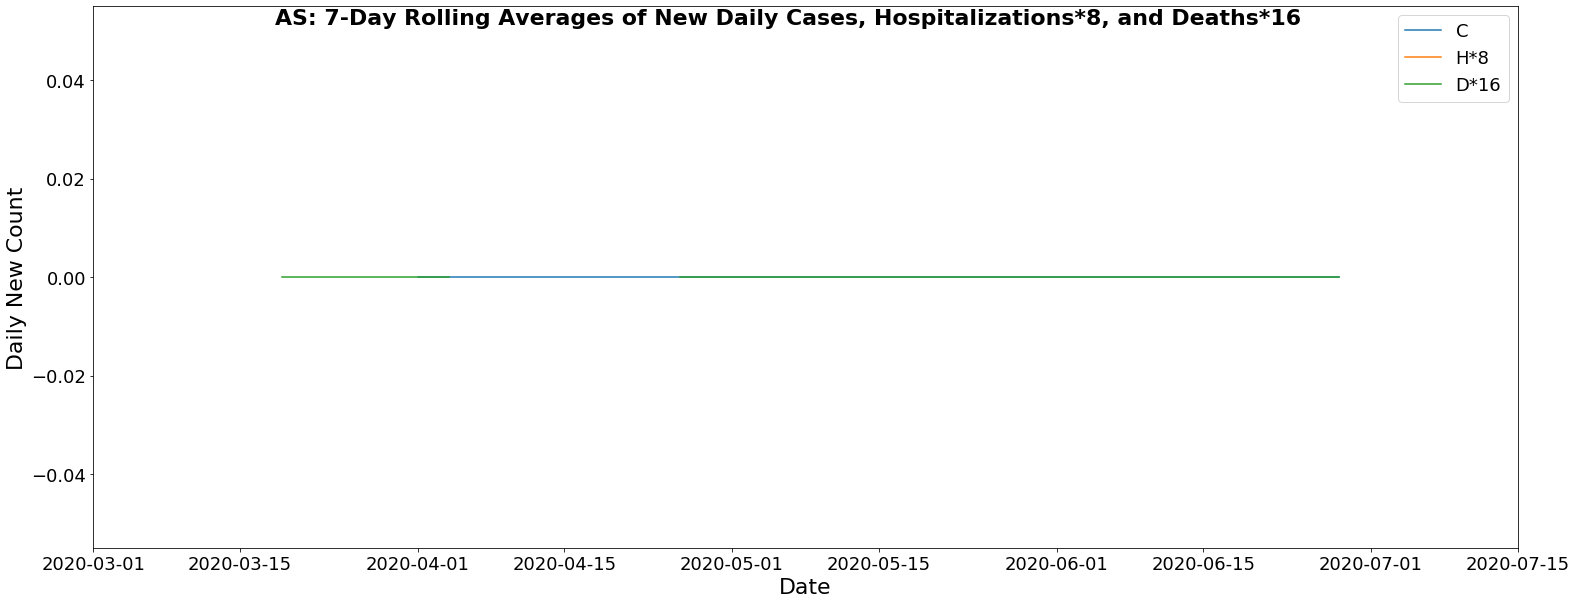

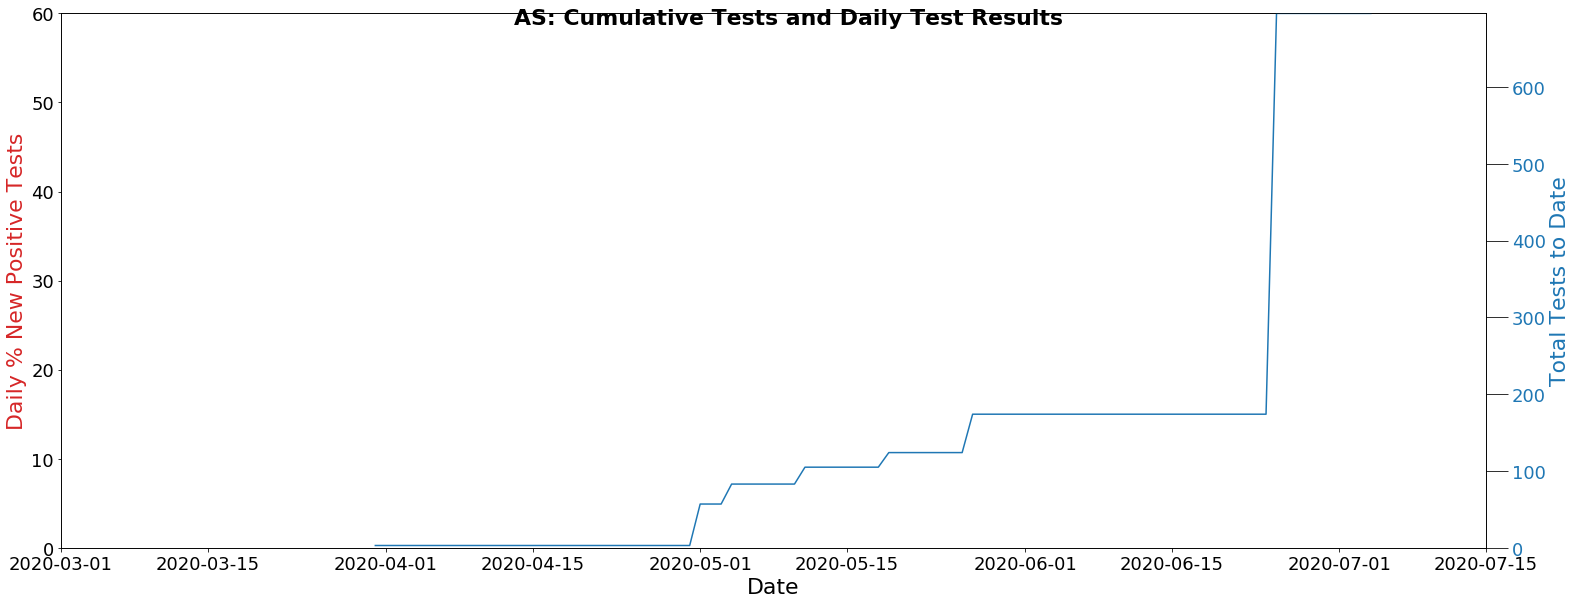

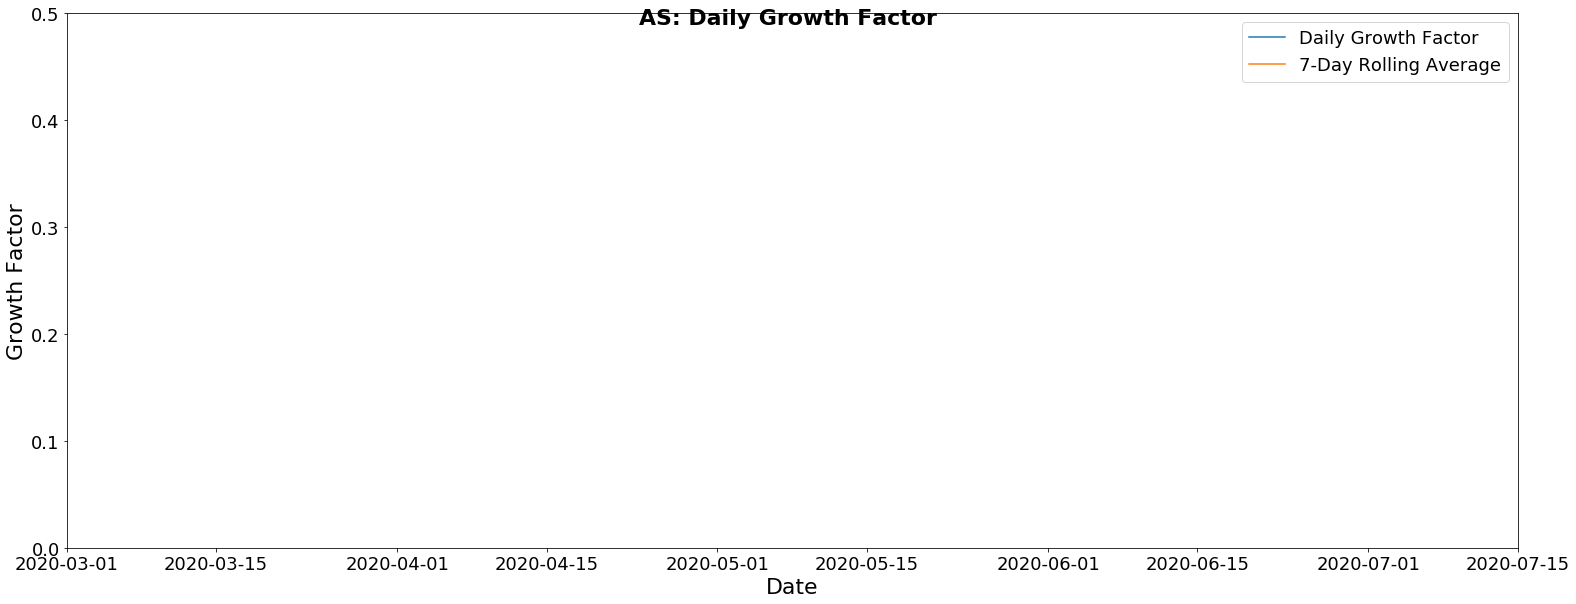

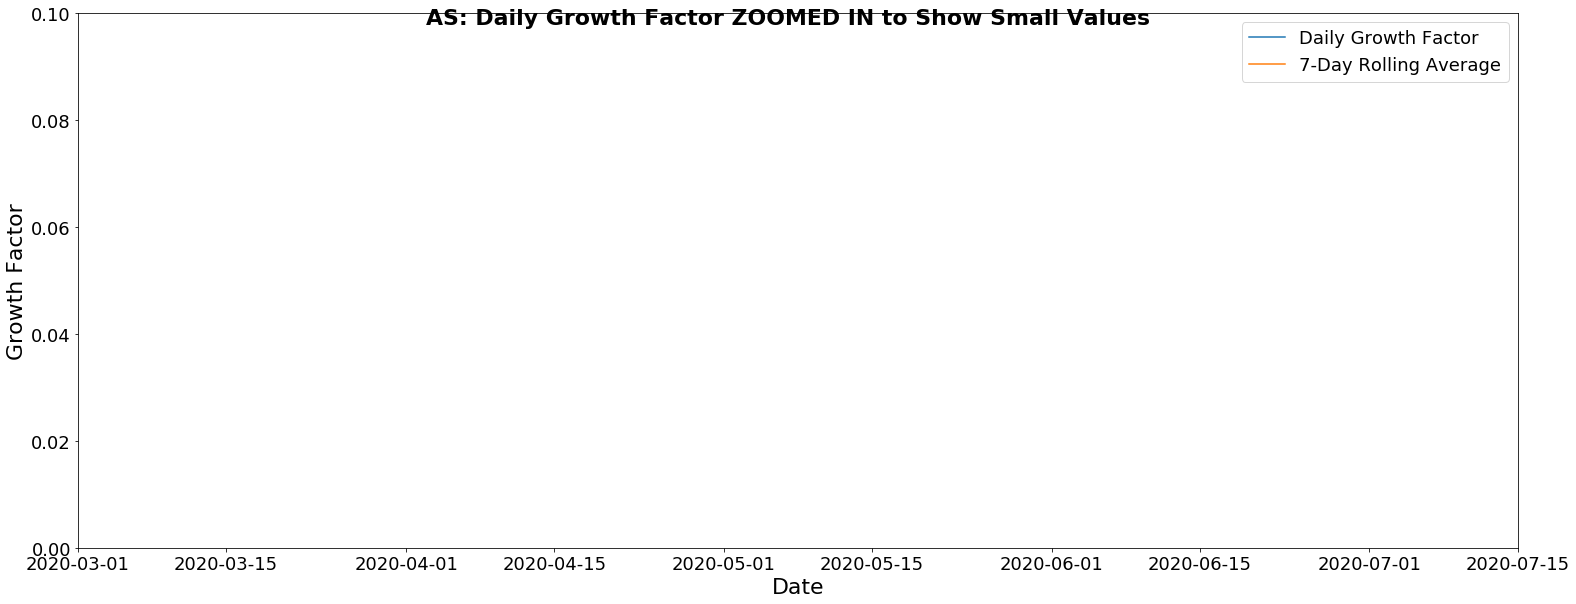












AZ


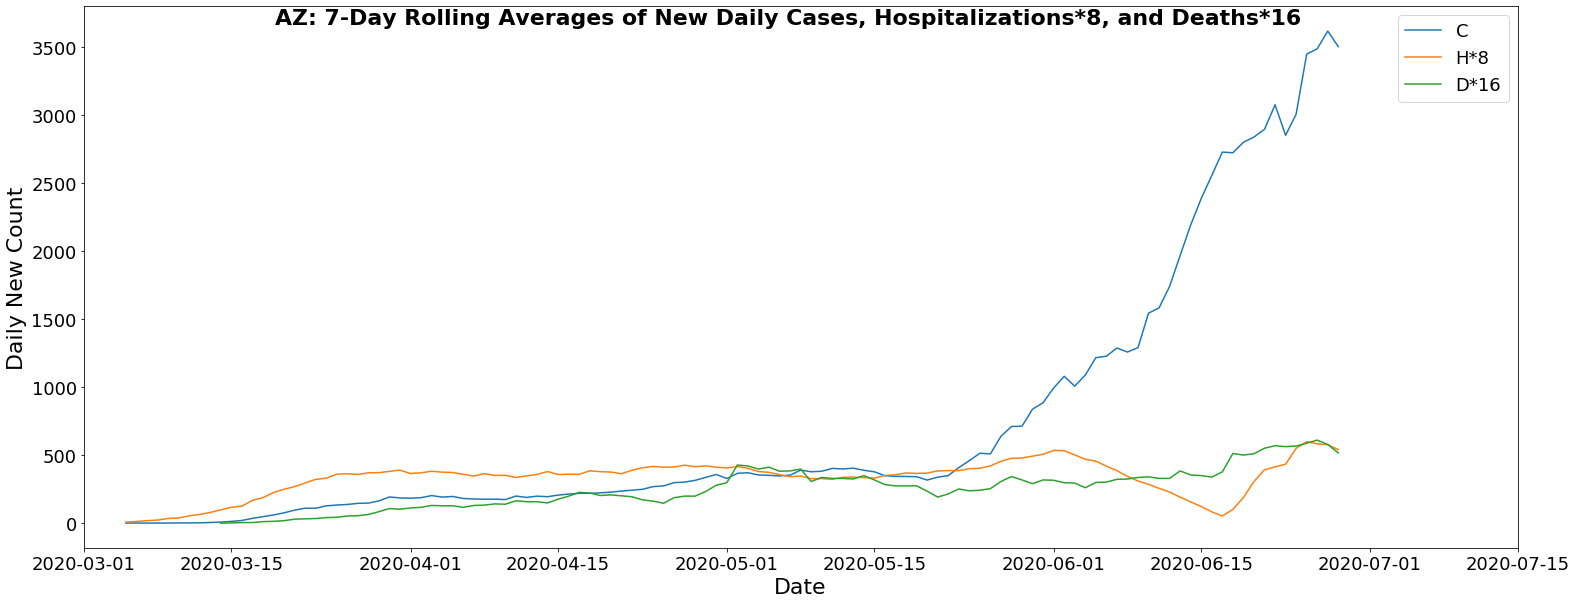

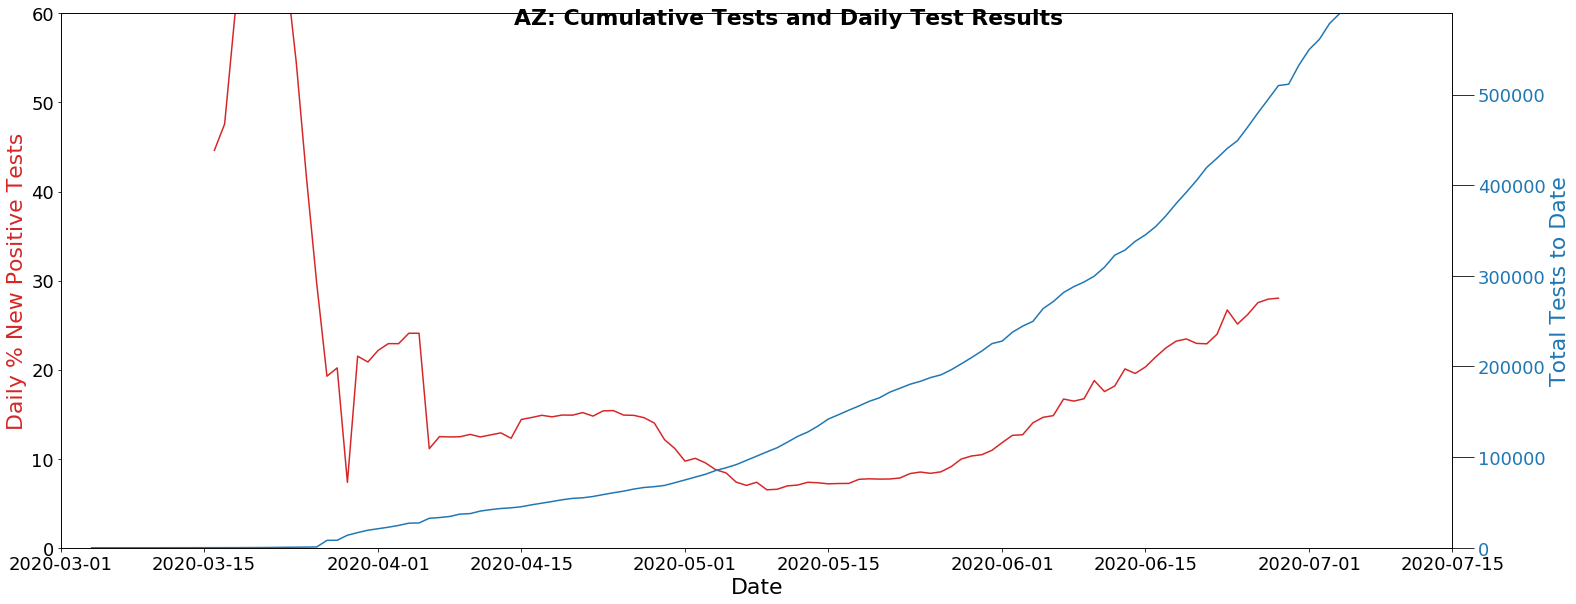

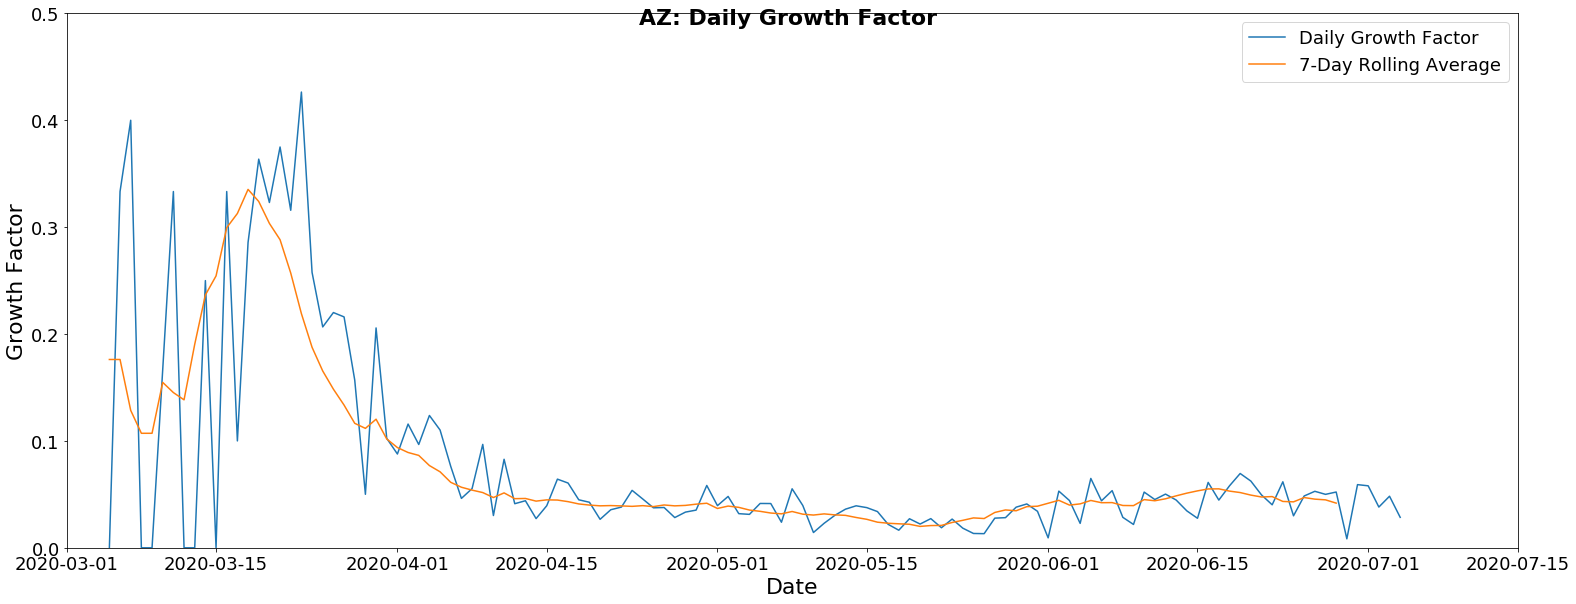

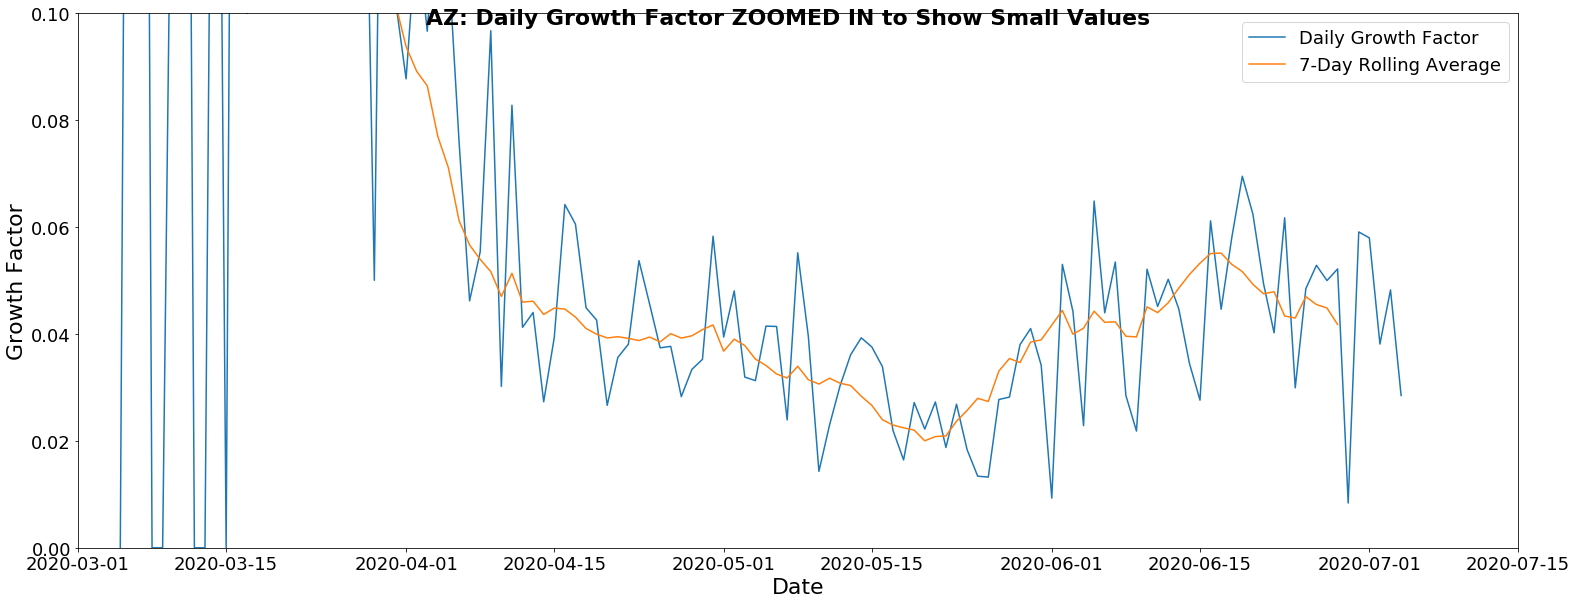












CA


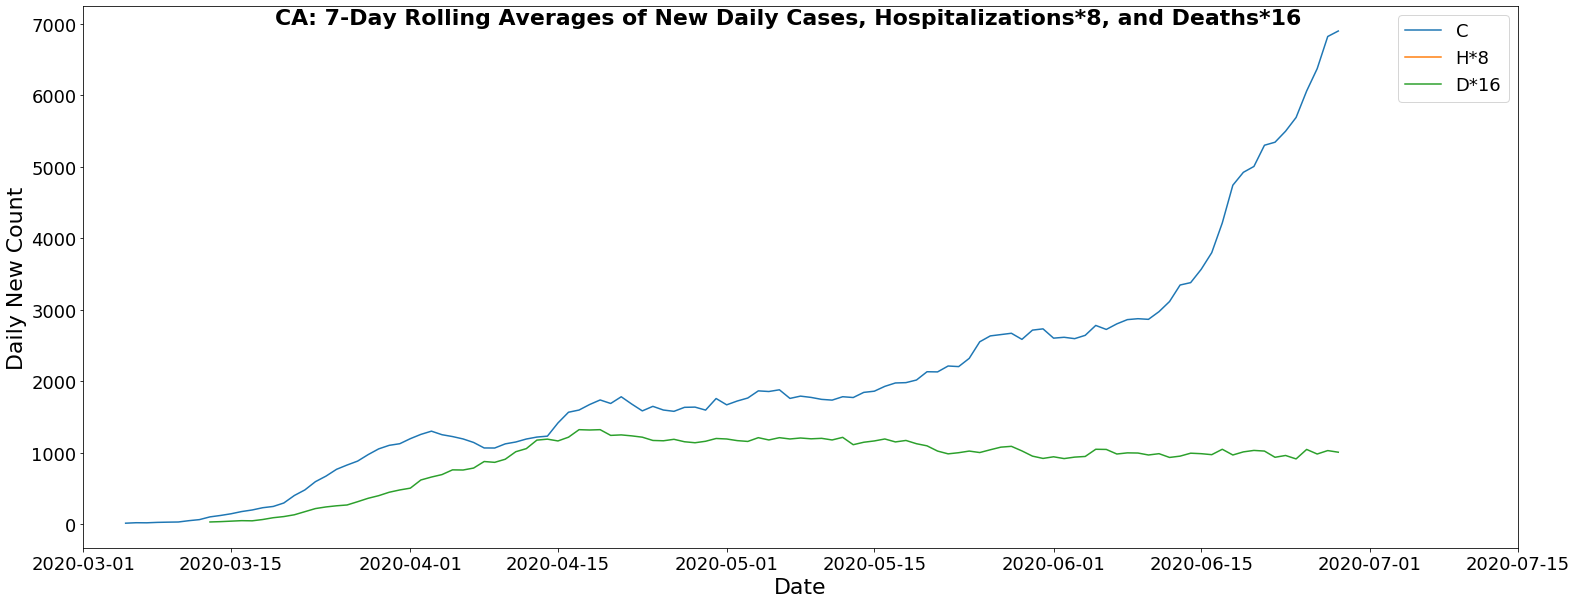

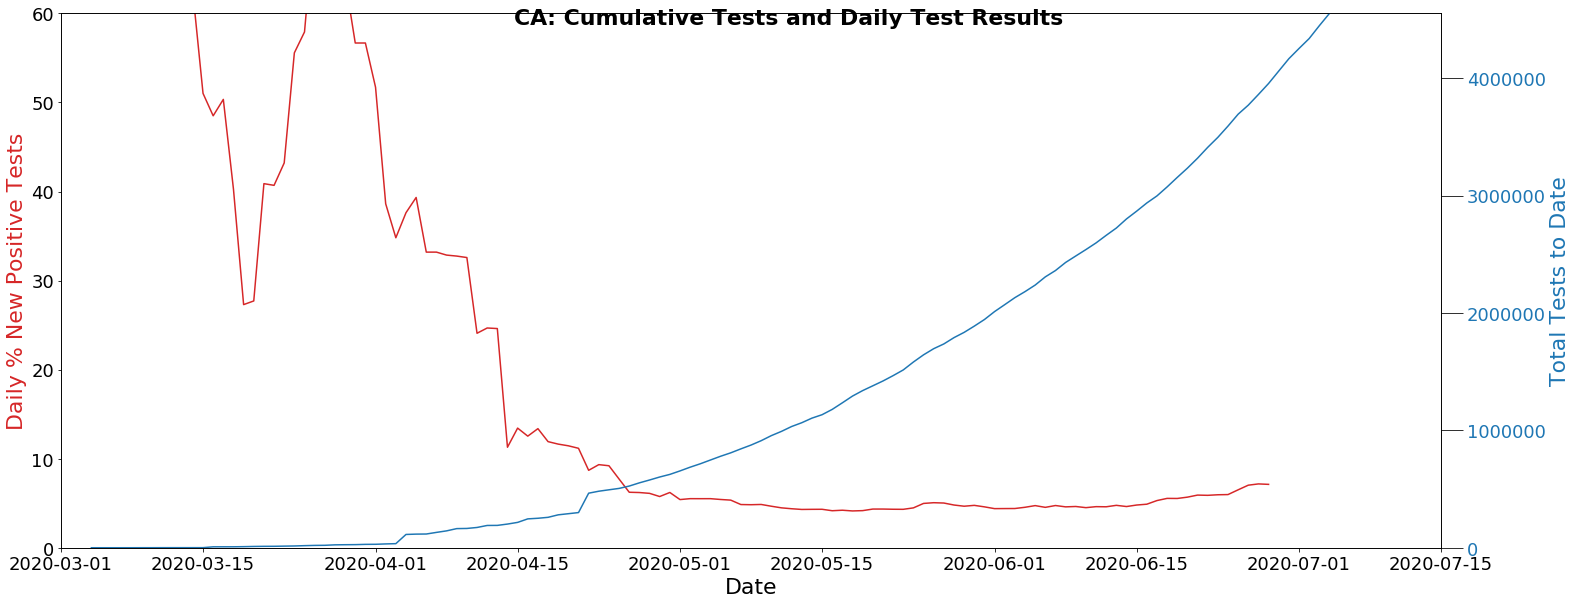

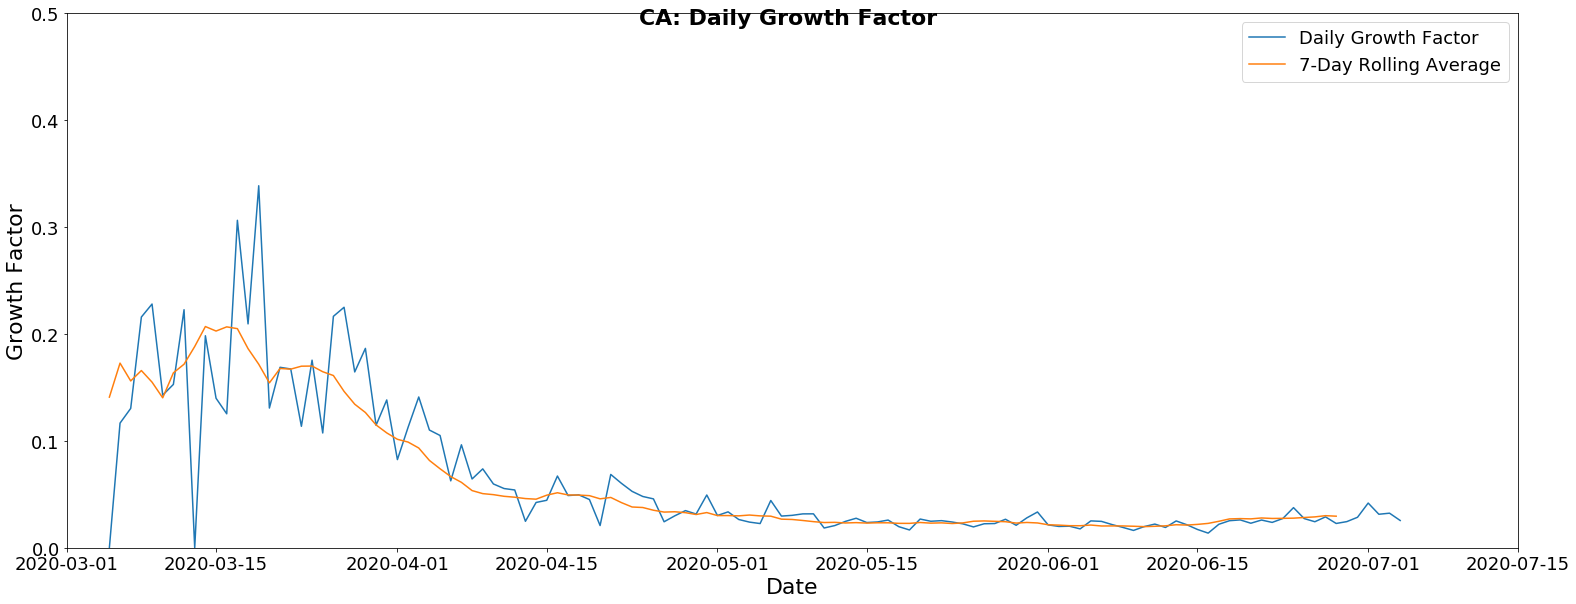

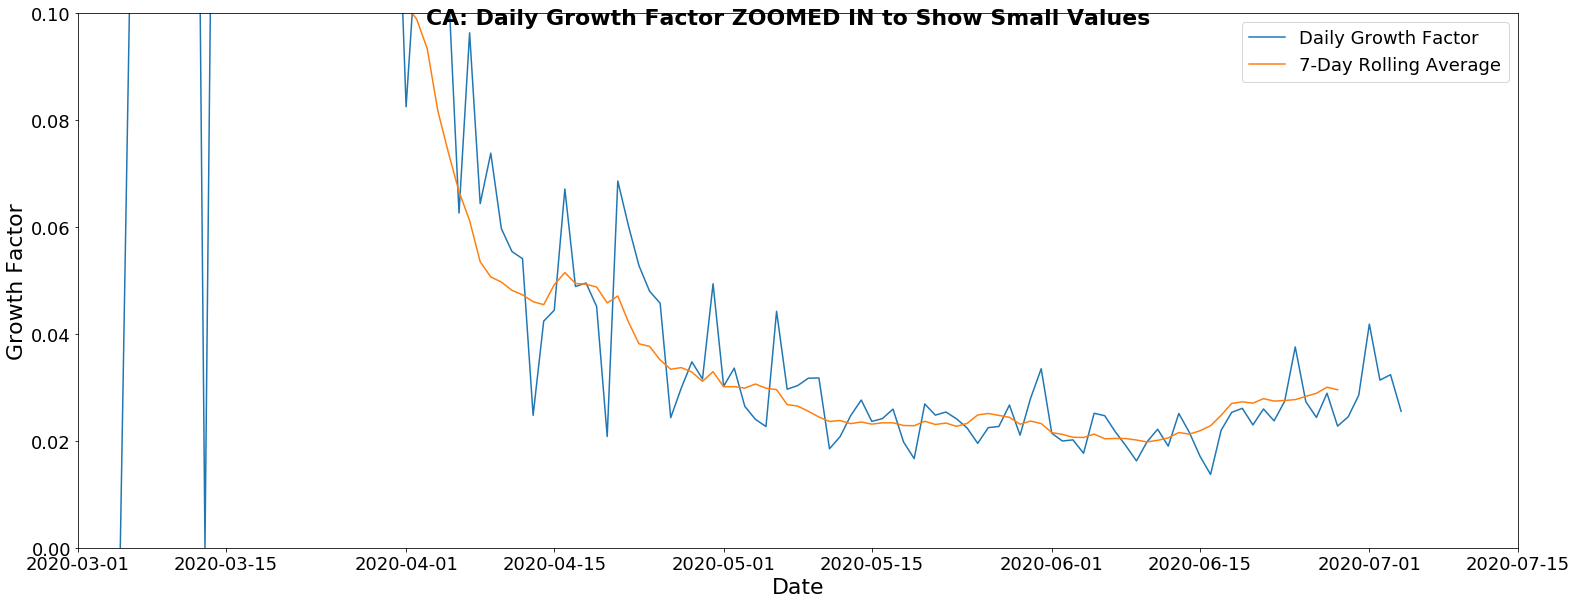












CO


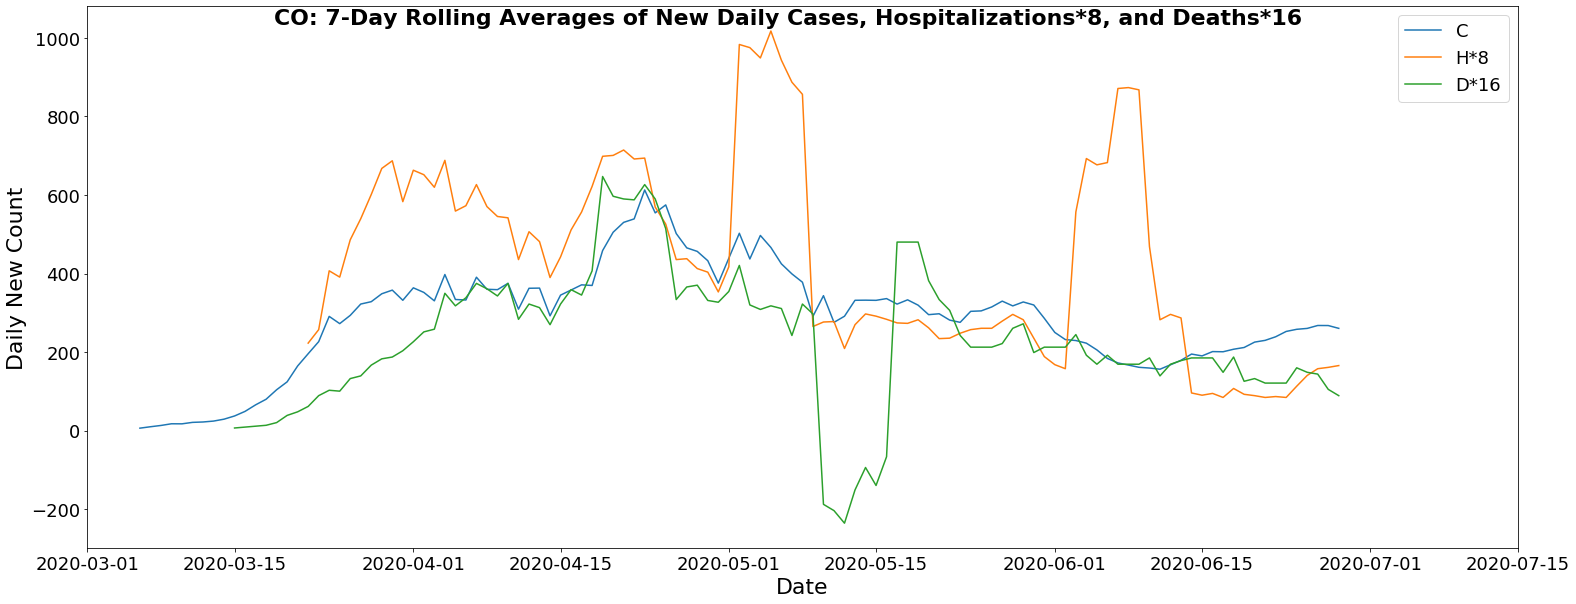

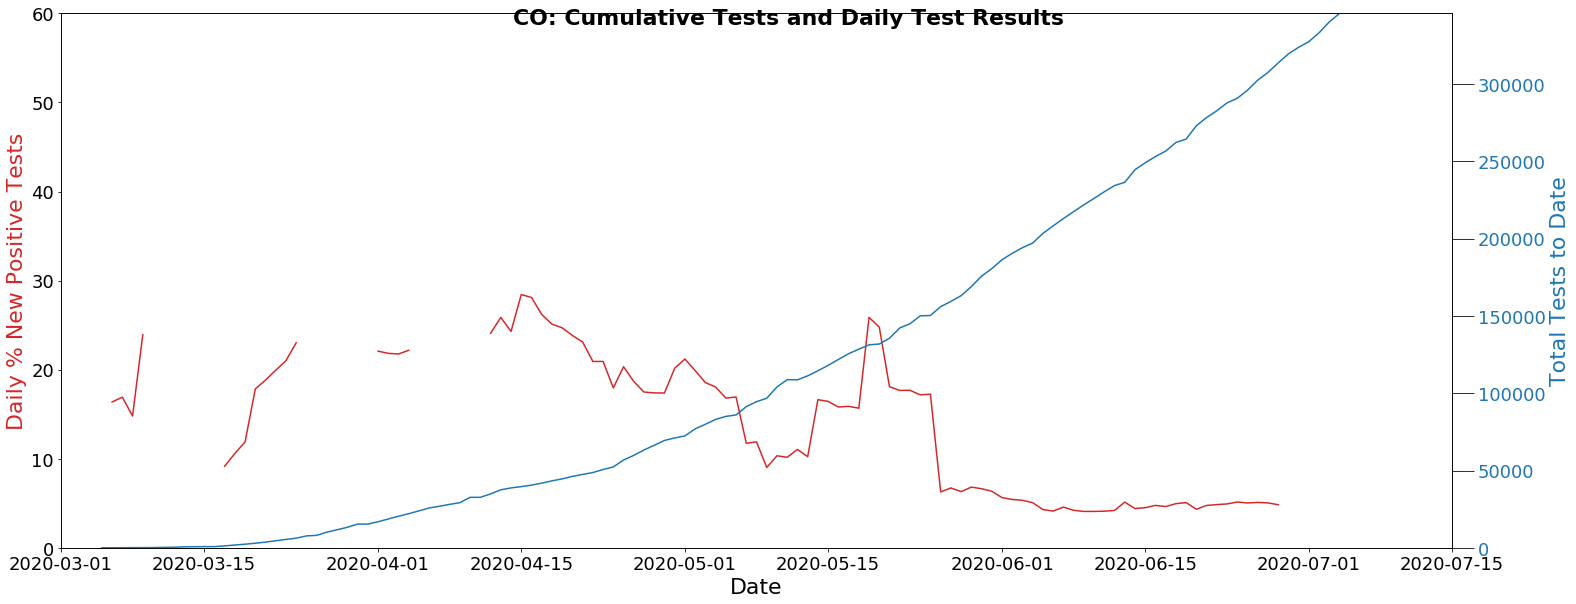

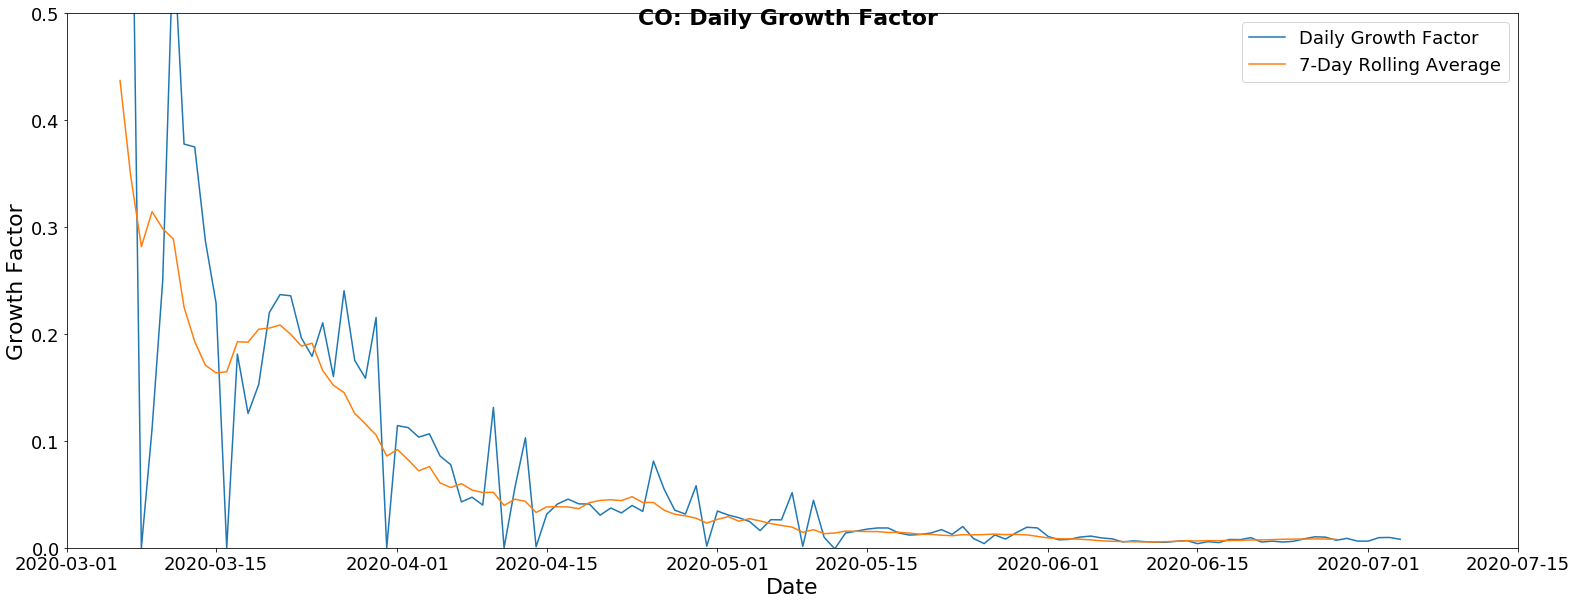

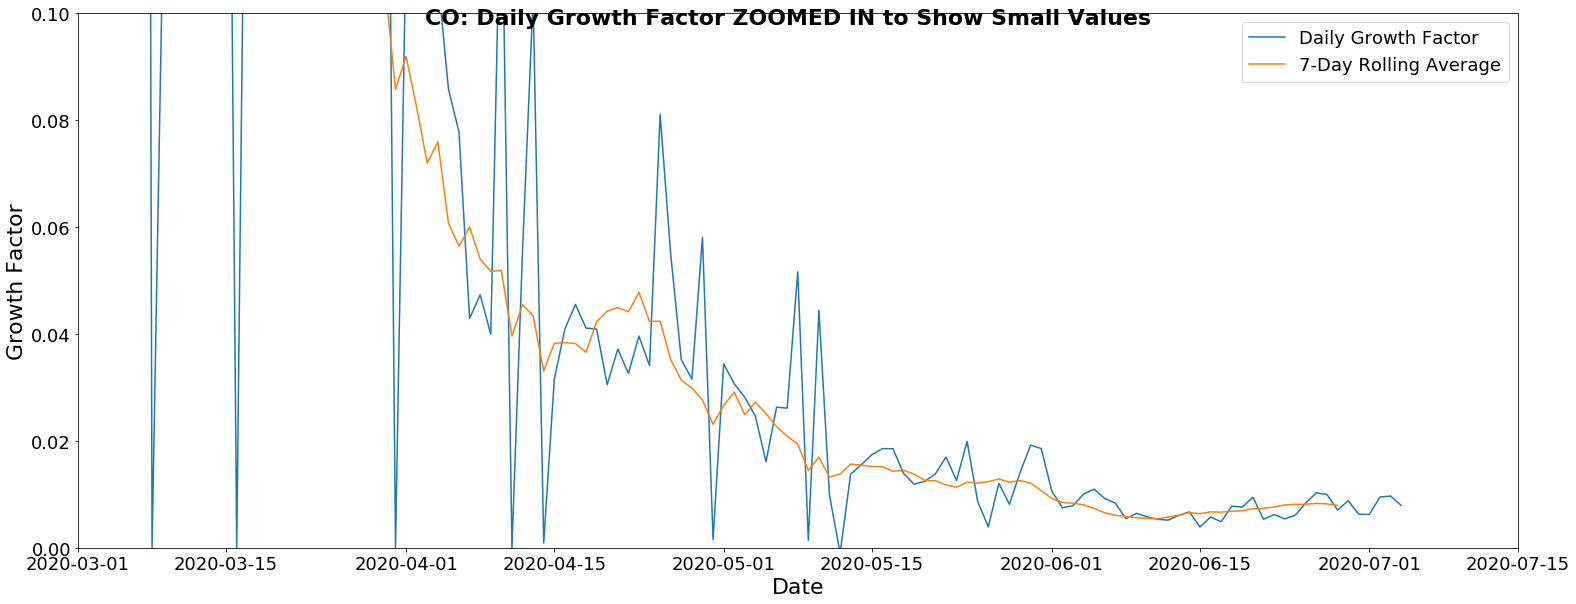












CT


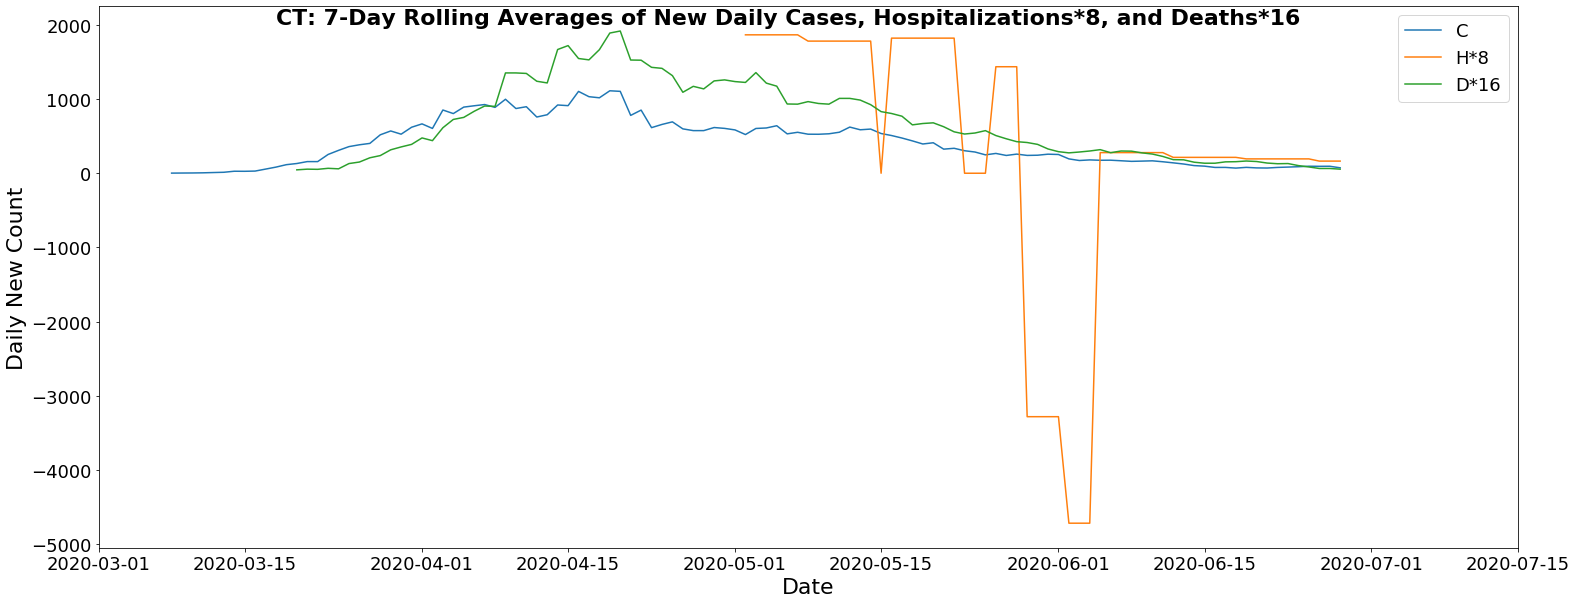

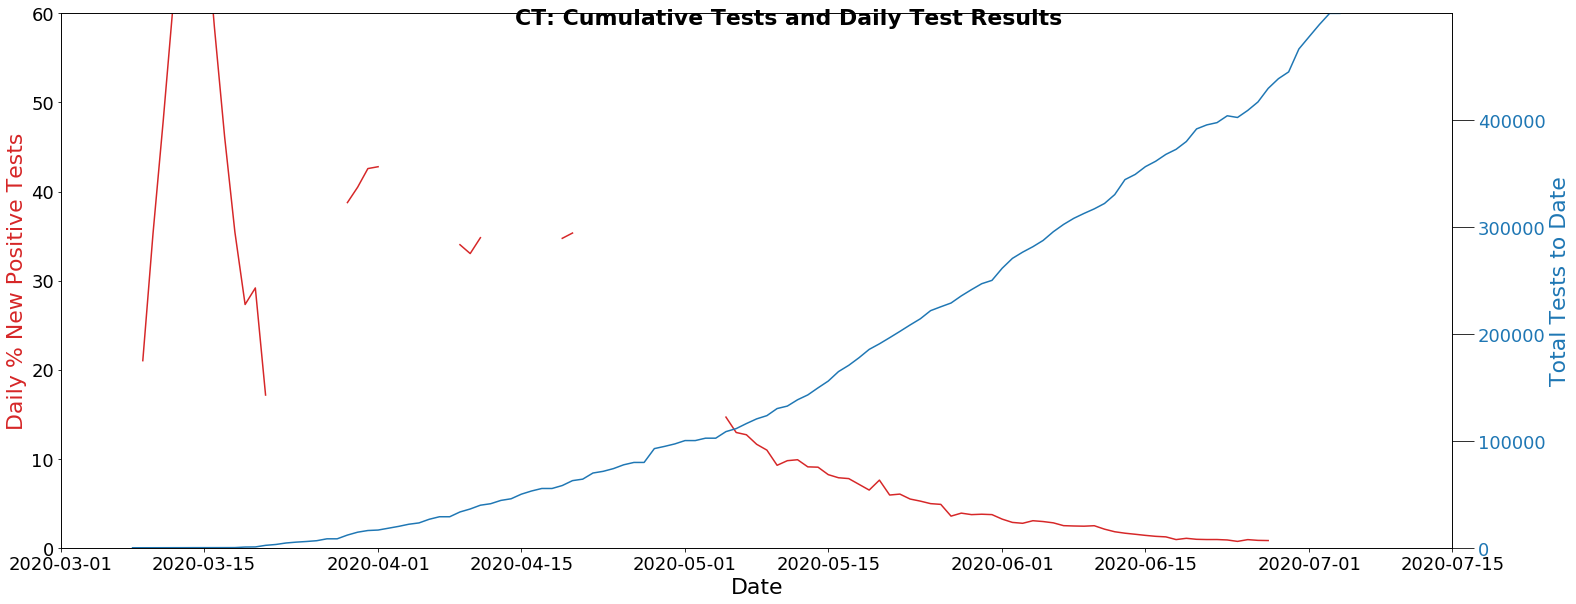

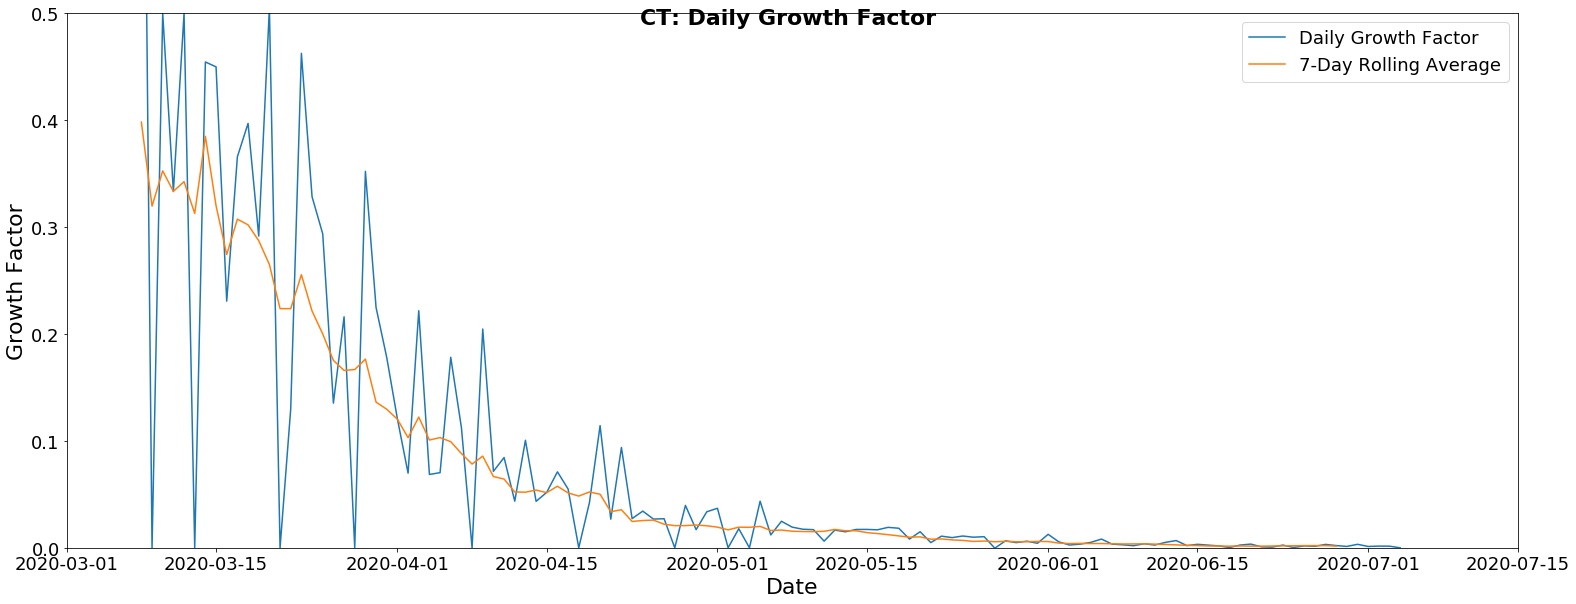

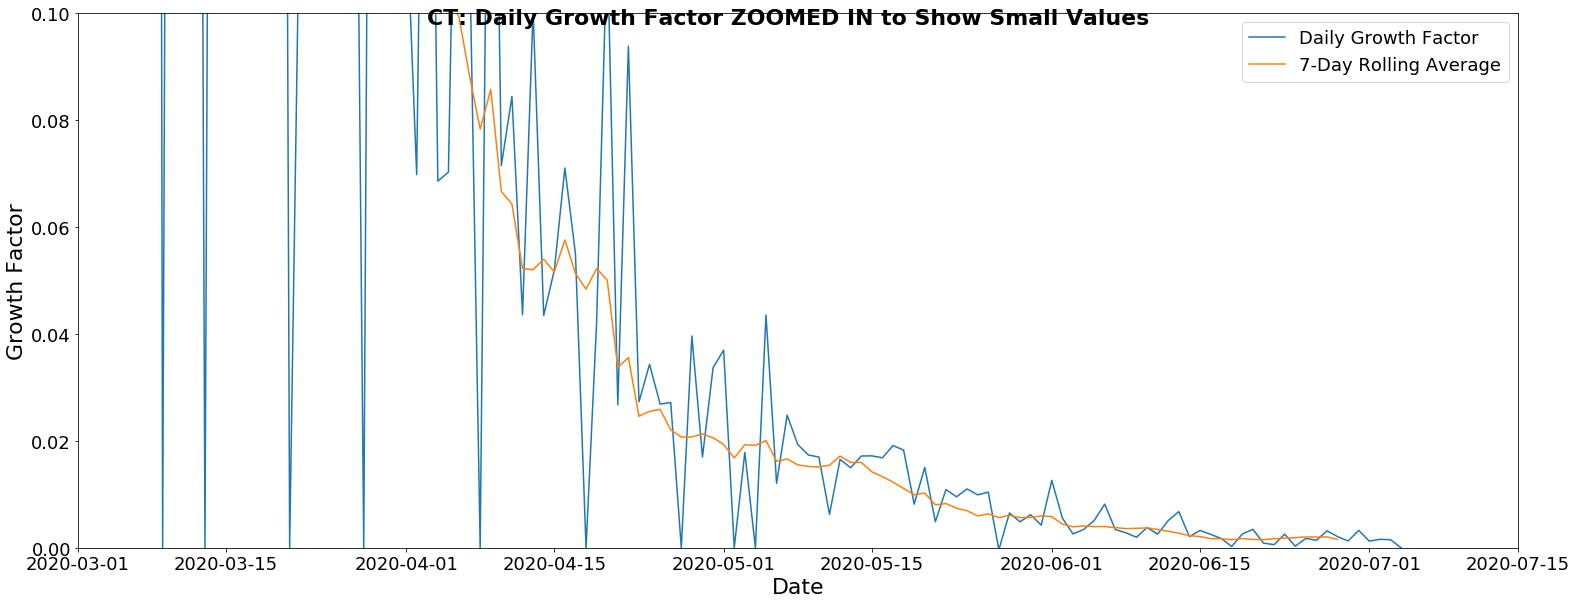












DC


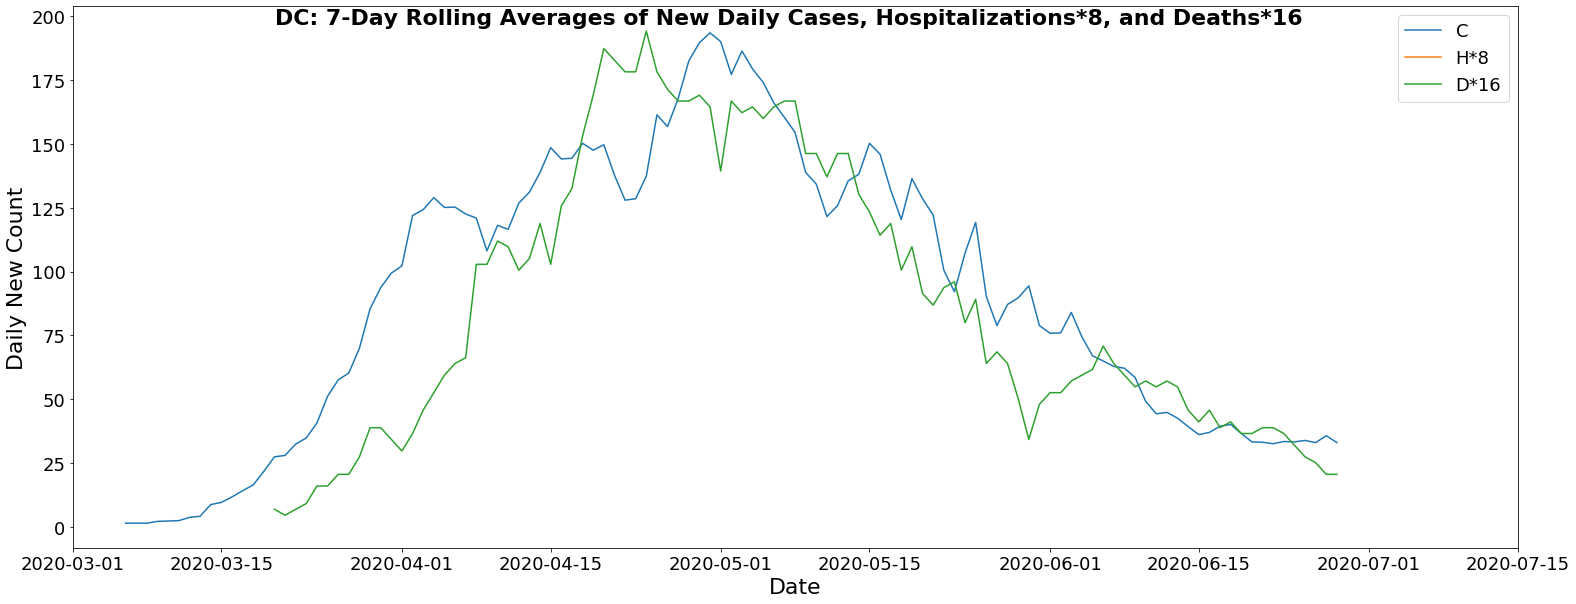

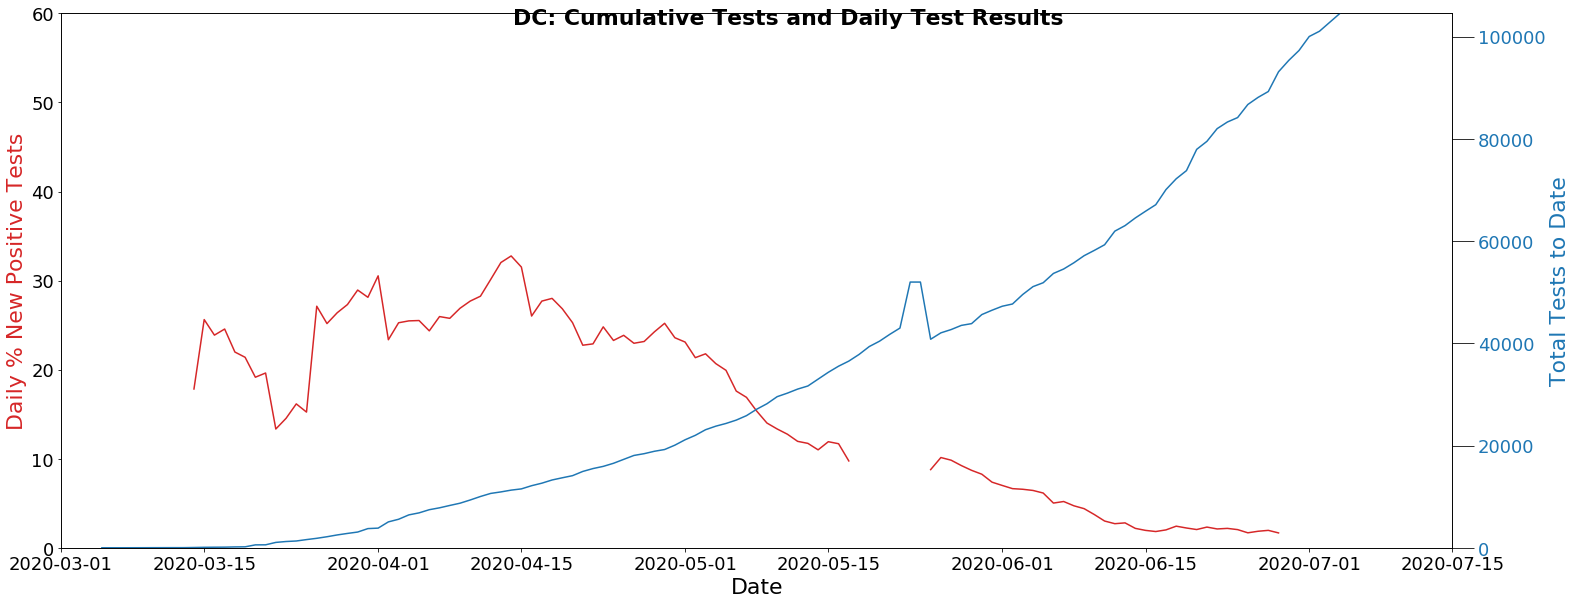

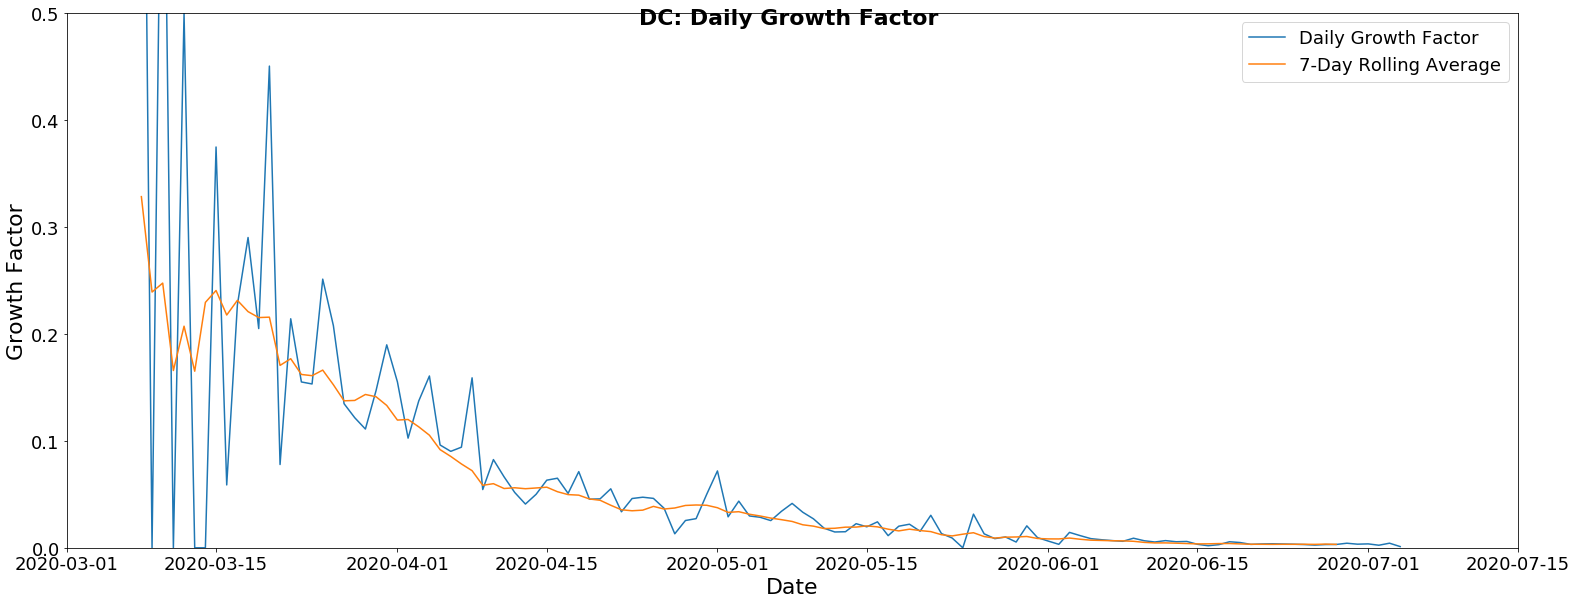

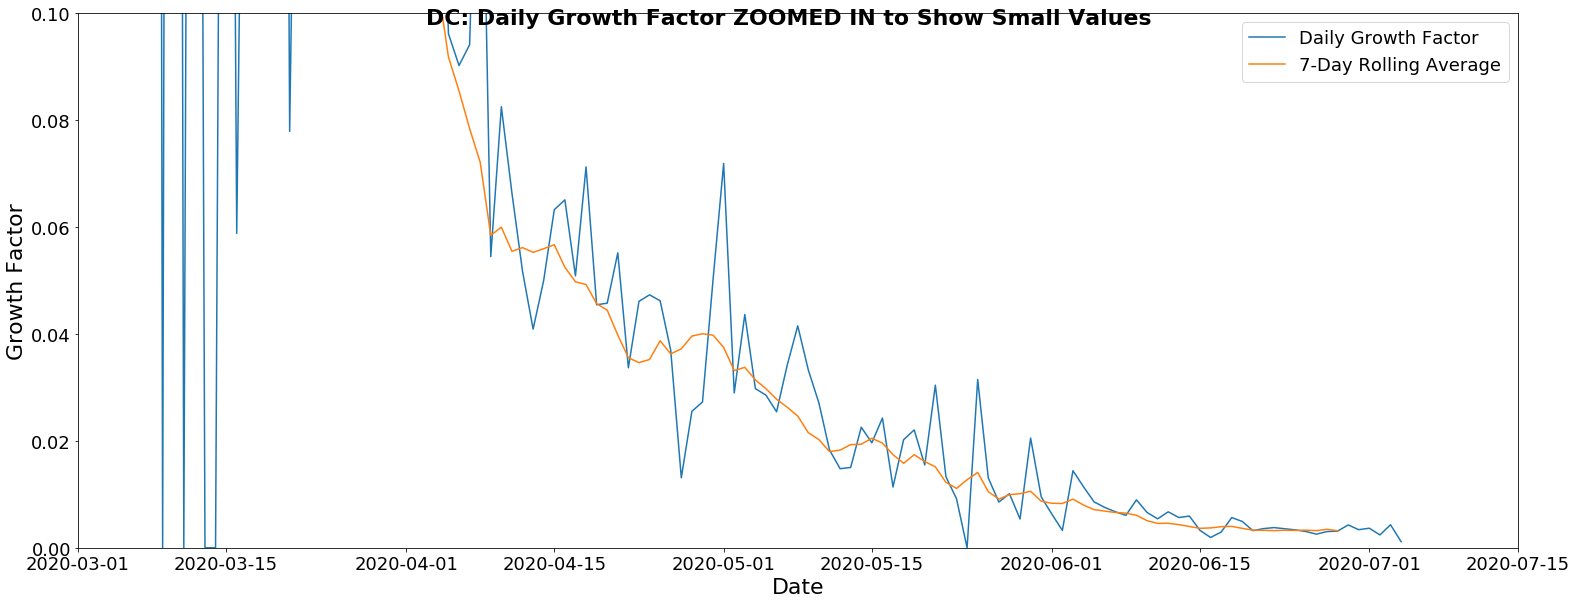












DE


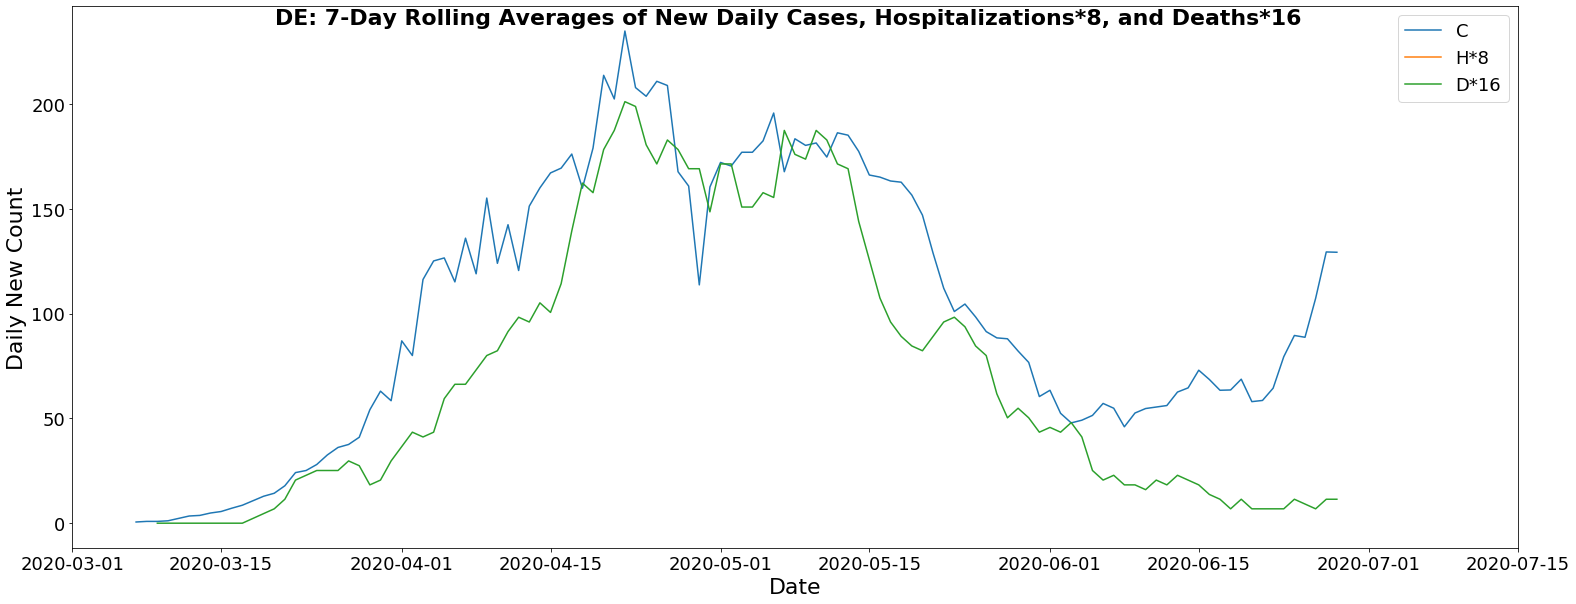

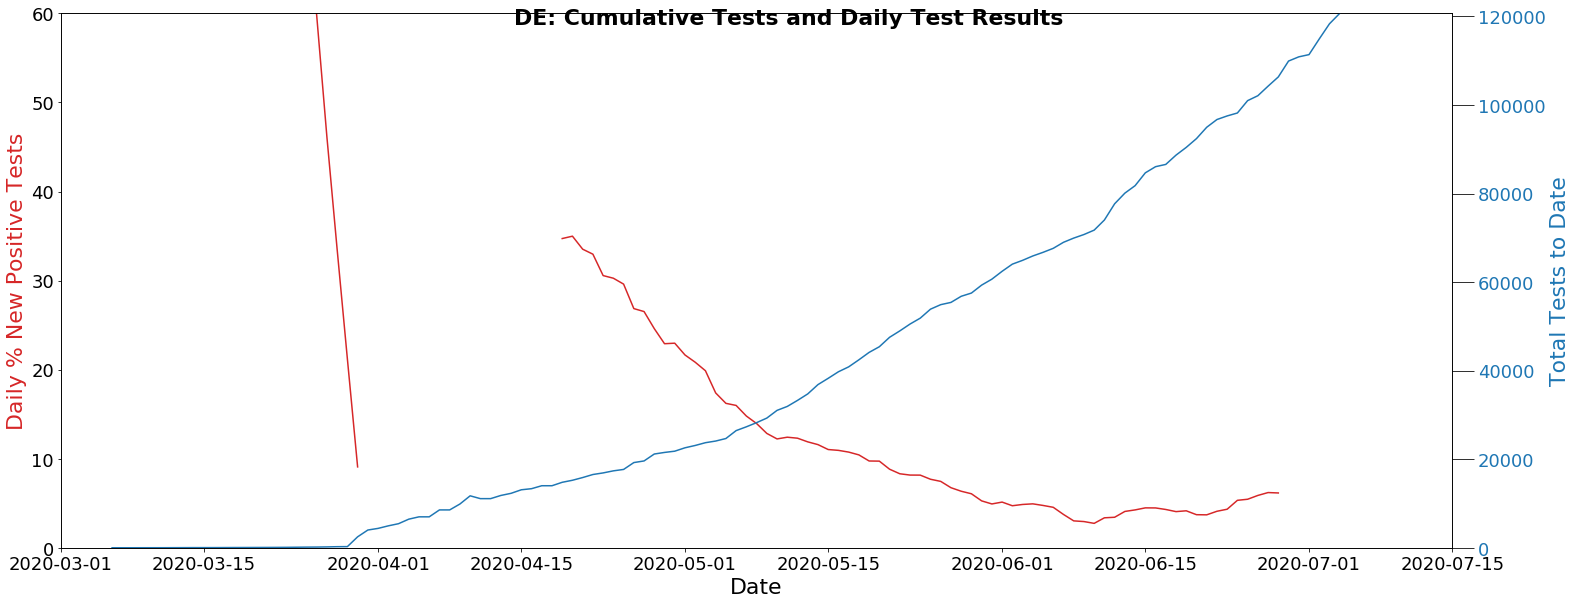

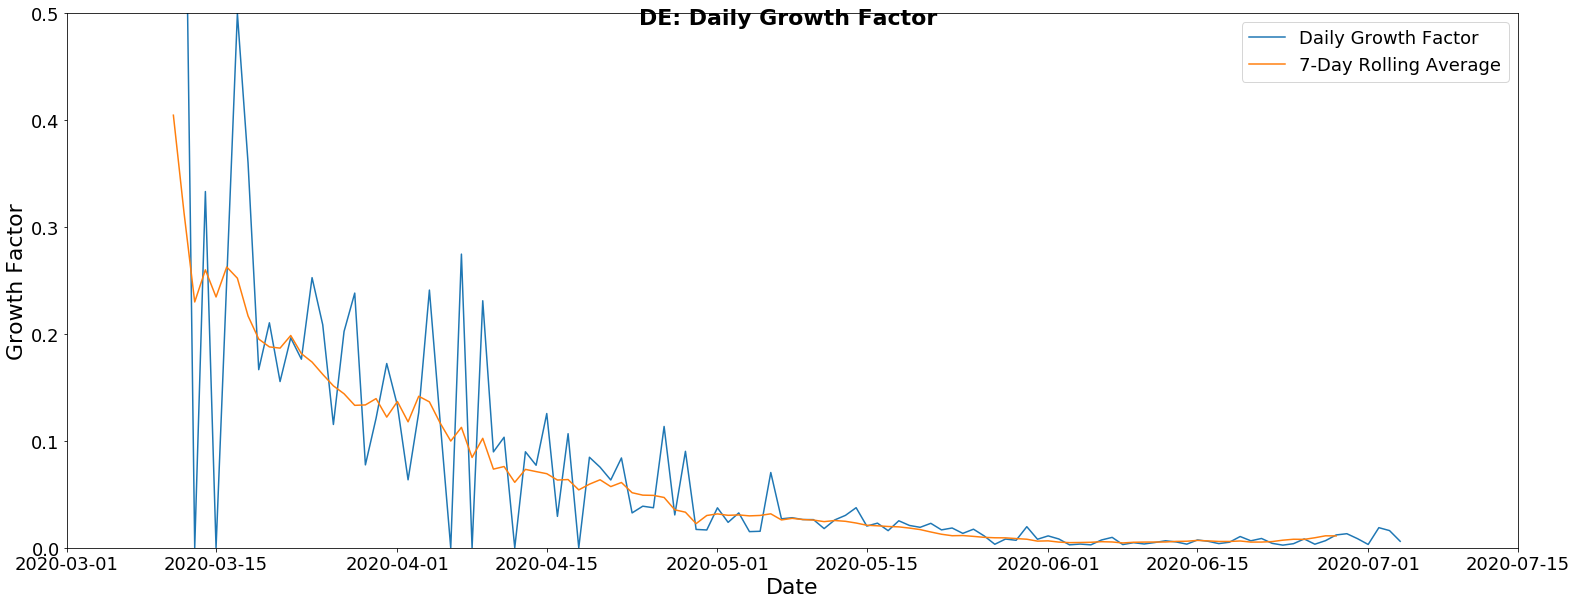

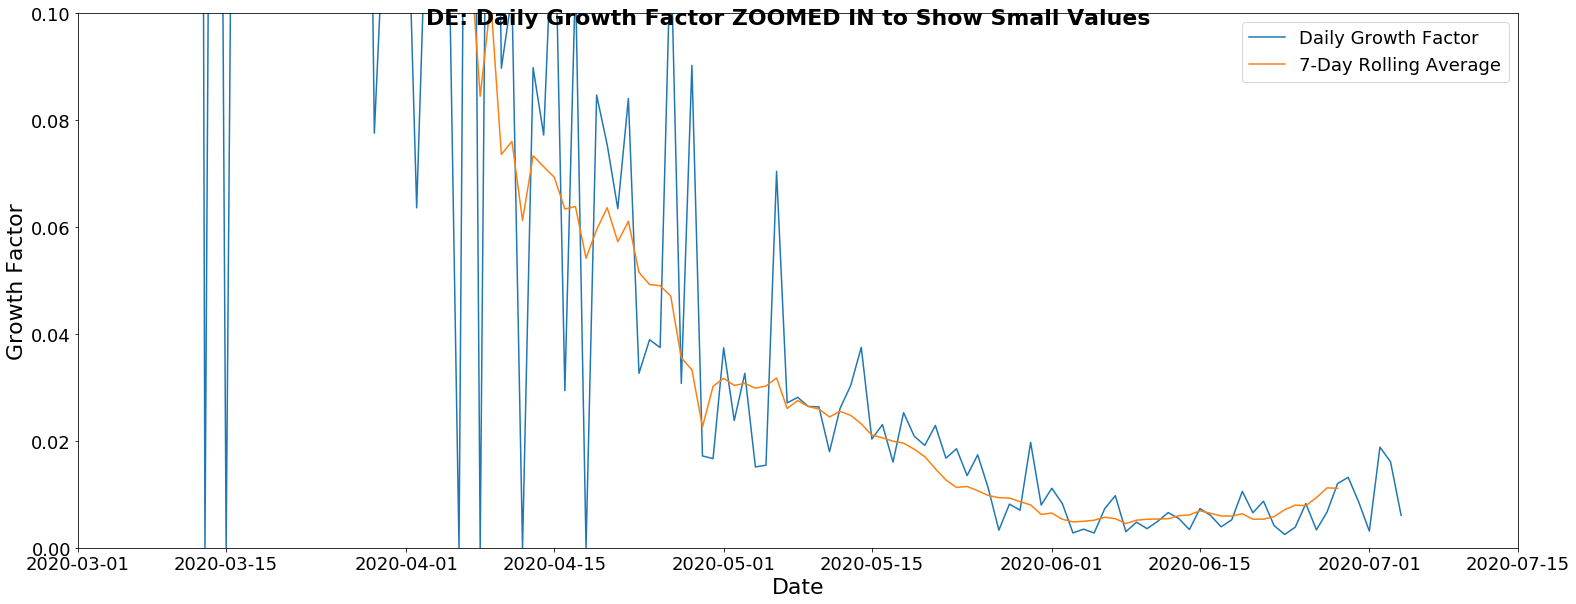












FL


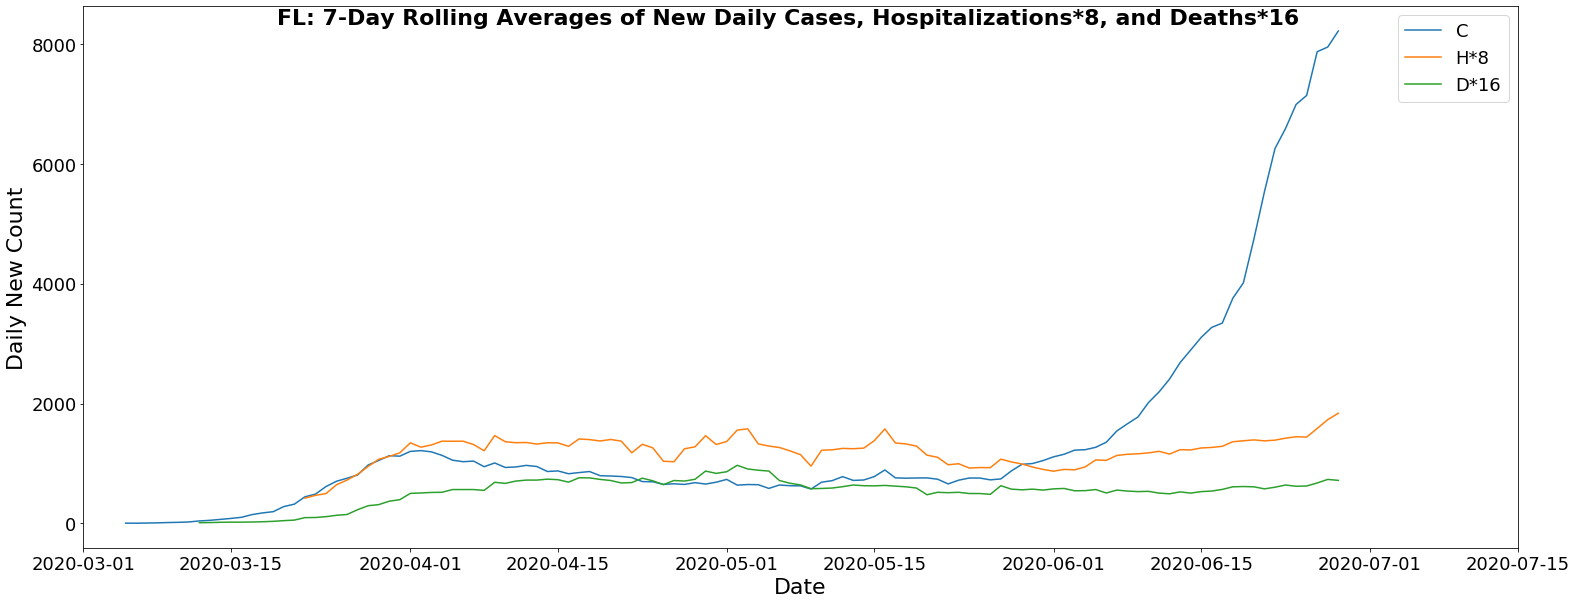

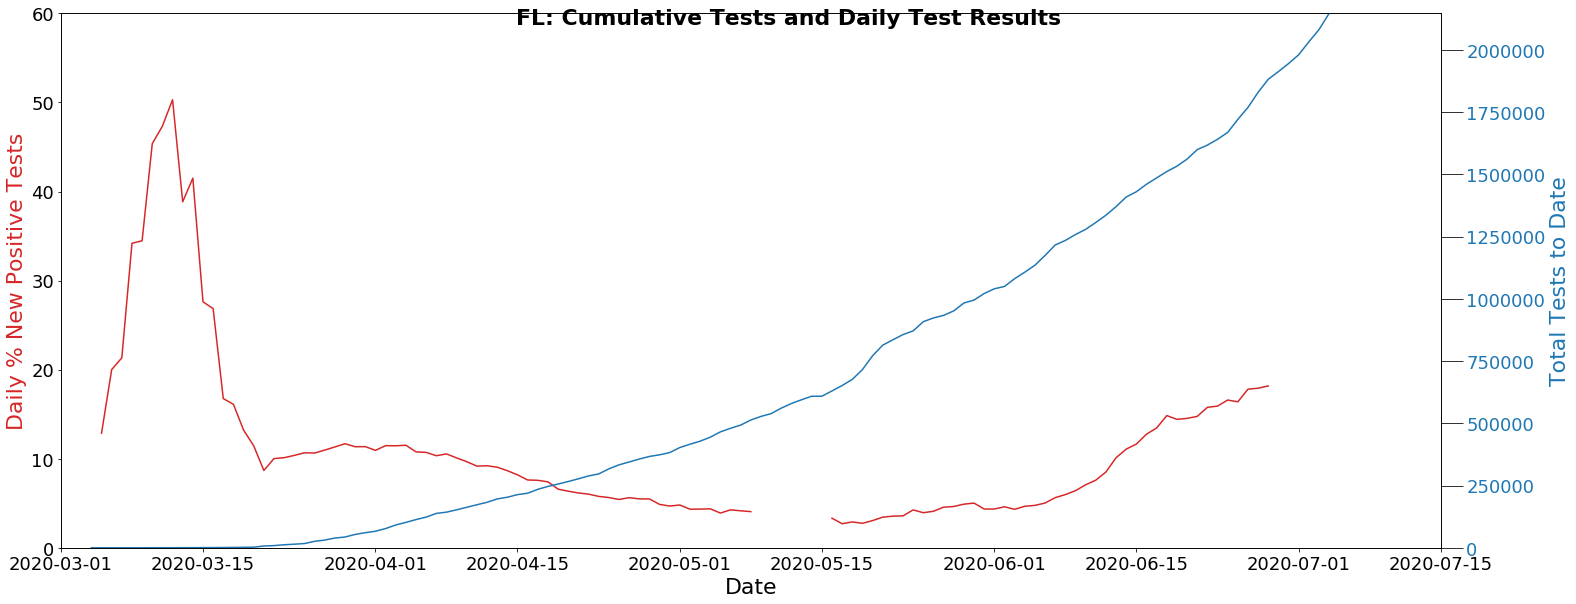

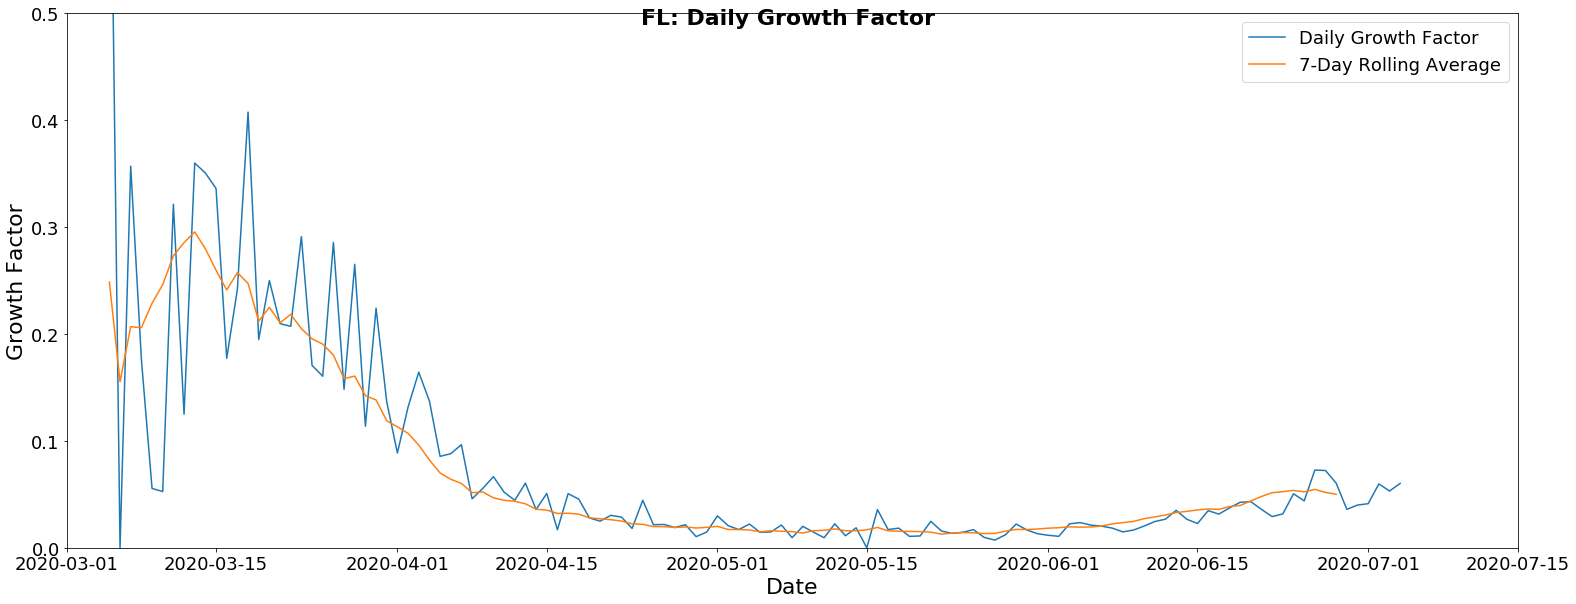

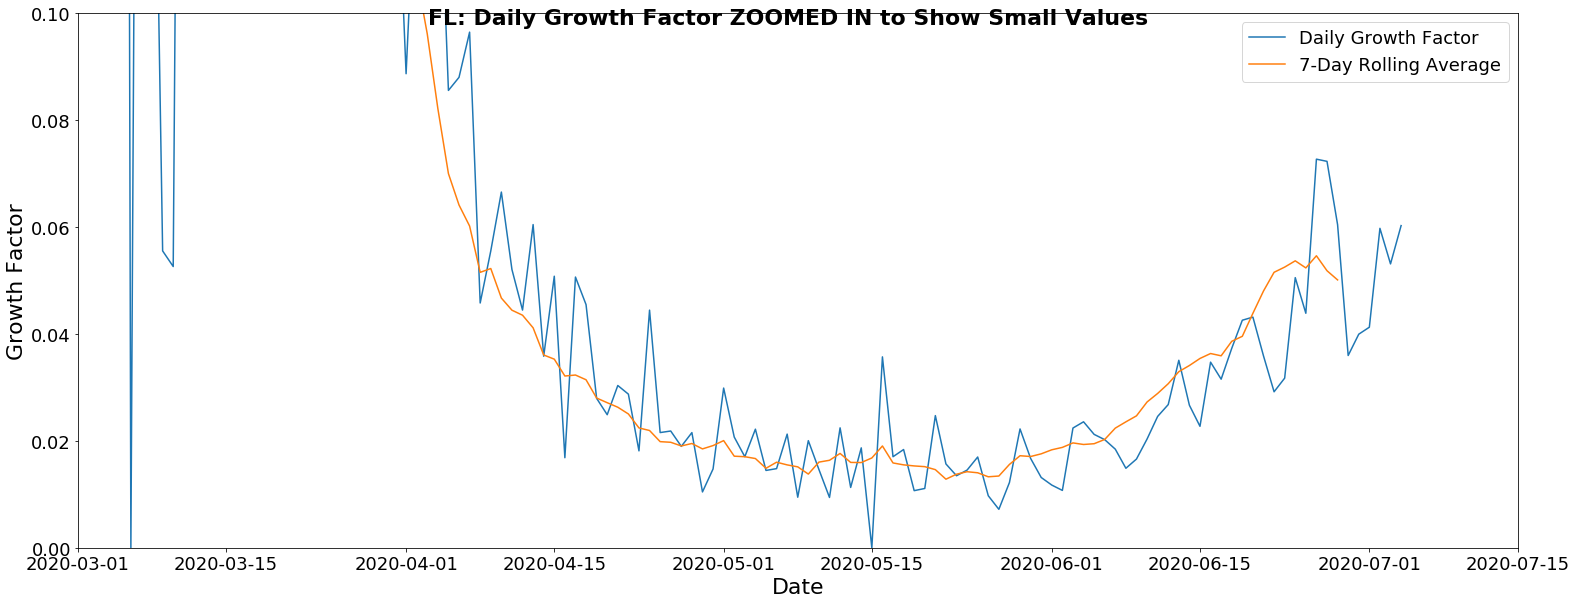












GA


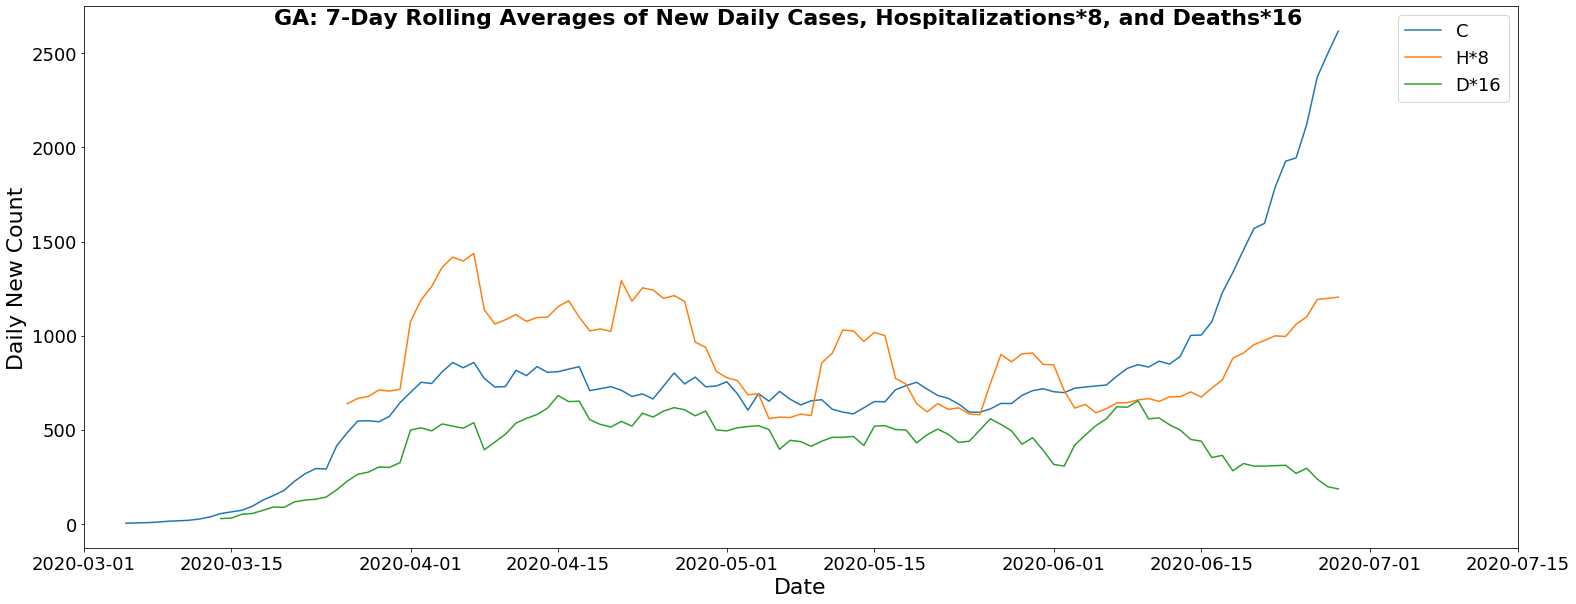

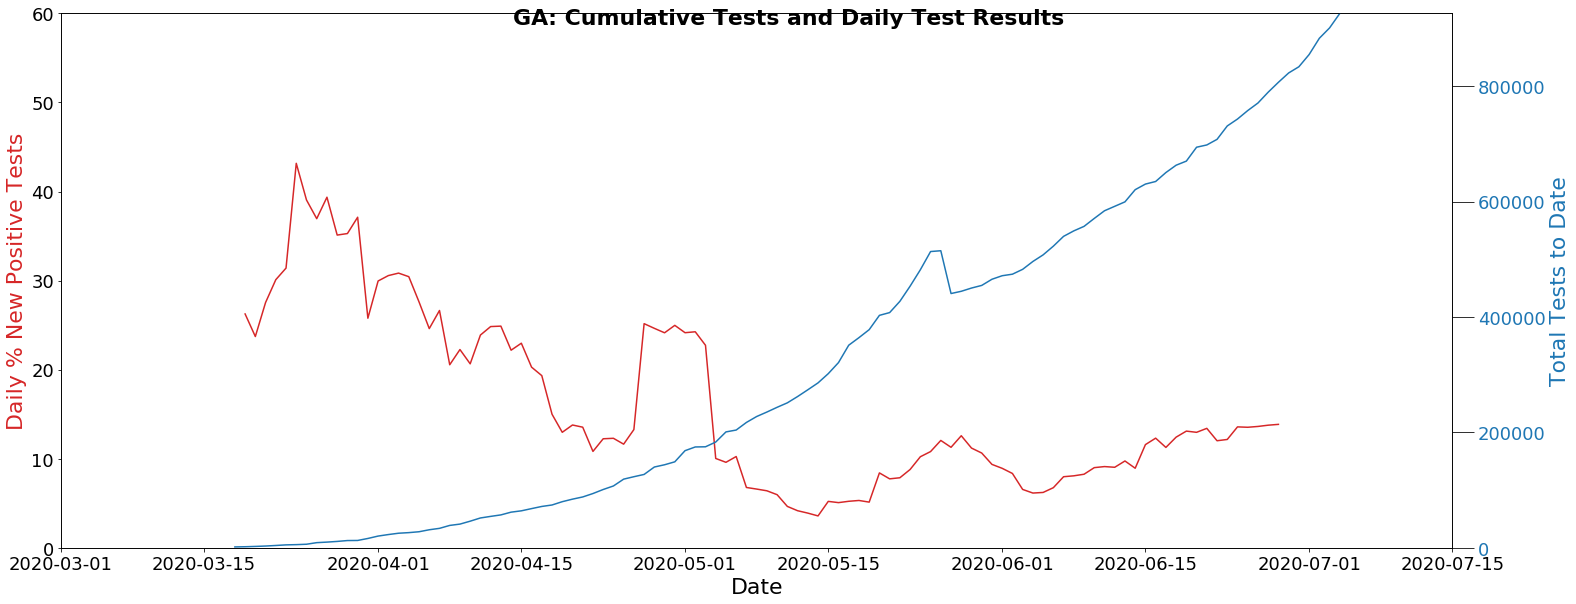

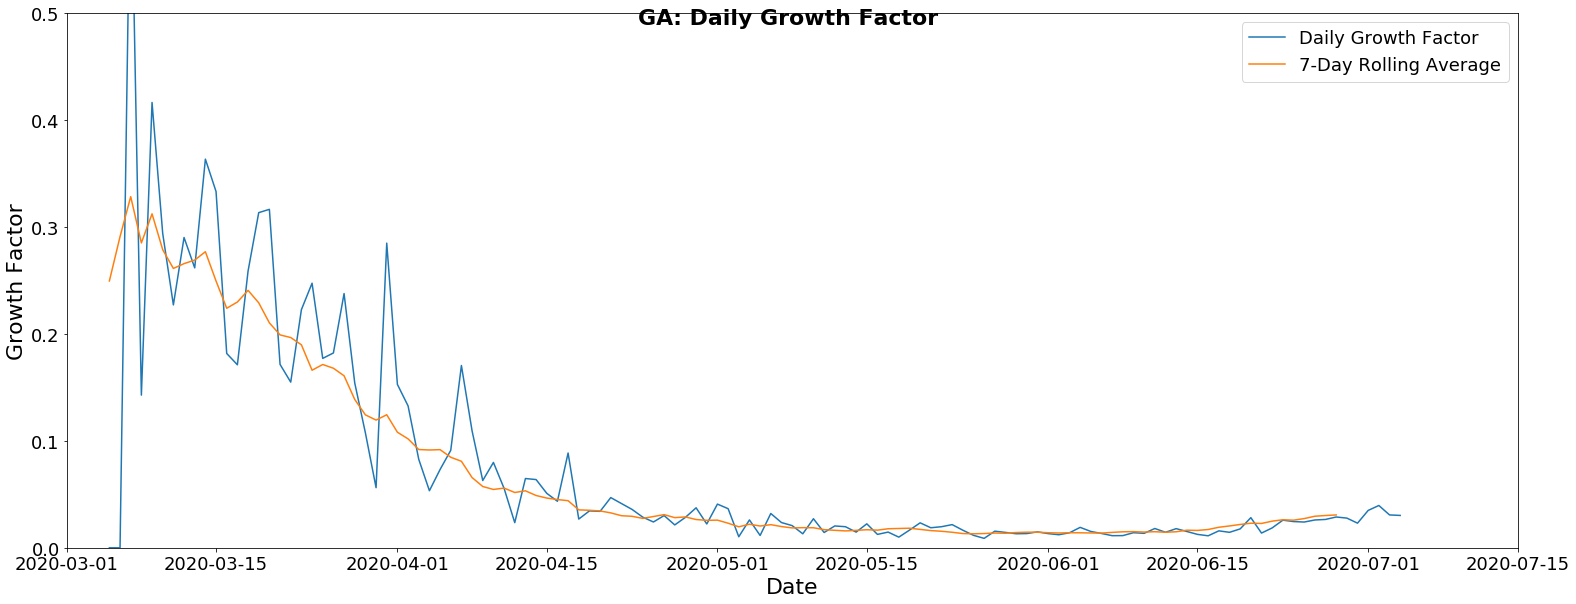

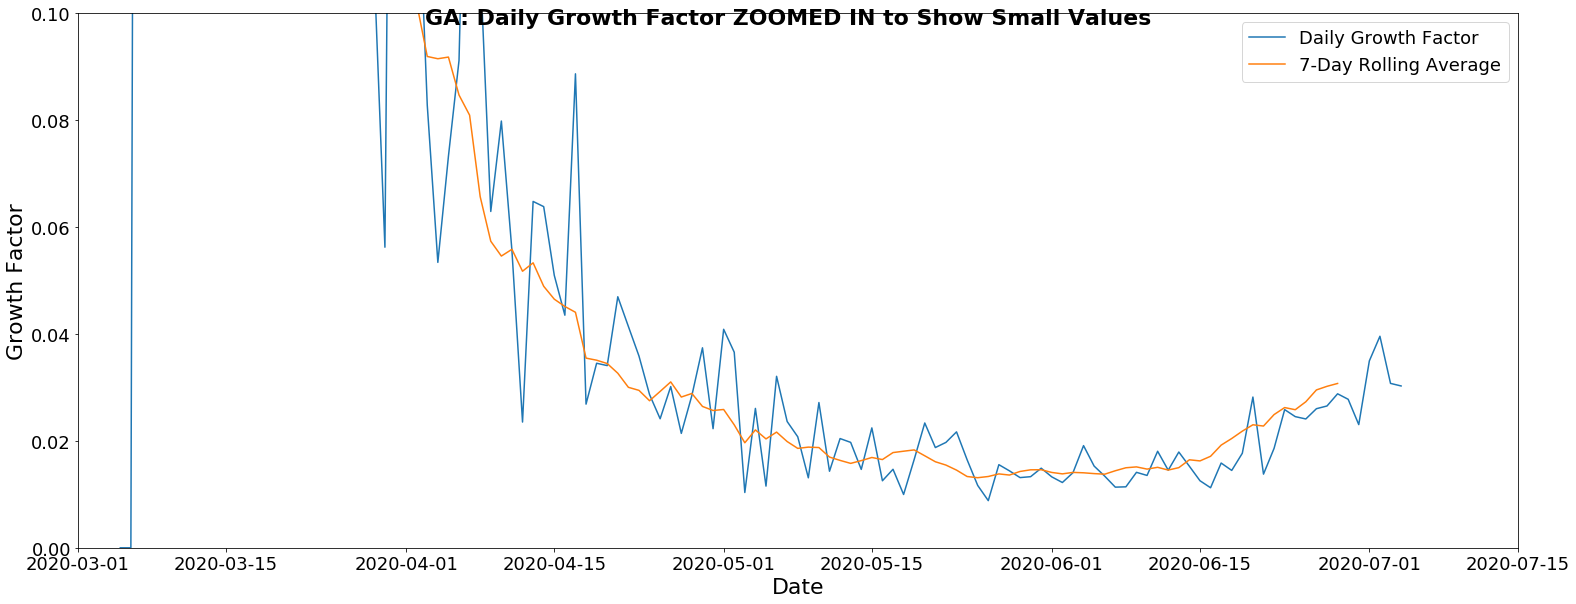












GU


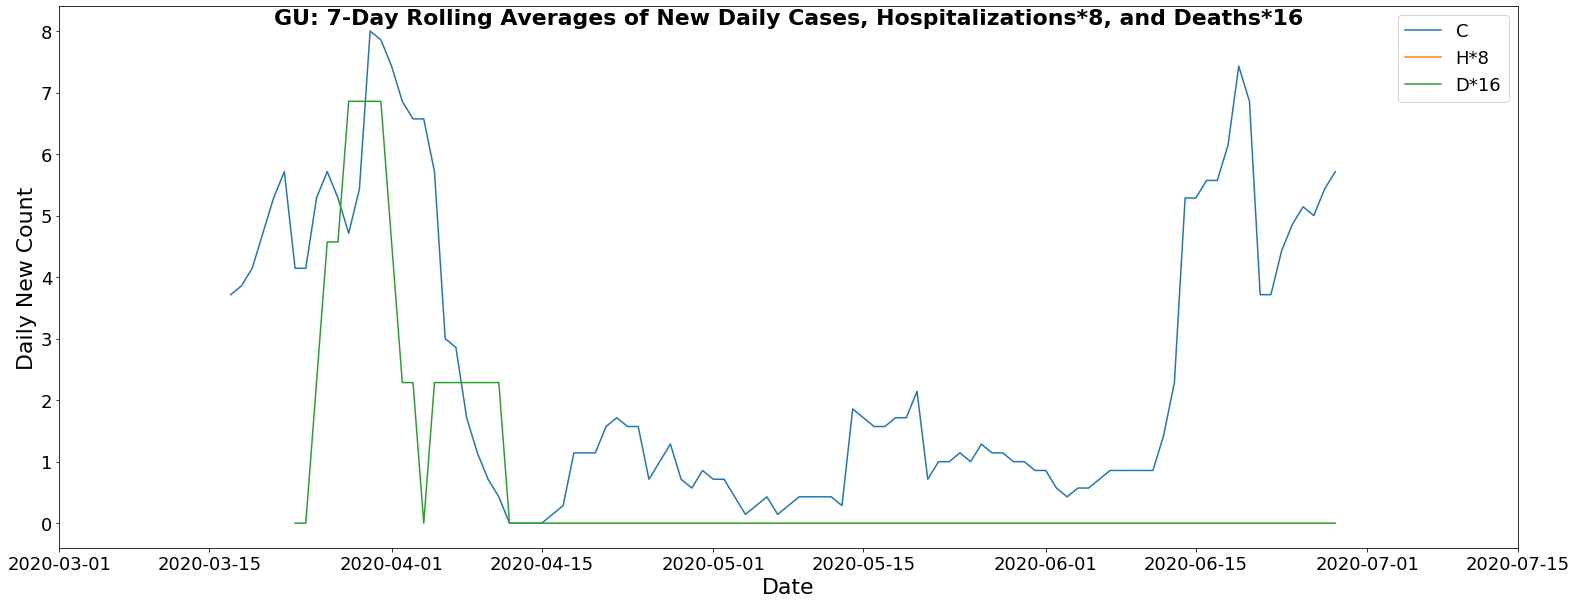

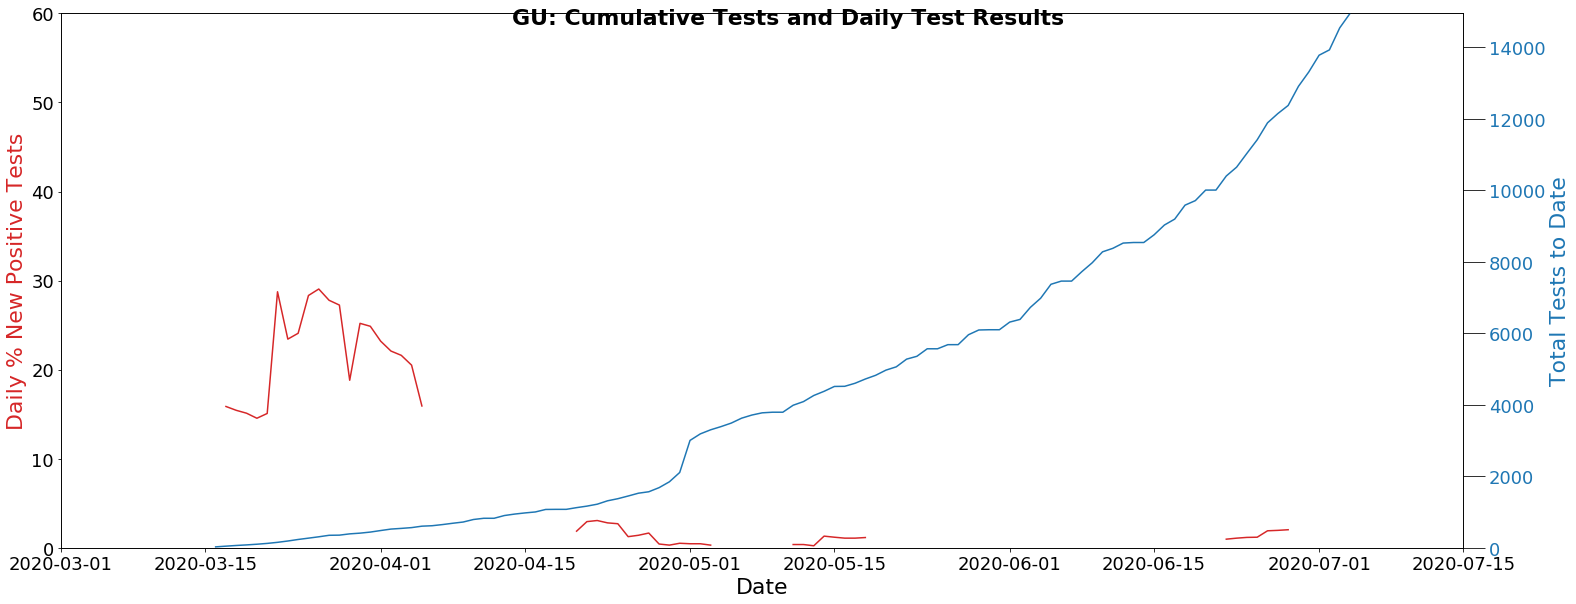

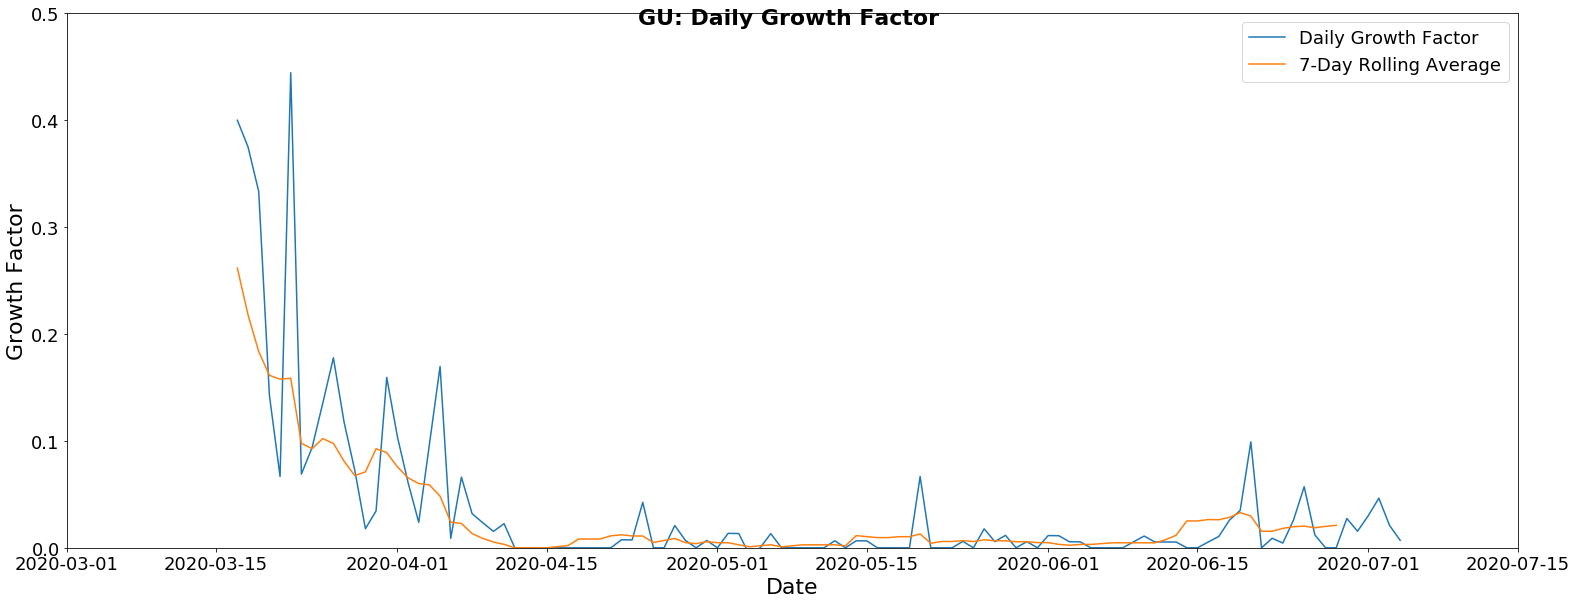

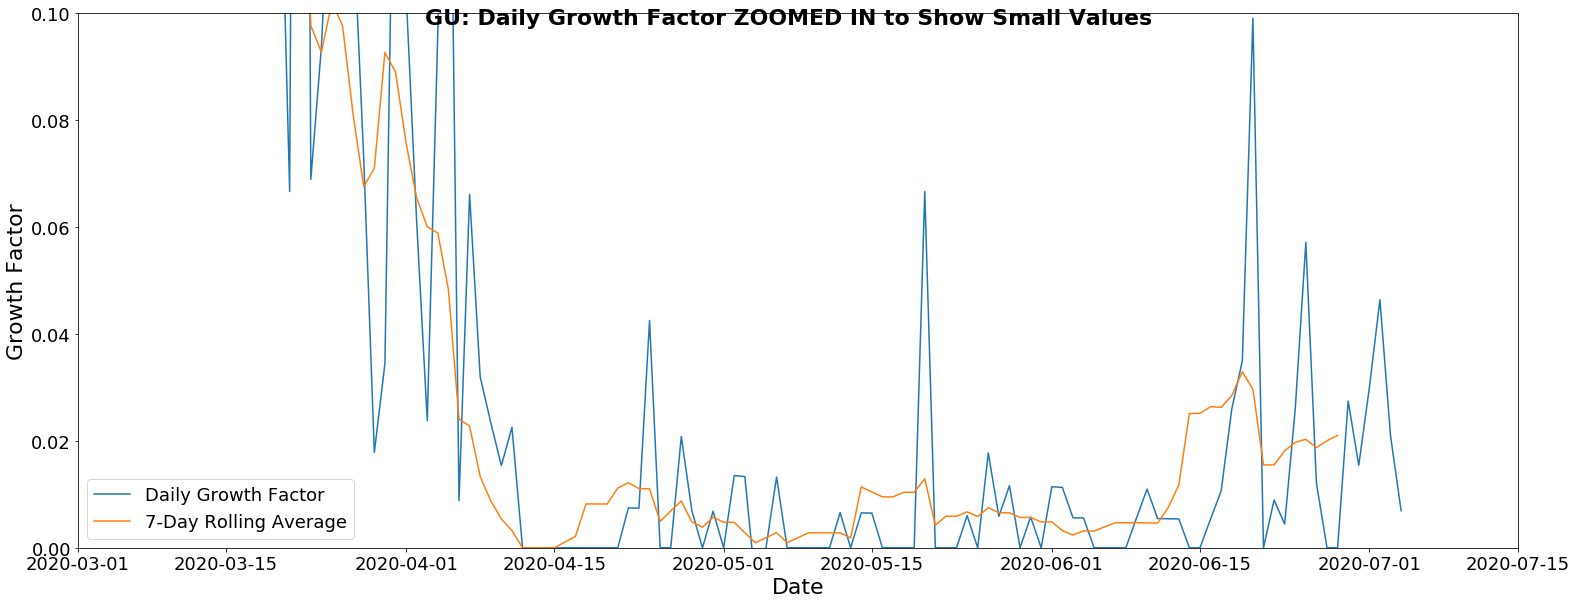












HI


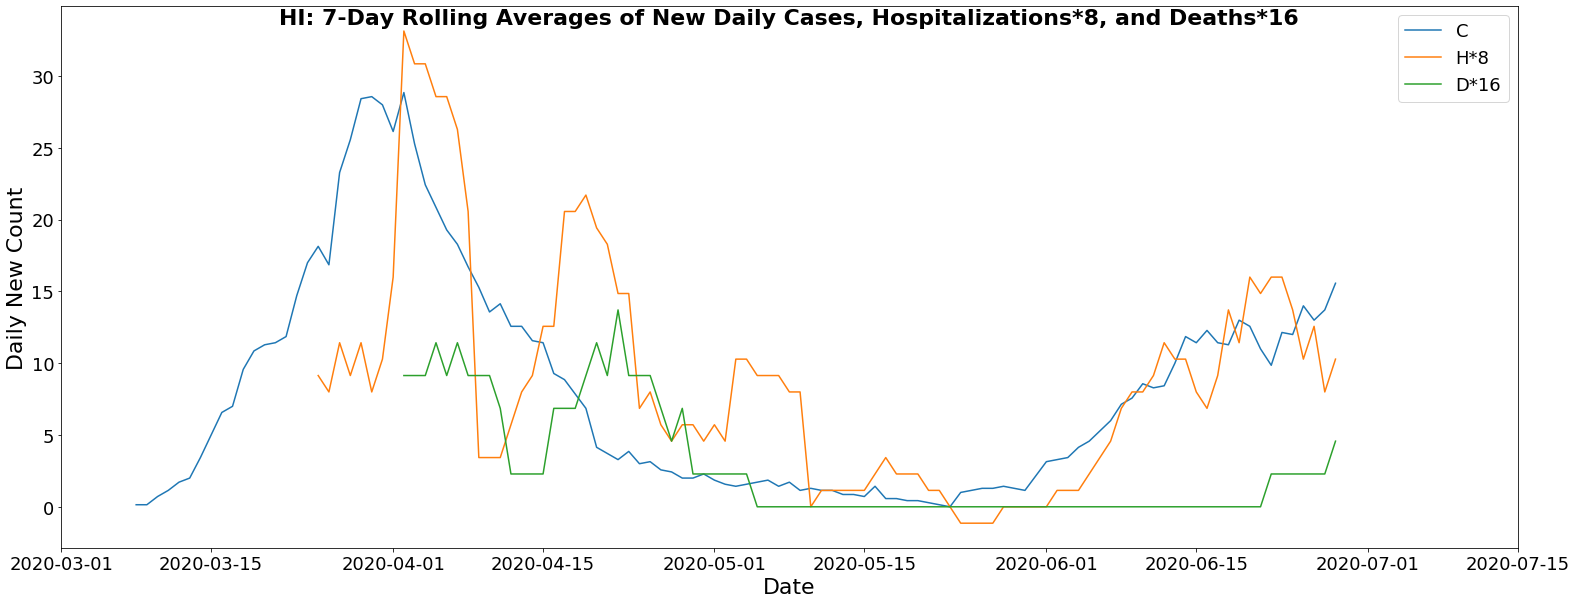

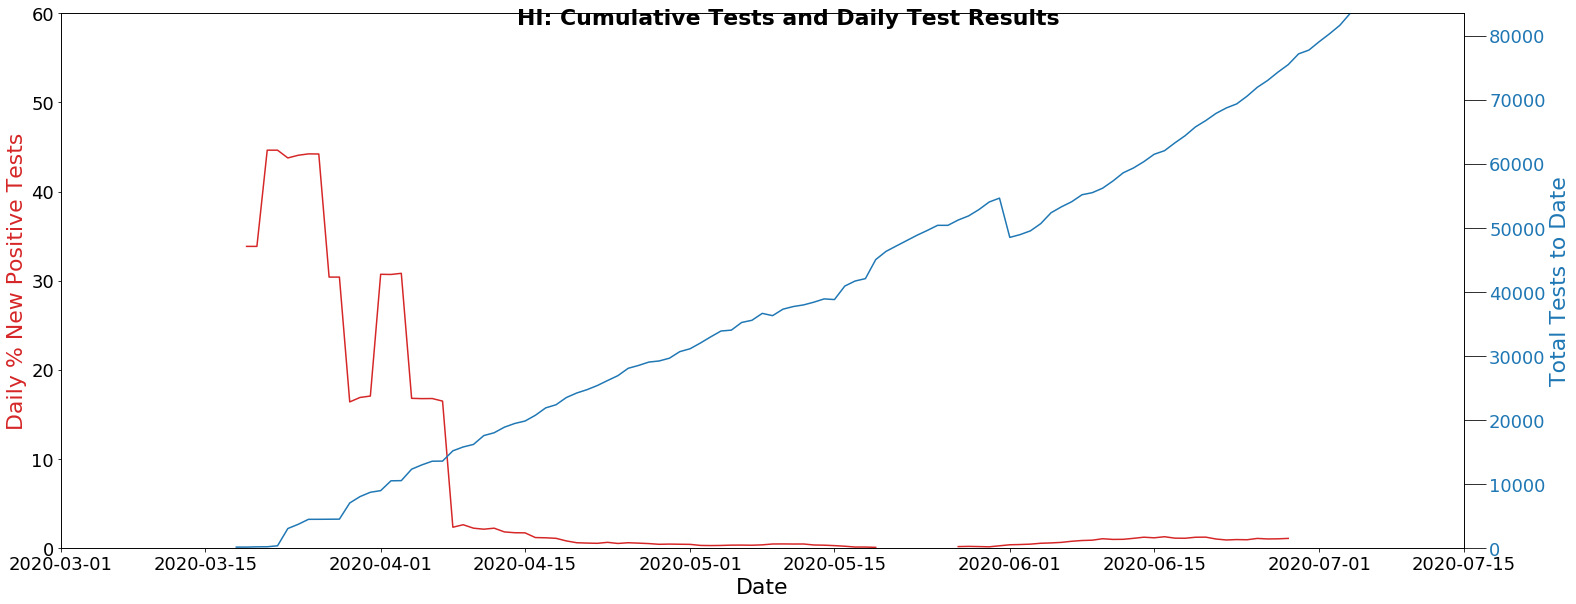

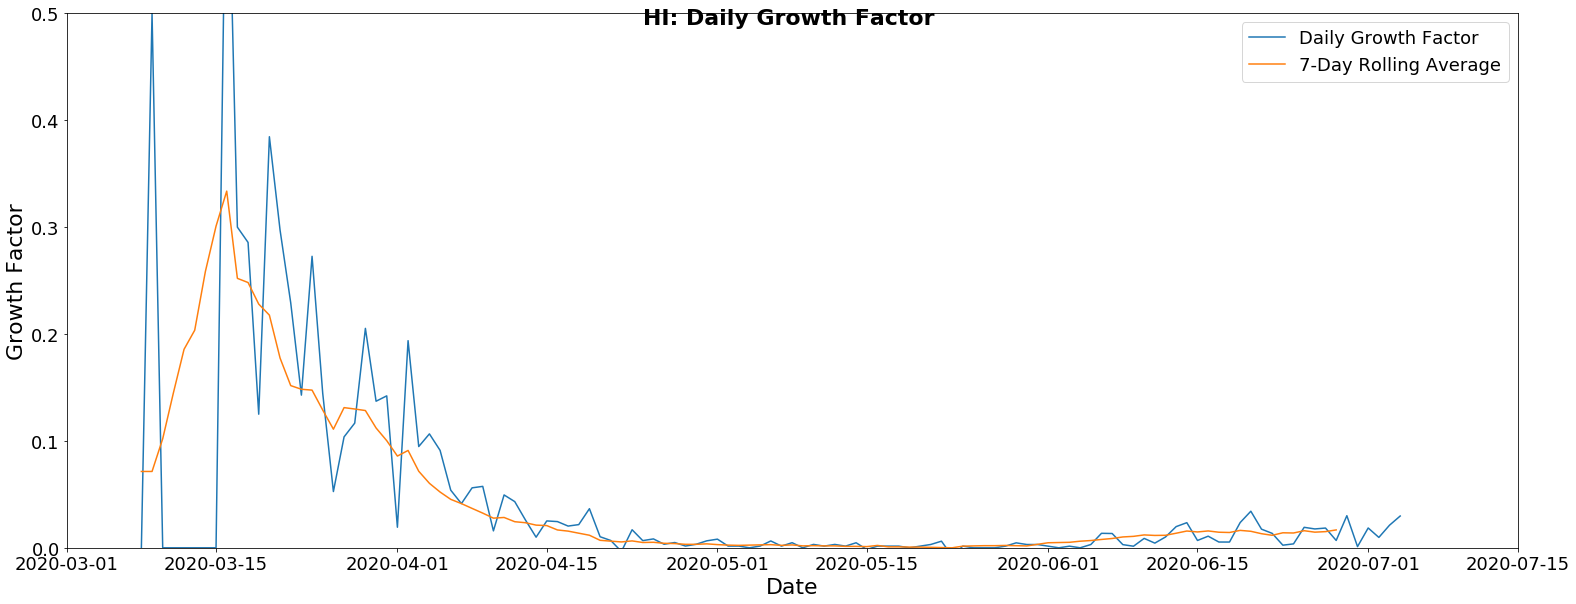

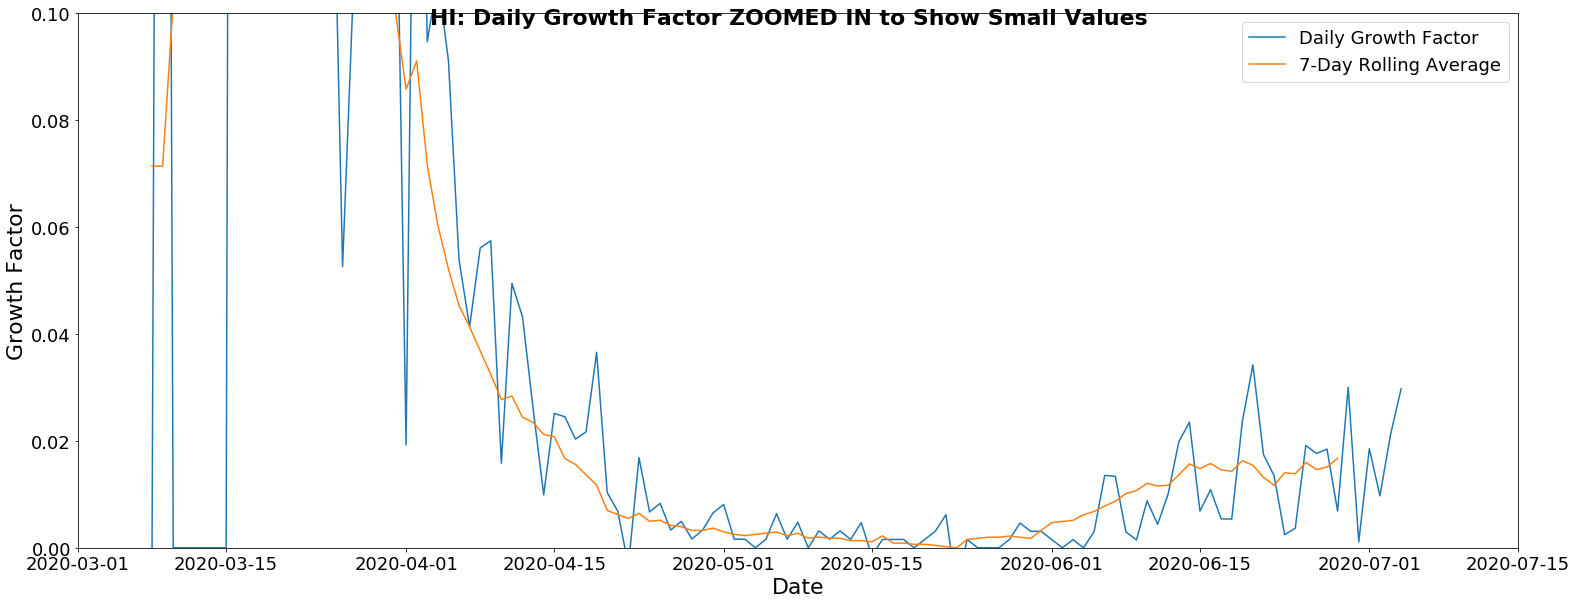












IA


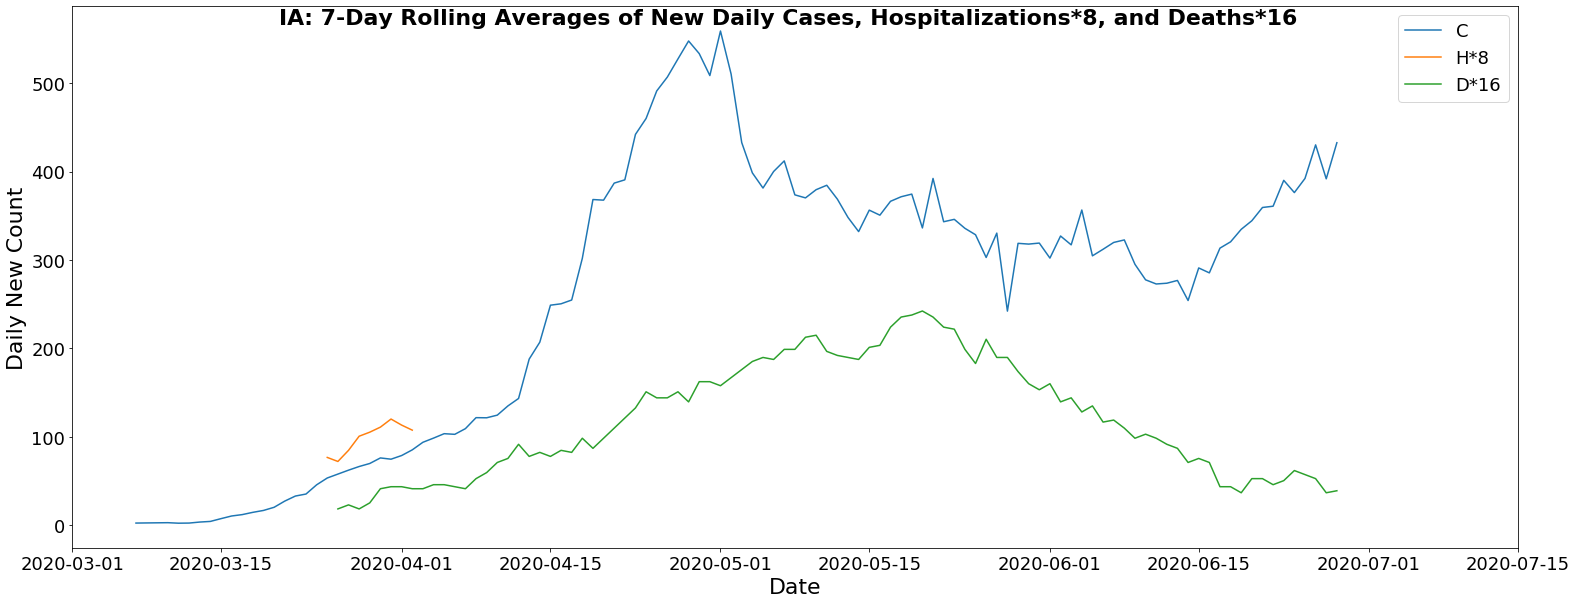

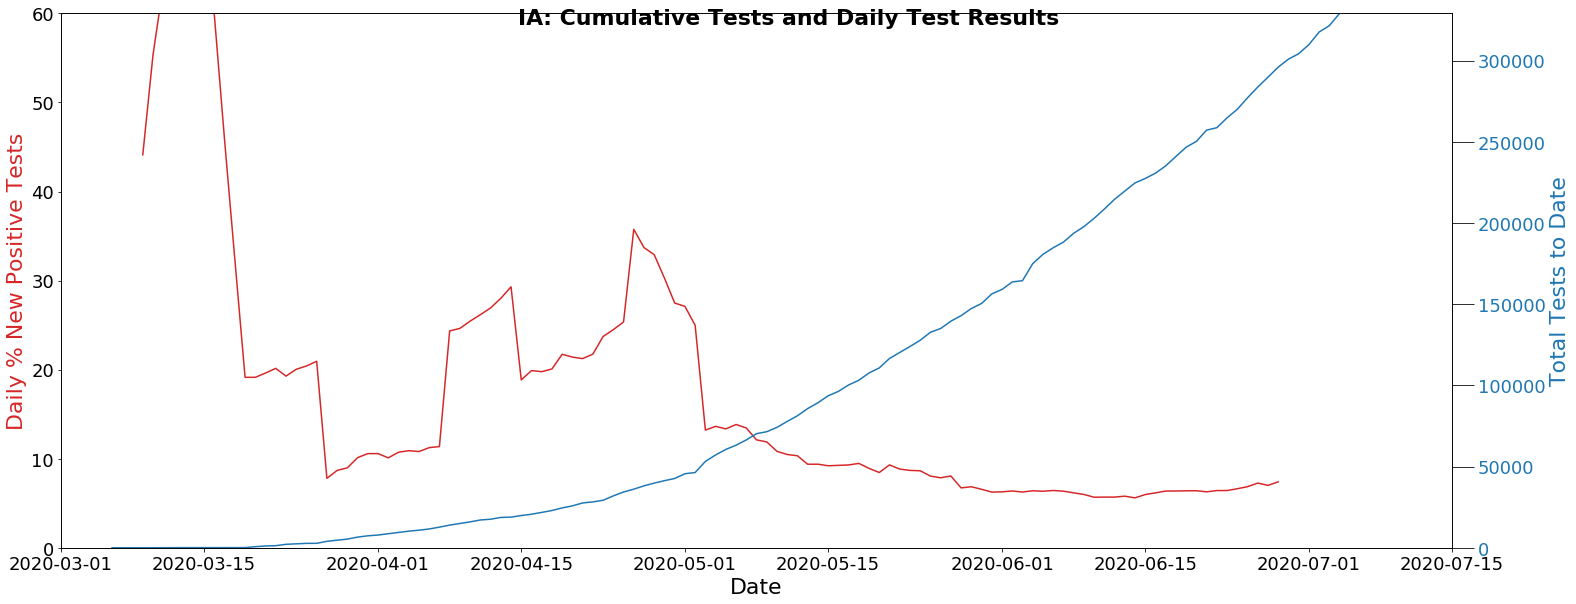

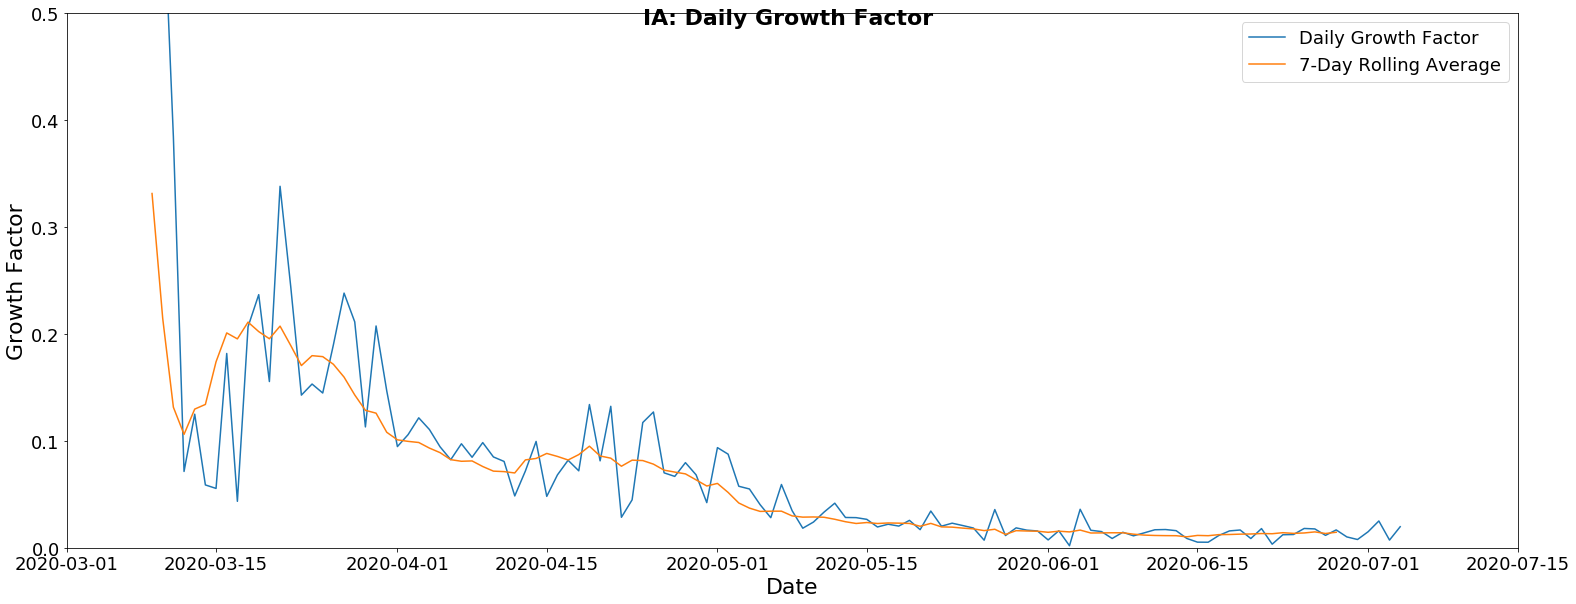

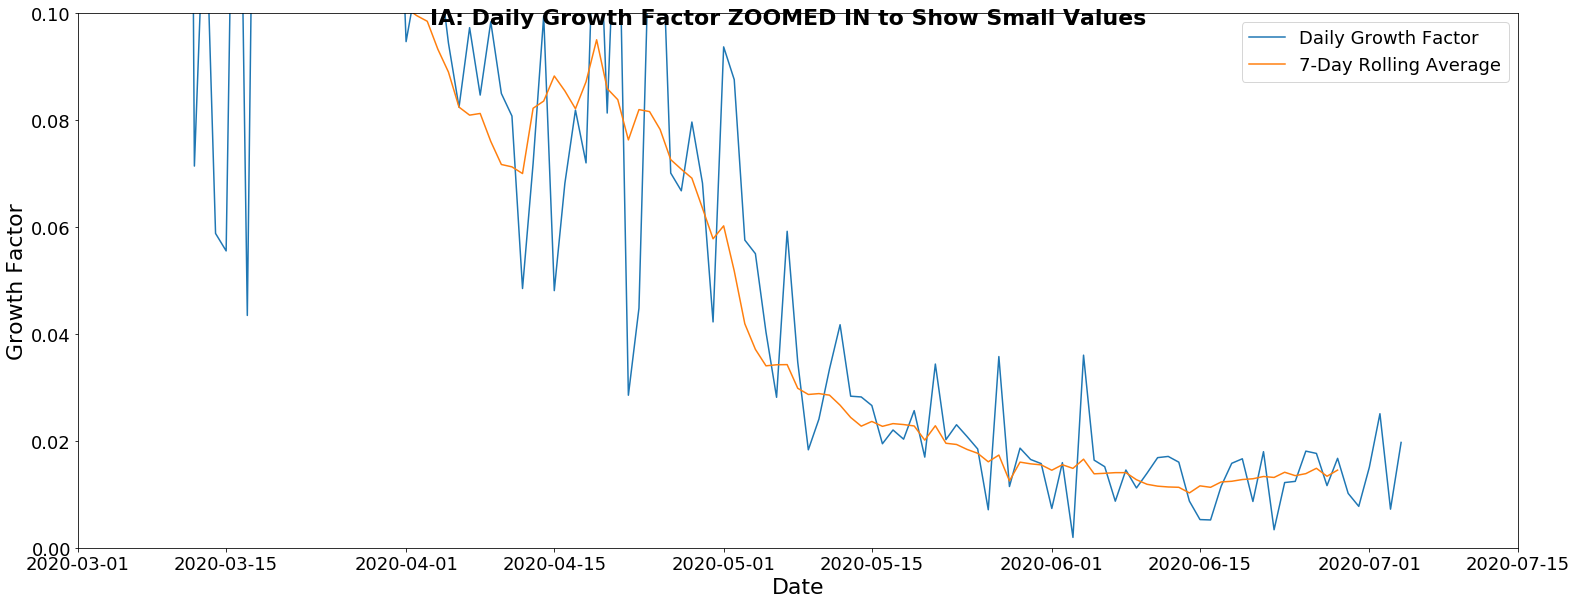












ID


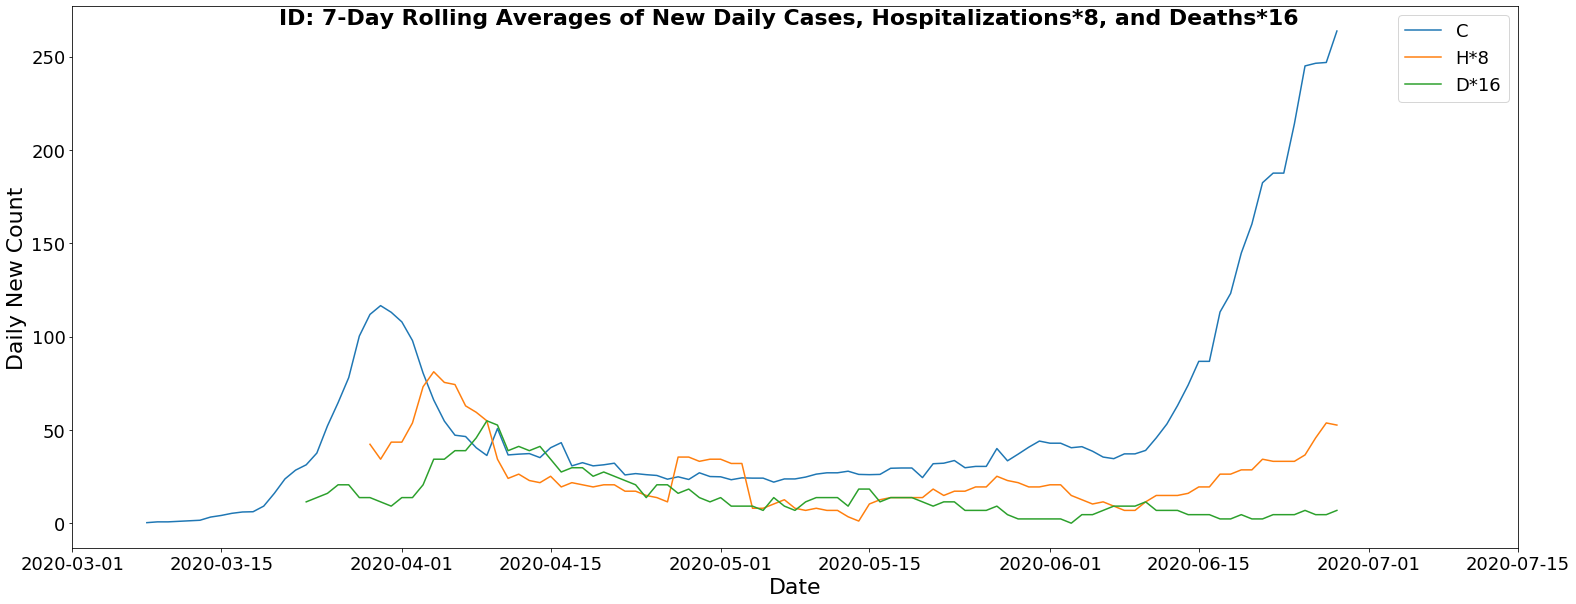

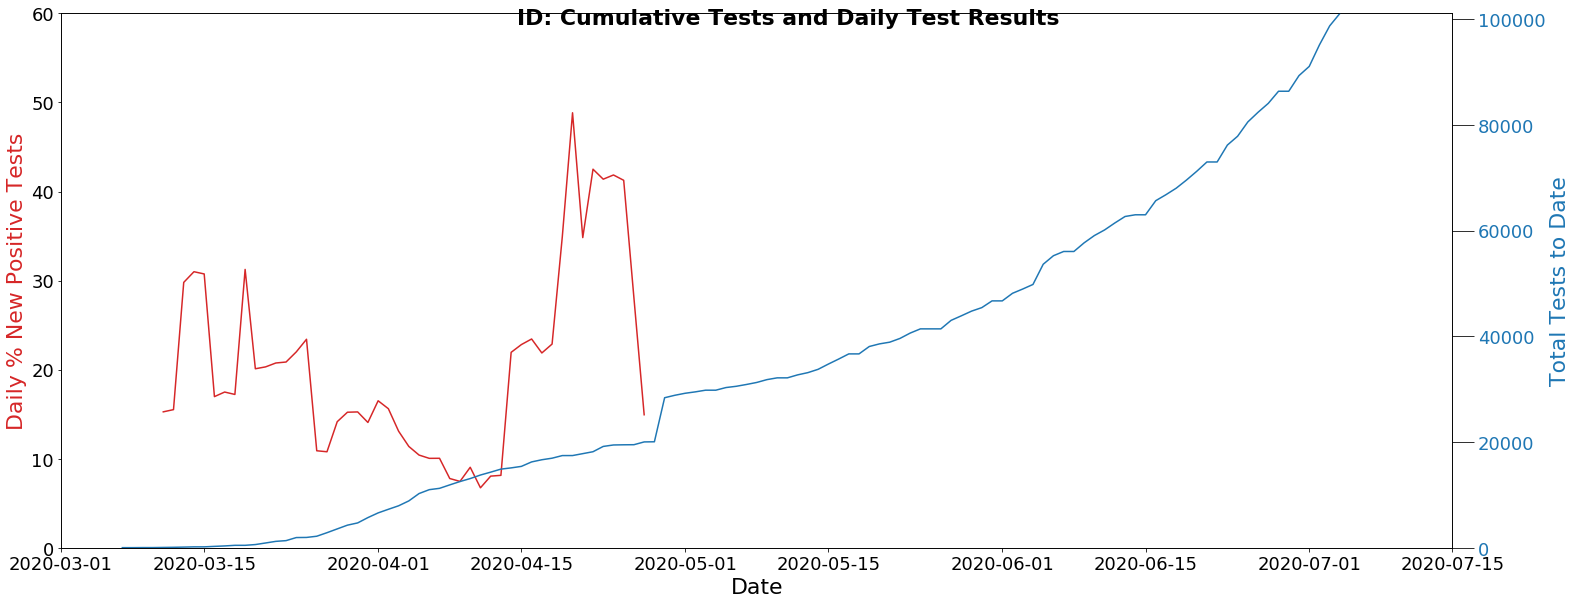

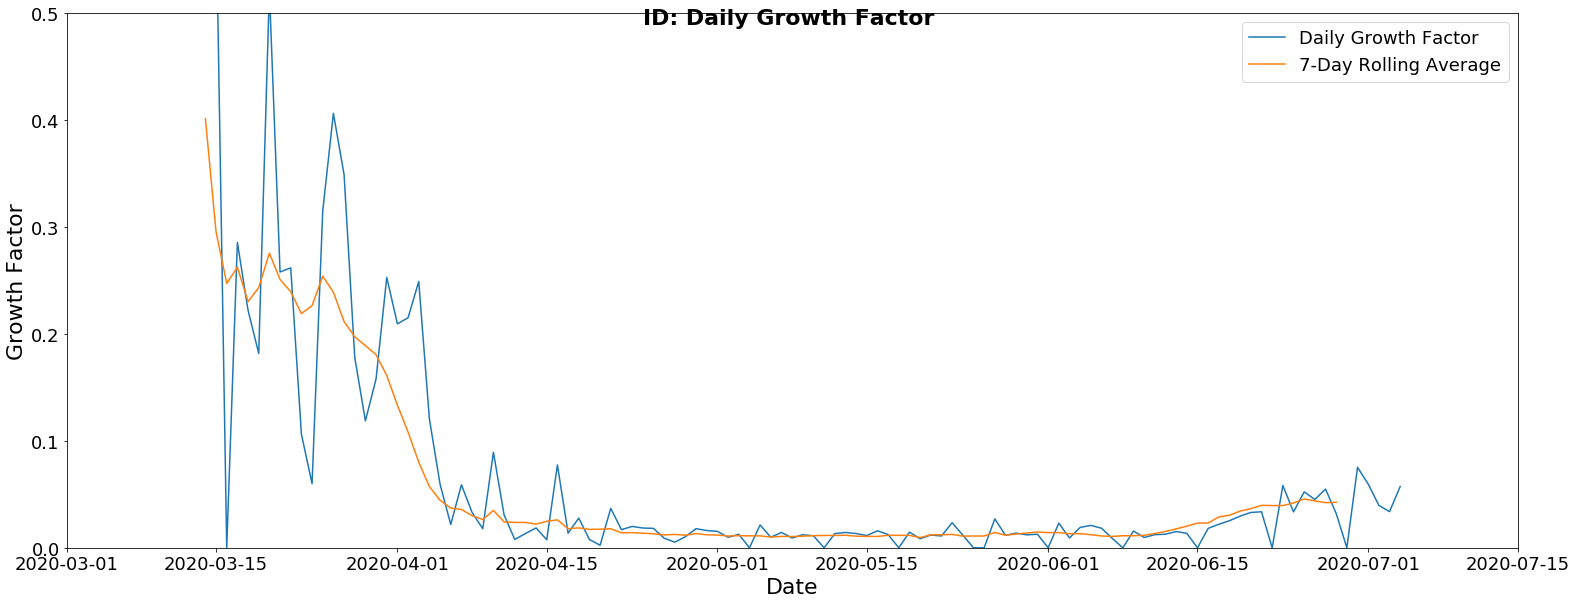

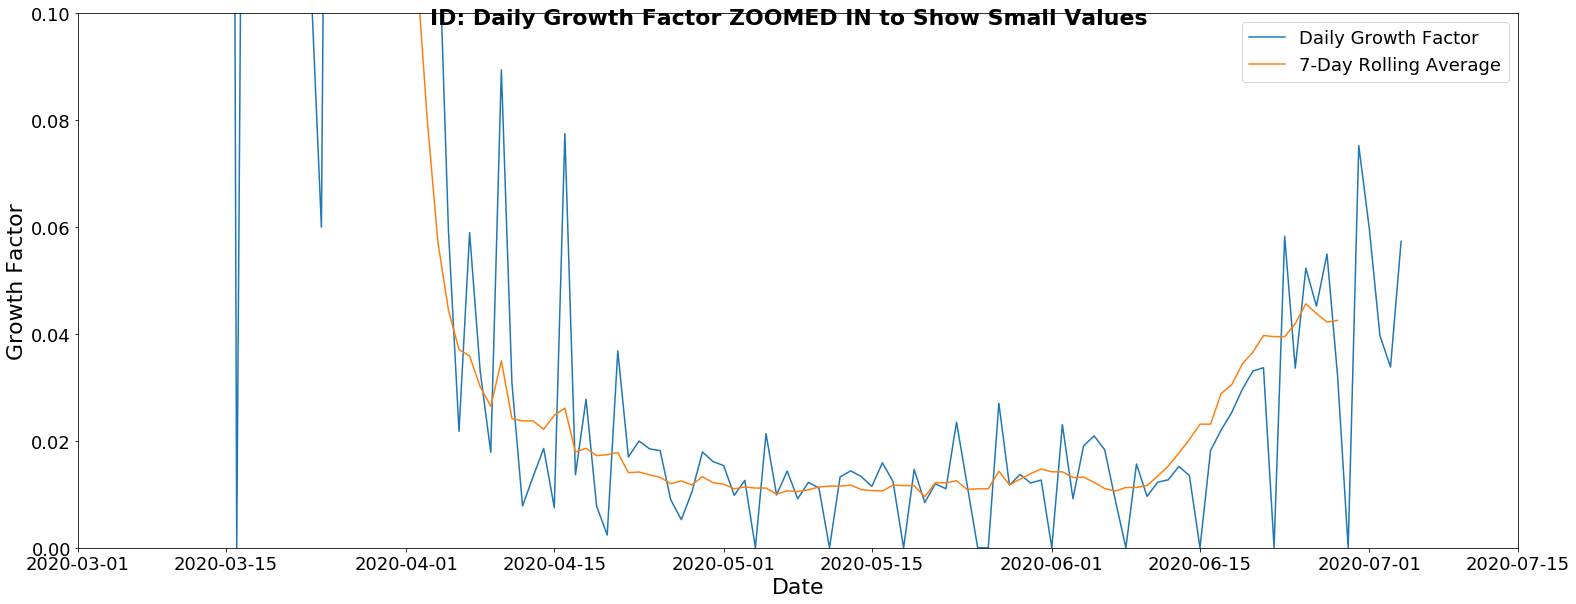












IL


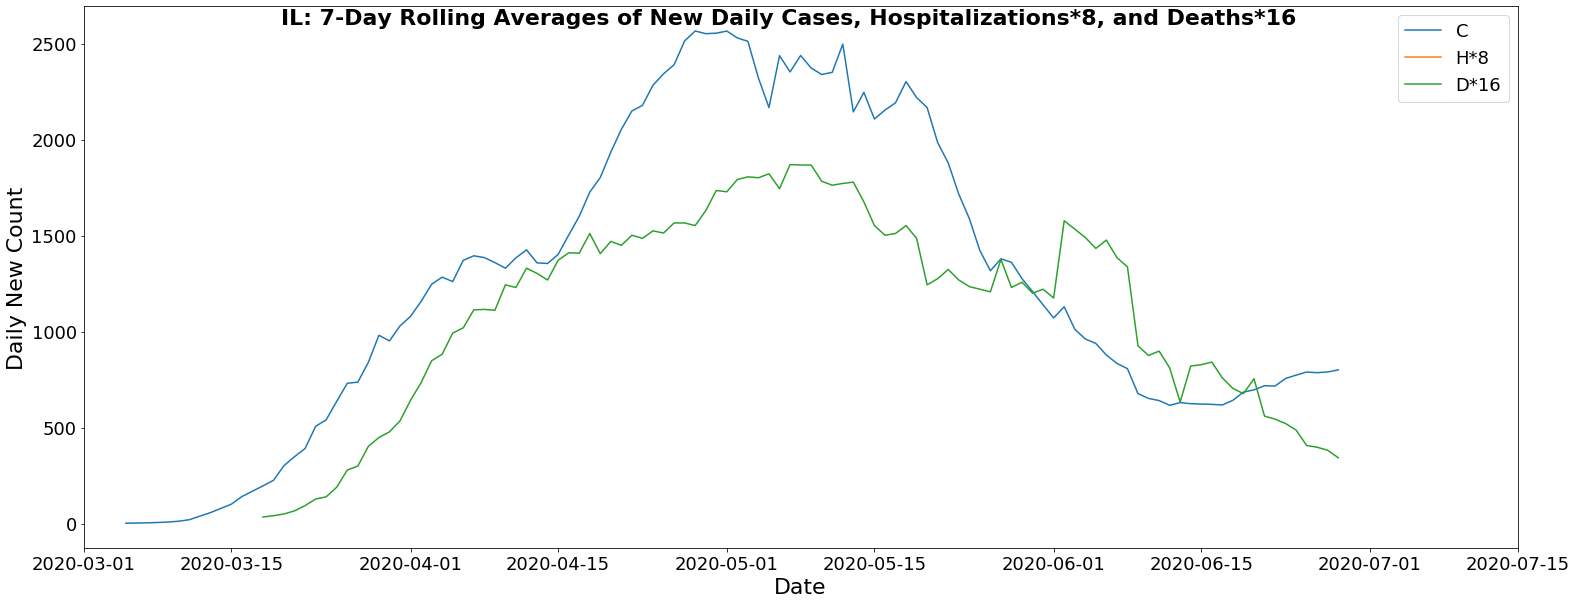

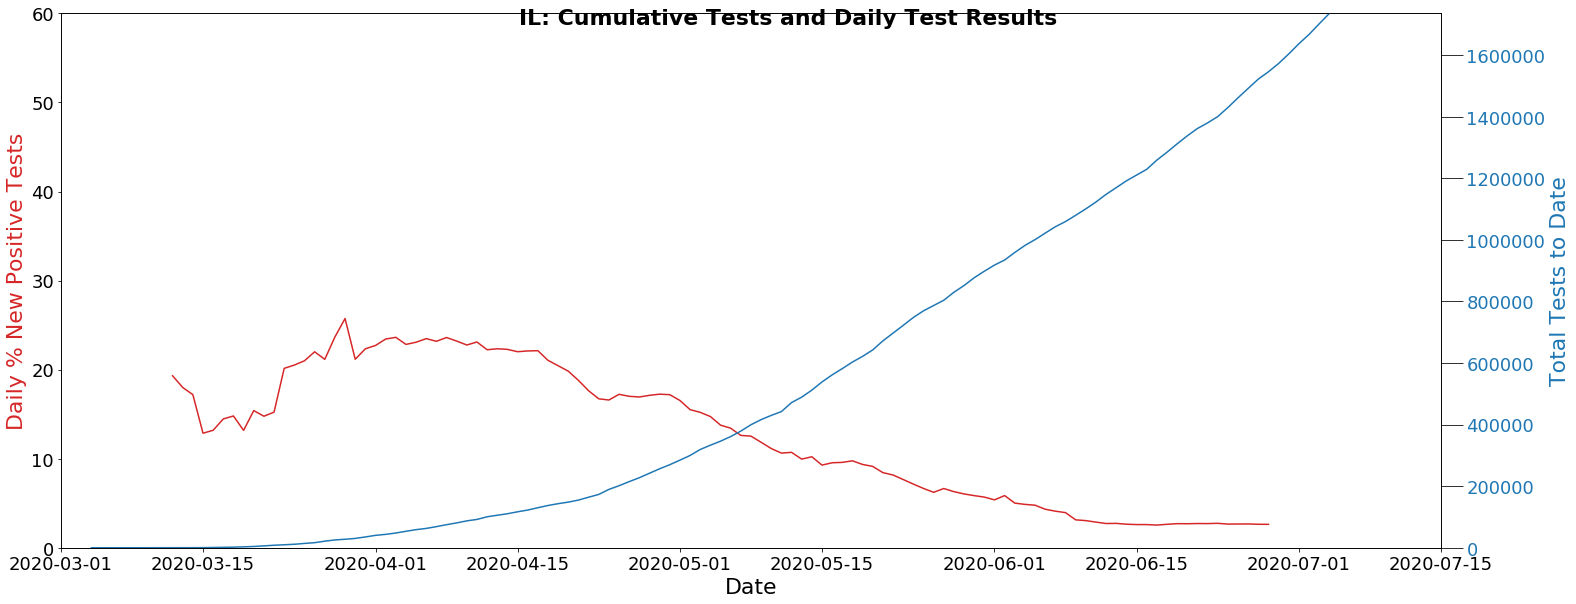

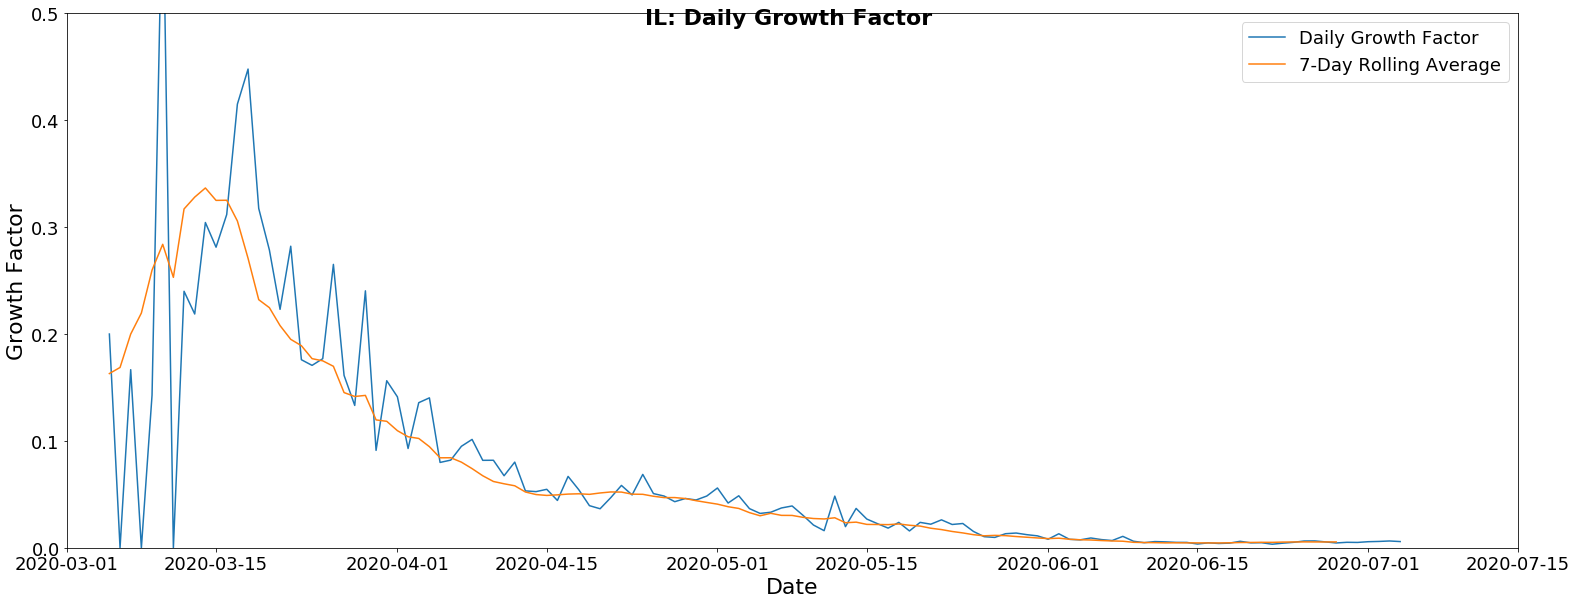

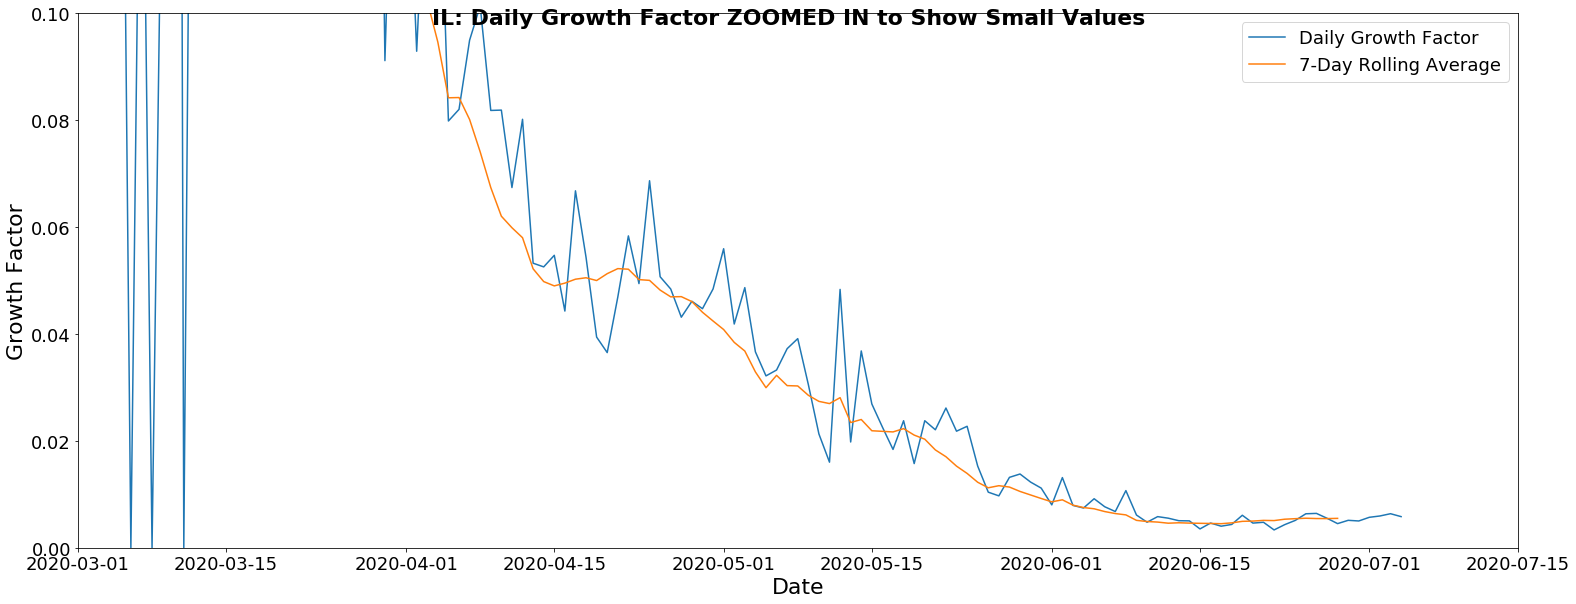












IN


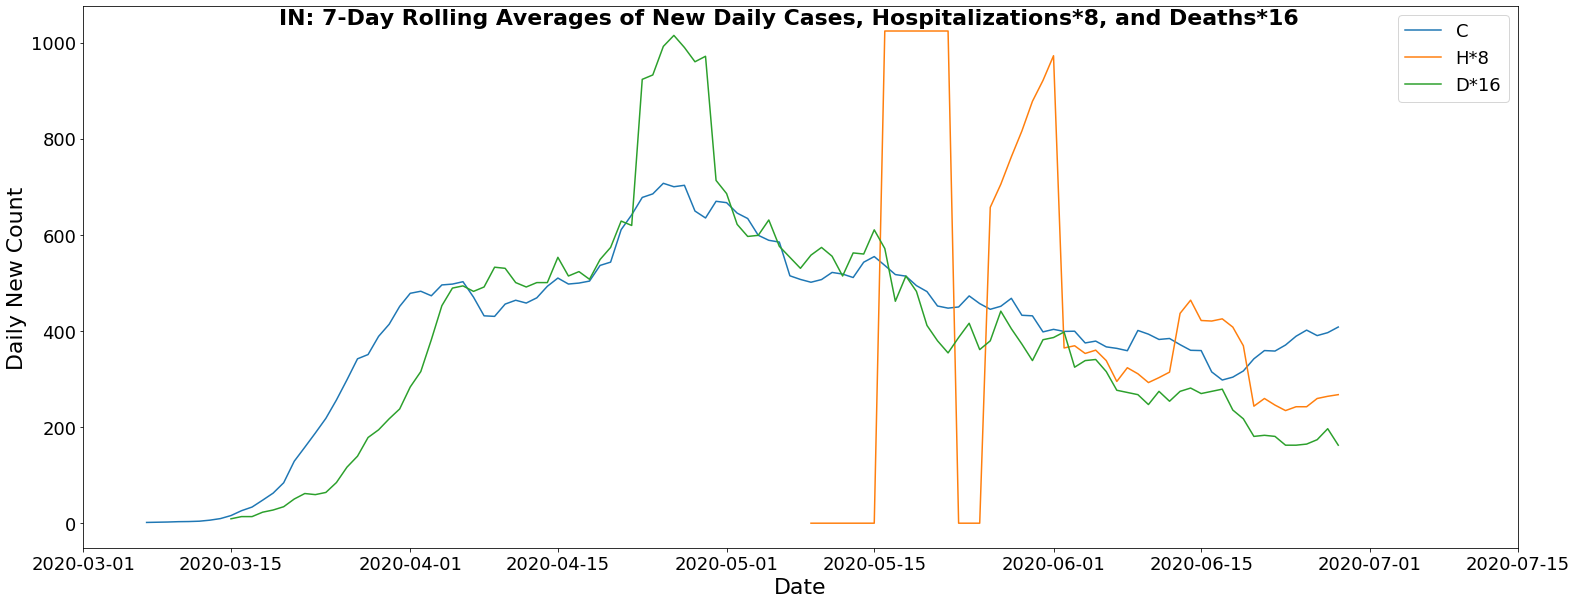

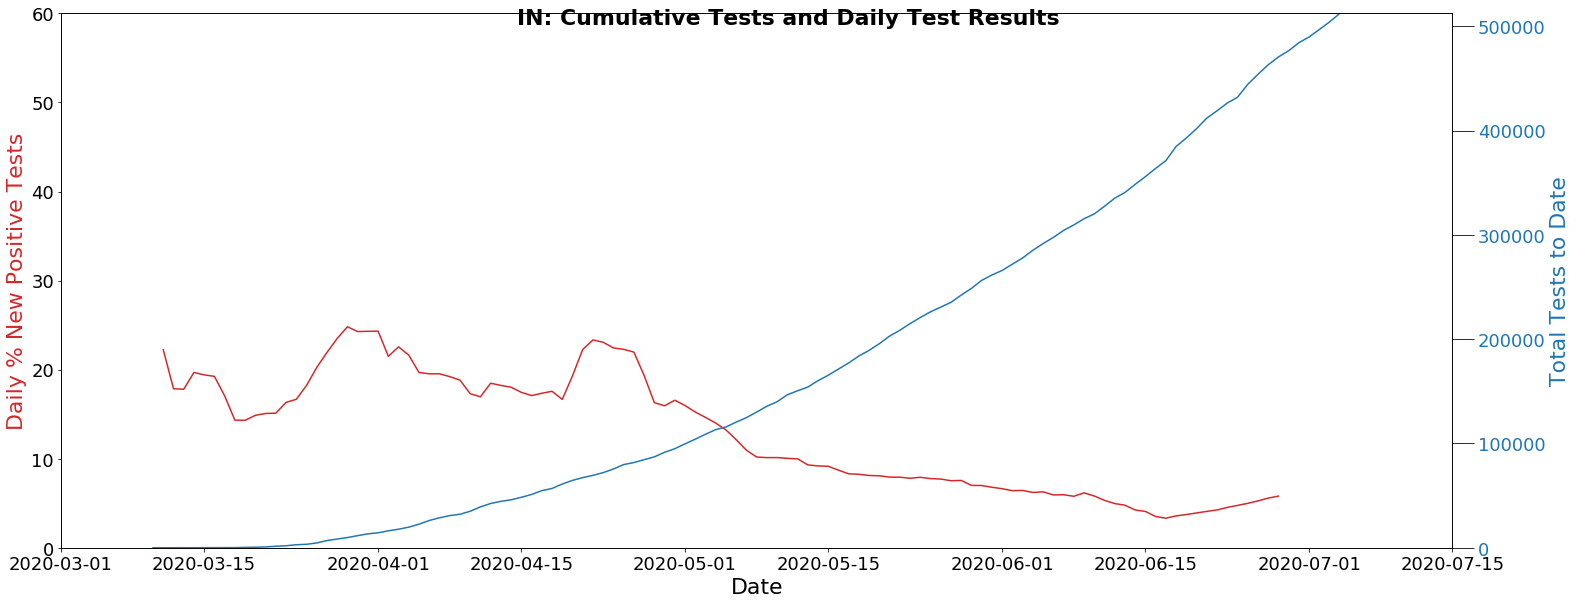

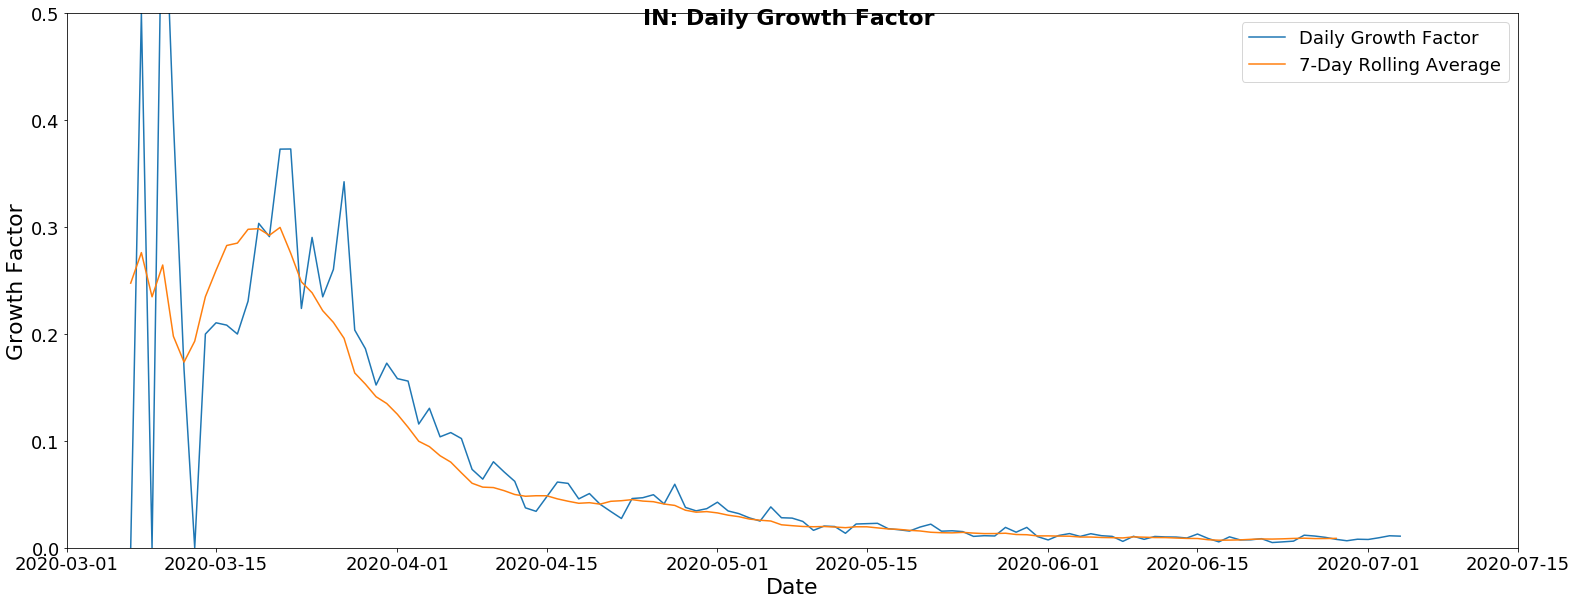

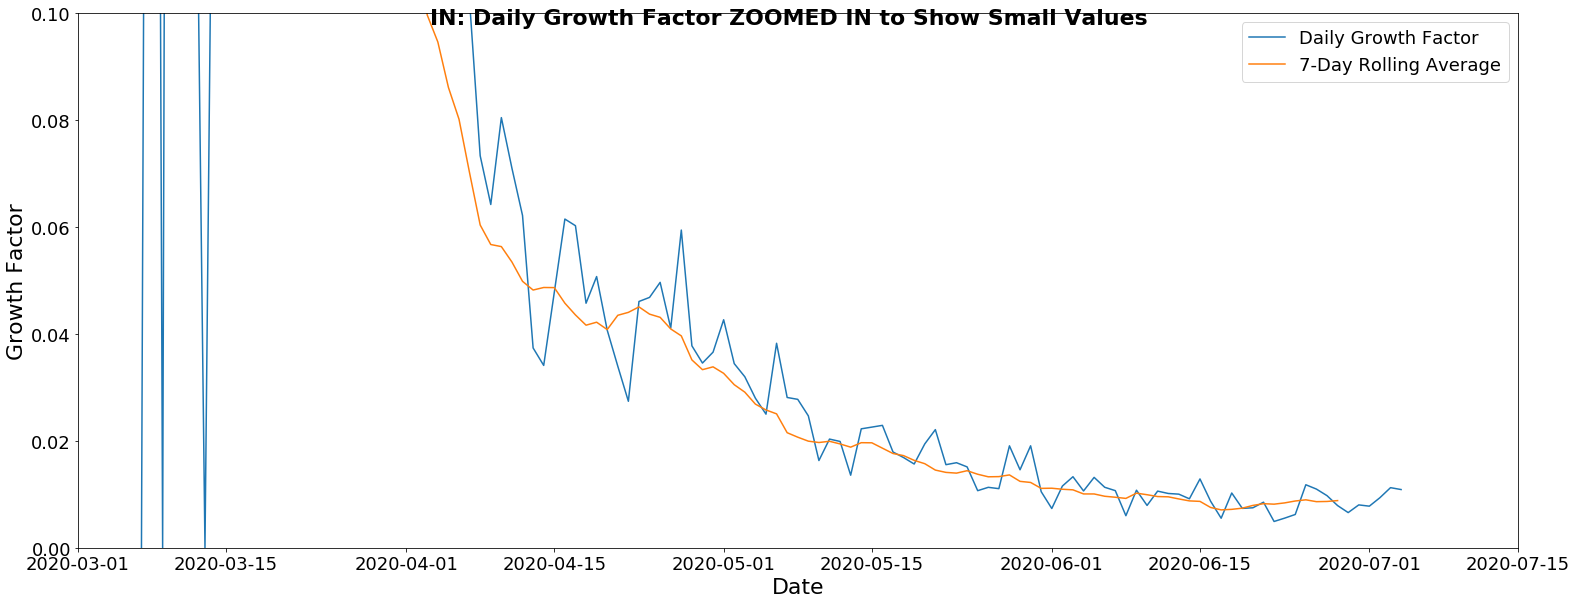












KS


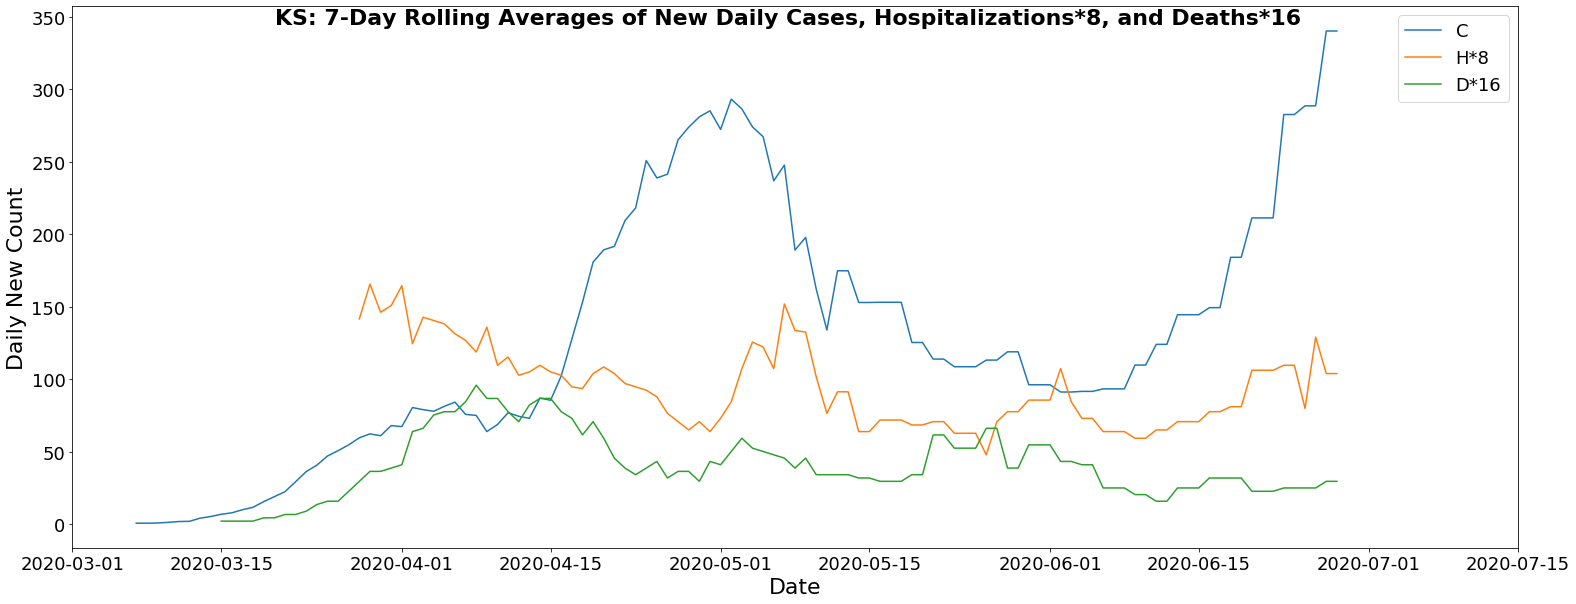

In [ ]:
for state in dfs.keys():
    print(state)
    
    ##############################   FIGURE 1   ###########################################

    fig1, ax1 = plt.subplots(figsize=(22, 8.5))
    fig1.suptitle(state + f': {window}-Day Rolling Averages of New Daily Cases, Hospitalizations*8, and Deaths*16', size=22,
                  weight='bold', va='top')

    ax1.set_xlabel('Date', size=22)
    ax1.set_ylabel('Daily New Count', size=22)
    ax1.plot(dfs[state].index, dfs[state]['new_cases_rolling'], label='C')
    ax1.plot(dfs[state].index, 8 * dfs[state]['new_hosp_rolling'], label='H*8')
    ax1.plot(dfs[state].index, 16 * dfs[state]['new_deaths_rolling'], label='D*16')
    ax1.tick_params(axis='both', which='major', labelsize=18)    
    ax1.legend(loc='upper left')
    ax1.legend(prop=dict(size=18))
    ax1.set_xlim([datetime.date(2020, 3, 1), datetime.date(2020, 7, 15)])
    
    fig1.tight_layout()
    plt.show()
    
    ##############################   FIGURE 2   ###########################################

    fig2, ax2 = plt.subplots(figsize=(22, 8.5))
    fig2.suptitle(state + ': Cumulative Tests and Daily Test Results', size=22, weight='bold', va='top')

    color = 'tab:red'
    ax2.set_xlabel('Date', size=22)
    ax2.set_ylabel('Daily % New Positive Tests', color=color, size=22)
    ax2.plot(dfs[state].index, dfs[state]['daily_pct_pos_rolling'], color=color,
             label='Daily Percentage of Tests Coming Back Positive')
    ax2.tick_params(axis='both', which='major', labelsize=18)    
    ax2.set_xlim([datetime.date(2020, 3, 1), datetime.date(2020, 7, 15)])
    ax2.set_ylim([0, 60])

    ax2 = ax2.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Total Tests to Date', color=color, size=22)
    ax2.tick_params(axis='both', which='major', labelsize=18)    
    ax2.plot(dfs[state].index, dfs[state]['total_tests'], color=color, label='Total Tests to Date')
    ax2.tick_params(axis='y', labelcolor=color, size=22)
    ax2.set_ylim([0, np.max(dfs[state]['total_tests'])])


    fig2.tight_layout()
    plt.show()

    ##############################   FIGURE 3   ###########################################

    fig3, ax3 = plt.subplots(figsize=(22, 8.5))
    fig3.suptitle(state + ': Daily Growth Factor', size=22, weight='bold', va='top')

    ax3.set_xlabel('Date', size=22)
    ax3.set_ylabel('Growth Factor', size=22)
    ax3.plot(dfs[state].index, dfs[state].daily_growth_factor_a, label='Daily Growth Factor')
    ax3.plot(dfs[state].index, dfs[state].daily_growth_factor_a.rolling(window=7).mean(), label=f'{window}-Day Rolling Average')
    ax3.tick_params(axis='both', which='major', labelsize=18)    
    ax3.legend(loc='upper left')
    ax3.legend(prop=dict(size=18))
    ax3.set_xlim([datetime.date(2020, 3, 1), datetime.date(2020, 7, 15)])
    ax3.set_ylim([0, 0.5])

    fig3.tight_layout()
    plt.show()

    ##############################   FIGURE 4   ###########################################

    fig4, ax4 = plt.subplots(figsize=(22, 8.5))
    fig4.suptitle(state + ': Daily Growth Factor ZOOMED IN to Show Small Values', size=22, weight='bold', va='top')

    ax4.set_xlabel('Date', size=22)
    ax4.set_ylabel('Growth Factor', size=22)
    ax4.plot(dfs[state].index, dfs[state].daily_growth_factor_a, label='Daily Growth Factor')
    ax4.plot(dfs[state].index, dfs[state].daily_growth_factor_a.rolling(window=window).mean(), label=f'{window}-Day Rolling Average')
    ax4.tick_params(axis='both', which='major', labelsize=18)    
    ax4.legend(loc='upper left')
    ax4.legend(prop=dict(size=18))
    ax4.set_xlim([datetime.date(2020, 3, 1), datetime.date(2020, 7, 15)])
    ax4.set_ylim(0, 0.1)

    fig4.tight_layout()
    plt.show()
    
    print('\n'*10)

### New Cases Rolling Average for Select States

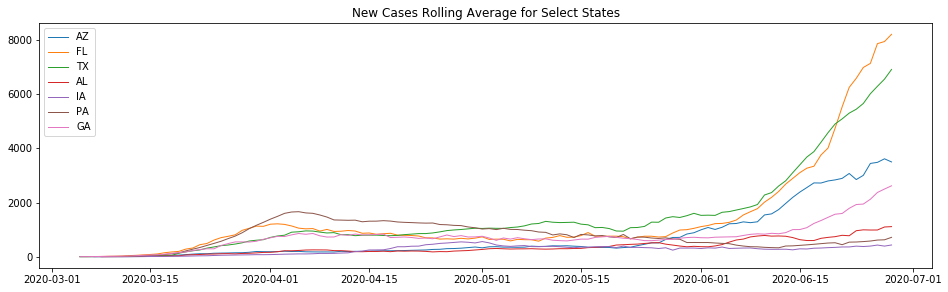

In [20]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,30))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Cases Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','PA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_cases_rolling, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### PER CAPITA New Cases Rolling Average for Select States

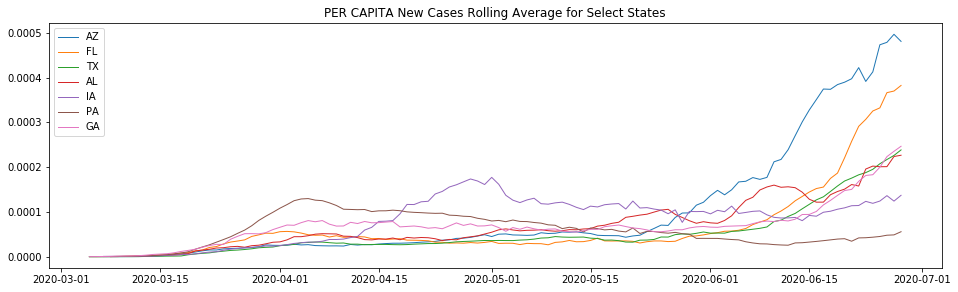

In [21]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,30))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('PER CAPITA New Cases Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','PA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_cases_rolling_pc, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### New Deaths Rolling Average for Select States

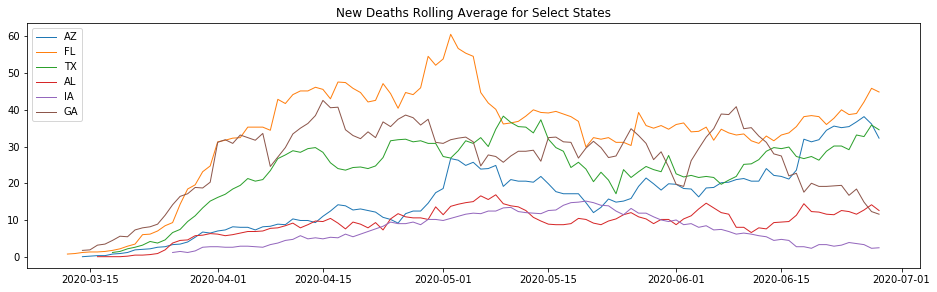

In [22]:
#plt.ylim(0,2000)
#plt.xlim(datetime.date(2020,3,1), datetime.date(2020,6,15))
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Deaths Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_deaths_rolling, label=state, linewidth=1.0)
    fig = plt.legend(loc = 'upper left')

### PER CAPITA New Deaths Rolling Average for Select States

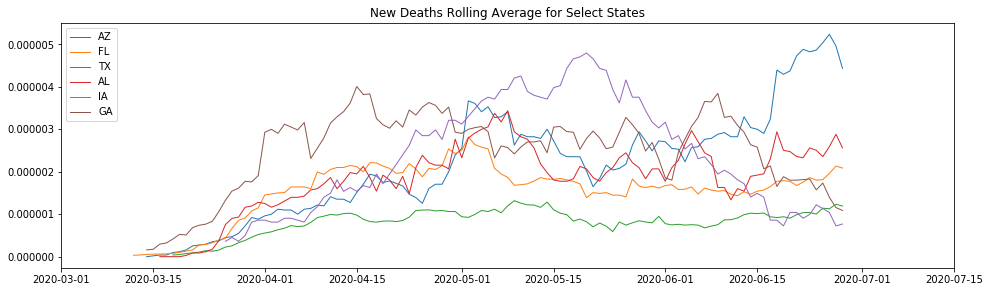

In [23]:
#plt.ylim(0,2000)
#plt.xticks(np.arange(datetime.date(2020,3,1), datetime.date(2020,5,15)))
plt.figure(figsize=(16,4.5))
plt.title('New Deaths Rolling Average for Select States')
for state in ['AZ','FL','TX','AL','IA','GA']:
    plt.plot(dfs[state].index,dfs[state].new_deaths_rolling_pc, label=state, linewidth=1.0)
    plt.xlim(datetime.date(2020,3,1), datetime.date(2020,7,15))
    fig = plt.legend(loc = 'upper left')